- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adagrad,Adadelta

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

In [4]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [5]:
#First Model
def create_model():
    model = Sequential()
    model.add(Dense(
        50, 
        activation='swish', 
        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.l2(1e-4),
        activity_regularizer=regularizers.l2(1e-5)))
    #model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(0.3))
    #model.add(Dense(64,activation='swish'))
    #model.add(Dropout(0.2))
    #model.add(Dense(128,activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    optimizer=Adadelta(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy',auc_roc])
    return model

In [6]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=200, batch_size=512, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [7]:
# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__k': [12],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        #'model__batch_size': [8, 16, 24, 32, 40, 48],#usually multiple of 8
        #'model__epochs':[100,150,200],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search


Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0001 Epoch 1/200
4/4 [==============================] - 19s 286ms/step - loss: 0.6539 - accuracy: 0.6303 - auc_roc: 0.6764
Epoch 2/200
4/4 [==============================] - 1s 258ms/step - loss: 0.6610 - accuracy: 0.6102 - auc_roc: 0.6637
Epoch 3/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6651 - accuracy: 0.5954 - auc_roc: 0.6491
Epoch 4/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6559 - accuracy: 0.6101 - auc_roc: 0.6727
Epoch 5/200
4/4 [==============================] - 1s 233ms/step - loss: 0.6586 - accuracy: 0.6186 - auc_roc: 0.6686
Epoch 6/200
4/4 [==============================] - 1s 272ms/step - loss: 0.6580 - accuracy: 0.6243 - auc_roc: 0.6623
Epoch 7/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6539 - accuracy: 0.6191 - auc_roc: 0.6714
Epo

4/4 [==============================] - 1s 206ms/step - loss: 0.6488 - accuracy: 0.6179 - auc_roc: 0.6782
Epoch 69/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6454 - accuracy: 0.6383 - auc_roc: 0.6901
Epoch 70/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6527 - accuracy: 0.6271 - auc_roc: 0.6730
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6428 - accuracy: 0.6315 - auc_roc: 0.6914
Epoch 72/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6472 - accuracy: 0.6318 - auc_roc: 0.6858
Epoch 73/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6451 - accuracy: 0.6492 - auc_roc: 0.6946
Epoch 74/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6534 - accuracy: 0.6315 - auc_roc: 0.6733
Epoch 75/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6535 - accuracy: 0.6228 - auc_roc: 0.6799
Epoch 76/200
4/4 [==============================] - 1s 215ms/step - l

4/4 [==============================] - 1s 186ms/step - loss: 0.6274 - accuracy: 0.6586 - auc_roc: 0.7156
Epoch 138/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6311 - accuracy: 0.6655 - auc_roc: 0.7109
Epoch 139/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6349 - accuracy: 0.6549 - auc_roc: 0.7097
Epoch 140/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6397 - accuracy: 0.6496 - auc_roc: 0.6954
Epoch 141/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6360 - accuracy: 0.6547 - auc_roc: 0.7057
Epoch 142/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6396 - accuracy: 0.6348 - auc_roc: 0.6945
Epoch 143/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6397 - accuracy: 0.6440 - auc_roc: 0.7021
Epoch 144/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6438 - accuracy: 0.6457 - auc_roc: 0.6902
Epoch 145/200
4/4 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 2ms/step
0002 Epoch 1/200
4/4 [==============================] - 17s 247ms/step - loss: 0.6862 - accuracy: 0.5165 - auc_roc: 0.6822
Epoch 2/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6975 - accuracy: 0.5064 - auc_roc: 0.5786
Epoch 3/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6956 - accuracy: 0.5120 - auc_roc: 0.5904
Epoch 4/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6876 - accuracy: 0.5097 - auc_roc: 0.6157
Epoch 5/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6891 - accuracy: 0.5148 - auc_roc: 0.6038
Epoch 6/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6824 - accuracy: 0.5261 - auc_roc: 0.6150
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6839 - accuracy: 0.5345 - auc_roc: 0.6125
Epoch 8/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6916 - accuracy: 0.4996 - auc_roc: 0.5892
Epoch 9

4/4 [==============================] - 1s 222ms/step - loss: 0.6658 - accuracy: 0.5606 - auc_roc: 0.6697
Epoch 71/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6649 - accuracy: 0.5757 - auc_roc: 0.6714
Epoch 72/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6602 - accuracy: 0.5684 - auc_roc: 0.6574
Epoch 73/200
4/4 [==============================] - 1s 253ms/step - loss: 0.6587 - accuracy: 0.5656 - auc_roc: 0.6620
Epoch 74/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6594 - accuracy: 0.5757 - auc_roc: 0.6753
Epoch 75/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6605 - accuracy: 0.5648 - auc_roc: 0.6609
Epoch 76/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6684 - accuracy: 0.5621 - auc_roc: 0.6522
Epoch 77/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6711 - accuracy: 0.5513 - auc_roc: 0.6427
Epoch 78/200
4/4 [==============================] - 1s 225ms/step - l

4/4 [==============================] - 1s 212ms/step - loss: 0.6444 - accuracy: 0.6192 - auc_roc: 0.6921
Epoch 140/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6430 - accuracy: 0.6171 - auc_roc: 0.6948
Epoch 141/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6481 - accuracy: 0.6209 - auc_roc: 0.6969
Epoch 142/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6428 - accuracy: 0.6367 - auc_roc: 0.7032
Epoch 143/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6367 - accuracy: 0.6310 - auc_roc: 0.7151
Epoch 144/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6422 - accuracy: 0.6076 - auc_roc: 0.6899
Epoch 145/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6383 - accuracy: 0.6261 - auc_roc: 0.7078
Epoch 146/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6445 - accuracy: 0.6305 - auc_roc: 0.7057
Epoch 147/200
4/4 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 44ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 33ms/step
0003 Epoch 1/200
4/4 [==============================] - 9s 184ms/step - loss: 0.7453 - accuracy: 0.4479 - auc_roc: 0.6034
Epoch 2/200
4/4 [==============================] - 1s 197ms/step - loss: 0.7391 - accuracy: 0.4545 - auc_roc: 0.4499
Epoch 3/200
4/4 [==============================] - 1s 199ms/step - loss: 0.7457 - accuracy: 0.4563 - auc_roc: 0.4394
Epoch 4/200
4/4 [==============================] - 1s 203ms/step - loss: 0.7379 - accuracy: 0.4568 - auc_roc: 0.4501
Epoch 5/200
4/4 [==============================] - 1s 194ms/step - loss: 0.7482 - accuracy: 0.4440 - auc_roc: 0.4360
Epoch 6/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7408 - accuracy: 0.4546 - auc_roc: 0.4534
Epoch 7/200
4/4 [==============================] - 1s 180ms/step - loss: 0.7476 - accuracy: 0.4504 - auc_roc: 0.4408
Epoch 8/200
4/4 [==============================] - 1s 195ms/step - loss: 0.7334 - accuracy: 0.4583 - auc_roc: 0.4589
Epoch 9

4/4 [==============================] - 1s 283ms/step - loss: 0.7160 - accuracy: 0.4894 - auc_roc: 0.5006
Epoch 71/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7219 - accuracy: 0.4821 - auc_roc: 0.4901
Epoch 72/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7210 - accuracy: 0.4953 - auc_roc: 0.4947
Epoch 73/200
4/4 [==============================] - 1s 267ms/step - loss: 0.7195 - accuracy: 0.4999 - auc_roc: 0.5029
Epoch 74/200
4/4 [==============================] - 1s 249ms/step - loss: 0.7200 - accuracy: 0.4936 - auc_roc: 0.4965
Epoch 75/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7085 - accuracy: 0.5073 - auc_roc: 0.5199
Epoch 76/200
4/4 [==============================] - 1s 262ms/step - loss: 0.7180 - accuracy: 0.5119 - auc_roc: 0.5064
Epoch 77/200
4/4 [==============================] - 1s 271ms/step - loss: 0.7201 - accuracy: 0.4974 - auc_roc: 0.5015
Epoch 78/200
4/4 [==============================] - 1s 225ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.6961 - accuracy: 0.5600 - auc_roc: 0.5614
Epoch 140/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6925 - accuracy: 0.5491 - auc_roc: 0.5687
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7023 - accuracy: 0.5331 - auc_roc: 0.5502
Epoch 142/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6843 - accuracy: 0.5581 - auc_roc: 0.5857
Epoch 143/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6987 - accuracy: 0.5410 - auc_roc: 0.5568
Epoch 144/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6919 - accuracy: 0.5642 - auc_roc: 0.5765
Epoch 145/200
4/4 [==============================] - 1s 251ms/step - loss: 0.6855 - accuracy: 0.5757 - auc_roc: 0.5867
Epoch 146/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6923 - accuracy: 0.5574 - auc_roc: 0.5720
Epoch 147/200
4/4 [==============================] - 1s 225ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0004 Epoch 1/200
4/4 [==============================] - 8s 171ms/step - loss: 0.7744 - accuracy: 0.4182 - auc_roc: 0.5283
Epoch 2/200
4/4 [==============================] - 1s 172ms/step - loss: 0.7693 - accuracy: 0.4276 - auc_roc: 0.4196
Epoch 3/200
4/4 [==============================] - 1s 164ms/step - loss: 0.7743 - accuracy: 0.4113 - auc_roc: 0.4044
Epoch 4/200
4/4 [==============================] - 1s 192ms/step - loss: 0.7703 - accuracy: 0.4350 - auc_roc: 0.4135
Epoch 5/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7569 - accuracy: 0.4564 - auc_roc: 0.4470
Epoch 6/200
4/4 [==============================] - 1s 188ms/step - loss: 0.7666 - accuracy: 0.4284 - auc_roc: 0.4179
Epoch 7/200
4/4 [==============================] - 1s 175ms/step - loss: 0.7609 - accuracy: 0.4459 - auc_roc: 0.4297
Epoch 8/200
4/4 [==============================] - 1s 194ms/step - loss: 0.7628 - accuracy: 0.4375 - auc_roc: 0.4313
Epoch 9/

4/4 [==============================] - 1s 267ms/step - loss: 0.7349 - accuracy: 0.4815 - auc_roc: 0.4861
Epoch 71/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7389 - accuracy: 0.4639 - auc_roc: 0.4753
Epoch 72/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7280 - accuracy: 0.4886 - auc_roc: 0.4968
Epoch 73/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7315 - accuracy: 0.4852 - auc_roc: 0.4883
Epoch 74/200
4/4 [==============================] - 1s 276ms/step - loss: 0.7342 - accuracy: 0.4658 - auc_roc: 0.4795
Epoch 75/200
4/4 [==============================] - 1s 303ms/step - loss: 0.7383 - accuracy: 0.4787 - auc_roc: 0.4865
Epoch 76/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7264 - accuracy: 0.4798 - auc_roc: 0.5031
Epoch 77/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7214 - accuracy: 0.5024 - auc_roc: 0.5153
Epoch 78/200
4/4 [==============================] - 1s 194ms/step - l

4/4 [==============================] - 1s 249ms/step - loss: 0.7034 - accuracy: 0.5427 - auc_roc: 0.5578
Epoch 140/200
4/4 [==============================] - 1s 262ms/step - loss: 0.6921 - accuracy: 0.5469 - auc_roc: 0.5769
Epoch 141/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6998 - accuracy: 0.5309 - auc_roc: 0.5550
Epoch 142/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6970 - accuracy: 0.5371 - auc_roc: 0.5635
Epoch 143/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6950 - accuracy: 0.5466 - auc_roc: 0.5732
Epoch 144/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7045 - accuracy: 0.5338 - auc_roc: 0.5565
Epoch 145/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6915 - accuracy: 0.5390 - auc_roc: 0.5690
Epoch 146/200
4/4 [==============================] - 1s 271ms/step - loss: 0.6940 - accuracy: 0.5507 - auc_roc: 0.5731
Epoch 147/200
4/4 [==============================] - 1s 204ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0005 Epoch 1/200
4/4 [==============================] - 14s 235ms/step - loss: 0.7477 - accuracy: 0.5058 - auc_roc: 0.5522
Epoch 2/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7552 - accuracy: 0.4969 - auc_roc: 0.4725
Epoch 3/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7552 - accuracy: 0.4984 - auc_roc: 0.4770
Epoch 4/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7505 - accuracy: 0.4845 - auc_roc: 0.4732
Epoch 5/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7521 - accuracy: 0.4924 - auc_roc: 0.4735
Epoch 6/200
4/4 [==============================] - 1s 197ms/step - loss: 0.7533 - accuracy: 0.4940 - auc_roc: 0.4673
Epoch 7/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7526 - accuracy: 0.5083 - auc_roc: 0.4846
Epoch 8/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7464 - accuracy: 0.4921 - auc_roc: 0.4805
Epoch 

4/4 [==============================] - 1s 249ms/step - loss: 0.7292 - accuracy: 0.5195 - auc_roc: 0.5116
Epoch 71/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7179 - accuracy: 0.5314 - auc_roc: 0.5370
Epoch 72/200
4/4 [==============================] - 1s 268ms/step - loss: 0.7160 - accuracy: 0.5363 - auc_roc: 0.5342
Epoch 73/200
4/4 [==============================] - 1s 274ms/step - loss: 0.7242 - accuracy: 0.5232 - auc_roc: 0.5255
Epoch 74/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7278 - accuracy: 0.5275 - auc_roc: 0.5217
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7206 - accuracy: 0.5390 - auc_roc: 0.5220
Epoch 76/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7100 - accuracy: 0.5528 - auc_roc: 0.5516
Epoch 77/200
4/4 [==============================] - 1s 273ms/step - loss: 0.7259 - accuracy: 0.5368 - auc_roc: 0.5241
Epoch 78/200
4/4 [==============================] - 1s 265ms/step - l

4/4 [==============================] - 1s 246ms/step - loss: 0.7018 - accuracy: 0.5588 - auc_roc: 0.5672
Epoch 140/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6907 - accuracy: 0.5620 - auc_roc: 0.5829
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6895 - accuracy: 0.5751 - auc_roc: 0.5965
Epoch 142/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6937 - accuracy: 0.5691 - auc_roc: 0.5869
Epoch 143/200
4/4 [==============================] - 1s 192ms/step - loss: 0.6869 - accuracy: 0.5685 - auc_roc: 0.5943
Epoch 144/200
4/4 [==============================] - 1s 173ms/step - loss: 0.6950 - accuracy: 0.5693 - auc_roc: 0.5788
Epoch 145/200
4/4 [==============================] - 1s 156ms/step - loss: 0.6938 - accuracy: 0.5582 - auc_roc: 0.5861
Epoch 146/200
4/4 [==============================] - 1s 163ms/step - loss: 0.6883 - accuracy: 0.5669 - auc_roc: 0.5867
Epoch 147/200
4/4 [==============================] - 1s 168ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 55ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 90ms/step
0006 Epoch 1/200
4/4 [==============================] - 16s 257ms/step - loss: 0.7561 - accuracy: 0.4212 - auc_roc: 0.5441
Epoch 2/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7588 - accuracy: 0.4341 - auc_roc: 0.3766
Epoch 3/200
4/4 [==============================] - 1s 269ms/step - loss: 0.7582 - accuracy: 0.4358 - auc_roc: 0.3780
Epoch 4/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7562 - accuracy: 0.4272 - auc_roc: 0.3833
Epoch 5/200
4/4 [==============================] - 1s 275ms/step - loss: 0.7565 - accuracy: 0.4257 - auc_roc: 0.3872
Epoch 6/200
4/4 [==============================] - 1s 262ms/step - loss: 0.7561 - accuracy: 0.4422 - auc_roc: 0.3938
Epoch 7/200
4/4 [==============================] - 1s 195ms/step - loss: 0.7643 - accuracy: 0.4134 - auc_roc: 0.3607
Epoch 8/200
4/4 [==============================] - 1s 274ms/step - loss: 0.7584 - accuracy: 0.4342 - auc_roc: 0.3838
Epoch 

4/4 [==============================] - 1s 176ms/step - loss: 0.7224 - accuracy: 0.4921 - auc_roc: 0.4761
Epoch 71/200
4/4 [==============================] - 1s 193ms/step - loss: 0.7298 - accuracy: 0.4797 - auc_roc: 0.4553
Epoch 72/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7252 - accuracy: 0.4780 - auc_roc: 0.4635
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7280 - accuracy: 0.4973 - auc_roc: 0.4627
Epoch 74/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7346 - accuracy: 0.4847 - auc_roc: 0.4591
Epoch 75/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7334 - accuracy: 0.4767 - auc_roc: 0.4459
Epoch 76/200
4/4 [==============================] - 1s 179ms/step - loss: 0.7368 - accuracy: 0.4632 - auc_roc: 0.4357
Epoch 77/200
4/4 [==============================] - 1s 168ms/step - loss: 0.7348 - accuracy: 0.4997 - auc_roc: 0.4554
Epoch 78/200
4/4 [==============================] - 1s 222ms/step - l

4/4 [==============================] - 1s 245ms/step - loss: 0.7103 - accuracy: 0.5222 - auc_roc: 0.5252
Epoch 140/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7079 - accuracy: 0.5269 - auc_roc: 0.5342
Epoch 141/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7010 - accuracy: 0.5513 - auc_roc: 0.5698
Epoch 142/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7076 - accuracy: 0.5458 - auc_roc: 0.5389
Epoch 143/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7049 - accuracy: 0.5337 - auc_roc: 0.5439
Epoch 144/200
4/4 [==============================] - 1s 172ms/step - loss: 0.7056 - accuracy: 0.5331 - auc_roc: 0.5338
Epoch 145/200
4/4 [==============================] - 1s 184ms/step - loss: 0.7047 - accuracy: 0.5407 - auc_roc: 0.5465
Epoch 146/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7068 - accuracy: 0.5400 - auc_roc: 0.5400
Epoch 147/200
4/4 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 58ms/step
0007 Epoch 1/200
4/4 [==============================] - 13s 225ms/step - loss: 0.7375 - accuracy: 0.5160 - auc_roc: 0.5526
Epoch 2/200
4/4 [==============================] - 1s 199ms/step - loss: 0.7477 - accuracy: 0.4925 - auc_roc: 0.4798
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7434 - accuracy: 0.5185 - auc_roc: 0.4925
Epoch 4/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7417 - accuracy: 0.5264 - auc_roc: 0.5022
Epoch 5/200
4/4 [==============================] - 1s 197ms/step - loss: 0.7365 - accuracy: 0.5112 - auc_roc: 0.5041
Epoch 6/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7428 - accuracy: 0.5070 - auc_roc: 0.4865
Epoch 7/200
4/4 [==============================] - 1s 195ms/step - loss: 0.7431 - accuracy: 0.4990 - auc_roc: 0.4863
Epoch 8/200
4/4 [==============================] - 1s 266ms/step - loss: 0.7381 - accuracy: 0.5145 - auc_roc: 0.4994
Epoch 

4/4 [==============================] - 1s 193ms/step - loss: 0.7136 - accuracy: 0.5376 - auc_roc: 0.5419
Epoch 71/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7143 - accuracy: 0.5315 - auc_roc: 0.5322
Epoch 72/200
4/4 [==============================] - 1s 179ms/step - loss: 0.7089 - accuracy: 0.5450 - auc_roc: 0.5464
Epoch 73/200
4/4 [==============================] - 1s 155ms/step - loss: 0.7064 - accuracy: 0.5563 - auc_roc: 0.5596
Epoch 74/200
4/4 [==============================] - 1s 184ms/step - loss: 0.7123 - accuracy: 0.5565 - auc_roc: 0.5441
Epoch 75/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7087 - accuracy: 0.5540 - auc_roc: 0.5528
Epoch 76/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7063 - accuracy: 0.5478 - auc_roc: 0.5496
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7135 - accuracy: 0.5472 - auc_roc: 0.5419
Epoch 78/200
4/4 [==============================] - 1s 233ms/step - l

4/4 [==============================] - 1s 261ms/step - loss: 0.6972 - accuracy: 0.5808 - auc_roc: 0.5781
Epoch 140/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6875 - accuracy: 0.5682 - auc_roc: 0.5869
Epoch 141/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6935 - accuracy: 0.5728 - auc_roc: 0.5819
Epoch 142/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6987 - accuracy: 0.5727 - auc_roc: 0.5775
Epoch 143/200
4/4 [==============================] - 1s 168ms/step - loss: 0.6905 - accuracy: 0.5651 - auc_roc: 0.5957
Epoch 144/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6919 - accuracy: 0.5757 - auc_roc: 0.5759
Epoch 145/200
4/4 [==============================] - 1s 155ms/step - loss: 0.6885 - accuracy: 0.5657 - auc_roc: 0.5809
Epoch 146/200
4/4 [==============================] - 1s 164ms/step - loss: 0.6842 - accuracy: 0.5837 - auc_roc: 0.5997
Epoch 147/200
4/4 [==============================] - 1s 161ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 107ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 29ms/step
0008 Epoch 1/200
4/4 [==============================] - 16s 272ms/step - loss: 0.7853 - accuracy: 0.3893 - auc_roc: 0.5214
Epoch 2/200
4/4 [==============================] - 1s 314ms/step - loss: 0.7860 - accuracy: 0.3838 - auc_roc: 0.3343
Epoch 3/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7889 - accuracy: 0.3810 - auc_roc: 0.3349
Epoch 4/200
4/4 [==============================] - 1s 280ms/step - loss: 0.7883 - accuracy: 0.3850 - auc_roc: 0.3322
Epoch 5/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7743 - accuracy: 0.4069 - auc_roc: 0.3608
Epoch 6/200
4/4 [==============================] - 1s 271ms/step - loss: 0.7708 - accuracy: 0.4130 - auc_roc: 0.3672
Epoch 7/200
4/4 [==============================] - 1s 266ms/step - loss: 0.7844 - accuracy: 0.4054 - auc_roc: 0.3546
Epoch 8/200
4/4 [==============================] - 1s 285ms/step - loss: 0.7704 - accuracy: 0.4141 - auc_roc: 0.3641
Epoch 

4/4 [==============================] - 1s 275ms/step - loss: 0.7502 - accuracy: 0.4412 - auc_roc: 0.4082
Epoch 71/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7634 - accuracy: 0.4140 - auc_roc: 0.3685
Epoch 72/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7476 - accuracy: 0.4459 - auc_roc: 0.4078
Epoch 73/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7495 - accuracy: 0.4272 - auc_roc: 0.3933
Epoch 74/200
4/4 [==============================] - 1s 195ms/step - loss: 0.7621 - accuracy: 0.4281 - auc_roc: 0.3761
Epoch 75/200
4/4 [==============================] - 1s 221ms/step - loss: 0.7456 - accuracy: 0.4492 - auc_roc: 0.4115
Epoch 76/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7510 - accuracy: 0.4516 - auc_roc: 0.4033
Epoch 77/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7505 - accuracy: 0.4351 - auc_roc: 0.3991
Epoch 78/200
4/4 [==============================] - 1s 178ms/step - l

4/4 [==============================] - 1s 264ms/step - loss: 0.7297 - accuracy: 0.4917 - auc_roc: 0.4603
Epoch 139/200
4/4 [==============================] - 1s 261ms/step - loss: 0.7271 - accuracy: 0.4906 - auc_roc: 0.4767
Epoch 140/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7273 - accuracy: 0.4996 - auc_roc: 0.4587
Epoch 141/200
4/4 [==============================] - 1s 273ms/step - loss: 0.7205 - accuracy: 0.4988 - auc_roc: 0.4840
Epoch 142/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7215 - accuracy: 0.5029 - auc_roc: 0.4651
Epoch 143/200
4/4 [==============================] - 1s 273ms/step - loss: 0.7169 - accuracy: 0.5117 - auc_roc: 0.4889
Epoch 144/200
4/4 [==============================] - 1s 316ms/step - loss: 0.7248 - accuracy: 0.4877 - auc_roc: 0.4623
Epoch 145/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7198 - accuracy: 0.4871 - auc_roc: 0.4607
Epoch 146/200
4/4 [==============================] - 1s 249ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0009 Epoch 1/200
4/4 [==============================] - 16s 227ms/step - loss: 0.7084 - accuracy: 0.5218 - auc_roc: 0.5397
Epoch 2/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7092 - accuracy: 0.5275 - auc_roc: 0.5436
Epoch 3/200
4/4 [==============================] - 1s 269ms/step - loss: 0.7051 - accuracy: 0.5354 - auc_roc: 0.5522
Epoch 4/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7038 - accuracy: 0.5306 - auc_roc: 0.5513
Epoch 5/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7025 - accuracy: 0.5397 - auc_roc: 0.5563
Epoch 6/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7052 - accuracy: 0.5389 - auc_roc: 0.5453
Epoch 7/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7047 - accuracy: 0.5141 - auc_roc: 0.5410
Epoch 8/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7140 - accuracy: 0.5303 - auc_roc: 0.5314
Epoch 9

4/4 [==============================] - 1s 274ms/step - loss: 0.6851 - accuracy: 0.5561 - auc_roc: 0.5878
Epoch 71/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6796 - accuracy: 0.5719 - auc_roc: 0.6046
Epoch 72/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6826 - accuracy: 0.5592 - auc_roc: 0.5984
Epoch 73/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6718 - accuracy: 0.5909 - auc_roc: 0.6282
Epoch 74/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6787 - accuracy: 0.5768 - auc_roc: 0.6142
Epoch 75/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6731 - accuracy: 0.5880 - auc_roc: 0.6220
Epoch 76/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6774 - accuracy: 0.5772 - auc_roc: 0.6095
Epoch 77/200
4/4 [==============================] - 1s 204ms/step - loss: 0.6726 - accuracy: 0.5888 - auc_roc: 0.6205
Epoch 78/200
4/4 [==============================] - 1s 250ms/step - l

4/4 [==============================] - 1s 210ms/step - loss: 0.6545 - accuracy: 0.6113 - auc_roc: 0.6586
Epoch 140/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6557 - accuracy: 0.6254 - auc_roc: 0.6602
Epoch 141/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6606 - accuracy: 0.6122 - auc_roc: 0.6501
Epoch 142/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6459 - accuracy: 0.6224 - auc_roc: 0.6773
Epoch 143/200
4/4 [==============================] - 1s 269ms/step - loss: 0.6579 - accuracy: 0.6108 - auc_roc: 0.6567
Epoch 144/200
4/4 [==============================] - 1s 272ms/step - loss: 0.6573 - accuracy: 0.6192 - auc_roc: 0.6576
Epoch 145/200
4/4 [==============================] - 1s 192ms/step - loss: 0.6522 - accuracy: 0.6214 - auc_roc: 0.6702
Epoch 146/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6623 - accuracy: 0.6021 - auc_roc: 0.6484
Epoch 147/200
4/4 [==============================] - 1s 229ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0010 Epoch 1/200
4/4 [==============================] - 16s 274ms/step - loss: 0.7828 - accuracy: 0.4072 - auc_roc: 0.5693
Epoch 2/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7742 - accuracy: 0.4162 - auc_roc: 0.4116
Epoch 3/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7804 - accuracy: 0.4181 - auc_roc: 0.3977
Epoch 4/200
4/4 [==============================] - 1s 269ms/step - loss: 0.7767 - accuracy: 0.4308 - auc_roc: 0.4034
Epoch 5/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7718 - accuracy: 0.4341 - auc_roc: 0.4063
Epoch 6/200
4/4 [==============================] - 1s 266ms/step - loss: 0.7764 - accuracy: 0.4258 - auc_roc: 0.4066
Epoch 7/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7723 - accuracy: 0.4163 - auc_roc: 0.3917
Epoch 8/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7785 - accuracy: 0.4156 - auc_roc: 0.4022
Epoch 9

4/4 [==============================] - 1s 256ms/step - loss: 0.7470 - accuracy: 0.4696 - auc_roc: 0.4556
Epoch 71/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7505 - accuracy: 0.4471 - auc_roc: 0.4400
Epoch 72/200
4/4 [==============================] - 1s 222ms/step - loss: 0.7522 - accuracy: 0.4385 - auc_roc: 0.4305
Epoch 73/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7482 - accuracy: 0.4584 - auc_roc: 0.4479
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7359 - accuracy: 0.4652 - auc_roc: 0.4725
Epoch 75/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7463 - accuracy: 0.4597 - auc_roc: 0.4510
Epoch 76/200
4/4 [==============================] - 1s 210ms/step - loss: 0.7387 - accuracy: 0.4791 - auc_roc: 0.4697
Epoch 77/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7403 - accuracy: 0.4709 - auc_roc: 0.4625
Epoch 78/200
4/4 [==============================] - 1s 246ms/step - l

4/4 [==============================] - 1s 215ms/step - loss: 0.7062 - accuracy: 0.5134 - auc_roc: 0.5359
Epoch 140/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7152 - accuracy: 0.4902 - auc_roc: 0.5049
Epoch 141/200
4/4 [==============================] - 1s 241ms/step - loss: 0.7196 - accuracy: 0.4849 - auc_roc: 0.5029
Epoch 142/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7178 - accuracy: 0.4977 - auc_roc: 0.5085
Epoch 143/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7143 - accuracy: 0.4860 - auc_roc: 0.5077
Epoch 144/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7181 - accuracy: 0.4865 - auc_roc: 0.5022
Epoch 145/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7193 - accuracy: 0.4857 - auc_roc: 0.5036
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.7153 - accuracy: 0.5159 - auc_roc: 0.5135
Epoch 147/200
4/4 [==============================] - 1s 229ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 51ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0011 Epoch 1/200
4/4 [==============================] - 17s 250ms/step - loss: 0.7799 - accuracy: 0.4225 - auc_roc: 0.4887
Epoch 2/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7741 - accuracy: 0.4459 - auc_roc: 0.4253
Epoch 3/200
4/4 [==============================] - 1s 223ms/step - loss: 0.7813 - accuracy: 0.4372 - auc_roc: 0.4160
Epoch 4/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7838 - accuracy: 0.4490 - auc_roc: 0.4061
Epoch 5/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7732 - accuracy: 0.4711 - auc_roc: 0.4295
Epoch 6/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7827 - accuracy: 0.4602 - auc_roc: 0.4199
Epoch 7/200
4/4 [==============================] - 1s 287ms/step - loss: 0.7772 - accuracy: 0.4590 - auc_roc: 0.4249
Epoch 8/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7715 - accuracy: 0.4776 - auc_roc: 0.4354
Epoch 9

4/4 [==============================] - 1s 293ms/step - loss: 0.7401 - accuracy: 0.4978 - auc_roc: 0.4799
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7520 - accuracy: 0.4824 - auc_roc: 0.4544
Epoch 72/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7423 - accuracy: 0.4981 - auc_roc: 0.4773
Epoch 73/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7405 - accuracy: 0.4898 - auc_roc: 0.4798
Epoch 74/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7461 - accuracy: 0.4728 - auc_roc: 0.4664
Epoch 75/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7445 - accuracy: 0.4881 - auc_roc: 0.4756
Epoch 76/200
4/4 [==============================] - 1s 272ms/step - loss: 0.7342 - accuracy: 0.4890 - auc_roc: 0.4952
Epoch 77/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7424 - accuracy: 0.5063 - auc_roc: 0.4822
Epoch 78/200
4/4 [==============================] - 1s 298ms/step - l

4/4 [==============================] - 1s 241ms/step - loss: 0.7186 - accuracy: 0.5211 - auc_roc: 0.5279
Epoch 140/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7079 - accuracy: 0.5483 - auc_roc: 0.5551
Epoch 141/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7098 - accuracy: 0.5437 - auc_roc: 0.5536
Epoch 142/200
4/4 [==============================] - 1s 194ms/step - loss: 0.7191 - accuracy: 0.5270 - auc_roc: 0.5295
Epoch 143/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7123 - accuracy: 0.5386 - auc_roc: 0.5421
Epoch 144/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7140 - accuracy: 0.5283 - auc_roc: 0.5386
Epoch 145/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7106 - accuracy: 0.5257 - auc_roc: 0.5402
Epoch 146/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7109 - accuracy: 0.5163 - auc_roc: 0.5374
Epoch 147/200
4/4 [==============================] - 1s 237ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0012 Epoch 1/200
4/4 [==============================] - 22s 243ms/step - loss: 0.7002 - accuracy: 0.5326 - auc_roc: 0.5718
Epoch 2/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7120 - accuracy: 0.5114 - auc_roc: 0.5397
Epoch 3/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7068 - accuracy: 0.5276 - auc_roc: 0.5526
Epoch 4/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6968 - accuracy: 0.5400 - auc_roc: 0.5621
Epoch 5/200
4/4 [==============================] - 1s 193ms/step - loss: 0.7125 - accuracy: 0.5062 - auc_roc: 0.5437
Epoch 6/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7009 - accuracy: 0.5374 - auc_roc: 0.5636
Epoch 7/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7077 - accuracy: 0.5274 - auc_roc: 0.5559
Epoch 8/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7107 - accuracy: 0.5361 - auc_roc: 0.5484
Epoch 

4/4 [==============================] - 1s 233ms/step - loss: 0.6779 - accuracy: 0.5696 - auc_roc: 0.6056
Epoch 71/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6886 - accuracy: 0.5538 - auc_roc: 0.5806
Epoch 72/200
4/4 [==============================] - 1s 259ms/step - loss: 0.6750 - accuracy: 0.5717 - auc_roc: 0.6112
Epoch 73/200
4/4 [==============================] - 1s 300ms/step - loss: 0.6808 - accuracy: 0.5663 - auc_roc: 0.6016
Epoch 74/200
4/4 [==============================] - 1s 285ms/step - loss: 0.6801 - accuracy: 0.5615 - auc_roc: 0.5999
Epoch 75/200
4/4 [==============================] - 1s 292ms/step - loss: 0.6826 - accuracy: 0.5566 - auc_roc: 0.5976
Epoch 76/200
4/4 [==============================] - 1s 257ms/step - loss: 0.6864 - accuracy: 0.5407 - auc_roc: 0.5877
Epoch 77/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6828 - accuracy: 0.5673 - auc_roc: 0.6011
Epoch 78/200
4/4 [==============================] - 1s 256ms/step - l

4/4 [==============================] - 1s 174ms/step - loss: 0.6605 - accuracy: 0.6058 - auc_roc: 0.6469
Epoch 140/200
4/4 [==============================] - 1s 180ms/step - loss: 0.6635 - accuracy: 0.6080 - auc_roc: 0.6463
Epoch 141/200
4/4 [==============================] - 1s 186ms/step - loss: 0.6646 - accuracy: 0.6050 - auc_roc: 0.6443
Epoch 142/200
4/4 [==============================] - 1s 163ms/step - loss: 0.6549 - accuracy: 0.6261 - auc_roc: 0.6648
Epoch 143/200
4/4 [==============================] - 1s 178ms/step - loss: 0.6665 - accuracy: 0.5922 - auc_roc: 0.6281
Epoch 144/200
4/4 [==============================] - 1s 179ms/step - loss: 0.6633 - accuracy: 0.6091 - auc_roc: 0.6396
Epoch 145/200
4/4 [==============================] - 1s 198ms/step - loss: 0.6573 - accuracy: 0.6038 - auc_roc: 0.6446
Epoch 146/200
4/4 [==============================] - 1s 183ms/step - loss: 0.6562 - accuracy: 0.6111 - auc_roc: 0.6542
Epoch 147/200
4/4 [==============================] - 1s 175ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 68ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 27ms/step
0013 Epoch 1/200
4/4 [==============================] - 14s 252ms/step - loss: 0.7426 - accuracy: 0.4664 - auc_roc: 0.5837
Epoch 2/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7494 - accuracy: 0.4698 - auc_roc: 0.4484
Epoch 3/200
4/4 [==============================] - 1s 223ms/step - loss: 0.7474 - accuracy: 0.4715 - auc_roc: 0.4487
Epoch 4/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7446 - accuracy: 0.4871 - auc_roc: 0.4717
Epoch 5/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7468 - accuracy: 0.4706 - auc_roc: 0.4587
Epoch 6/200
4/4 [==============================] - 1s 222ms/step - loss: 0.7418 - accuracy: 0.4768 - auc_roc: 0.4558
Epoch 7/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7318 - accuracy: 0.4960 - auc_roc: 0.4865
Epoch 8/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7398 - accuracy: 0.4804 - auc_roc: 0.4626
Epoch 

4/4 [==============================] - 1s 276ms/step - loss: 0.7108 - accuracy: 0.5189 - auc_roc: 0.5237
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7049 - accuracy: 0.5269 - auc_roc: 0.5339
Epoch 72/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6961 - accuracy: 0.5462 - auc_roc: 0.5576
Epoch 73/200
4/4 [==============================] - 1s 300ms/step - loss: 0.7125 - accuracy: 0.5150 - auc_roc: 0.5221
Epoch 74/200
4/4 [==============================] - 1s 268ms/step - loss: 0.6957 - accuracy: 0.5455 - auc_roc: 0.5573
Epoch 75/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7017 - accuracy: 0.5386 - auc_roc: 0.5409
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.7044 - accuracy: 0.5353 - auc_roc: 0.5401
Epoch 77/200
4/4 [==============================] - 1s 242ms/step - loss: 0.6953 - accuracy: 0.5332 - auc_roc: 0.5504
Epoch 78/200
4/4 [==============================] - 1s 251ms/step - l

4/4 [==============================] - 1s 222ms/step - loss: 0.6758 - accuracy: 0.5930 - auc_roc: 0.6135
Epoch 140/200
4/4 [==============================] - 1s 277ms/step - loss: 0.6712 - accuracy: 0.5735 - auc_roc: 0.6128
Epoch 141/200
4/4 [==============================] - 1s 279ms/step - loss: 0.6697 - accuracy: 0.5743 - auc_roc: 0.6089
Epoch 142/200
4/4 [==============================] - 1s 247ms/step - loss: 0.6747 - accuracy: 0.5790 - auc_roc: 0.6171
Epoch 143/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6778 - accuracy: 0.5790 - auc_roc: 0.6002
Epoch 144/200
4/4 [==============================] - 1s 279ms/step - loss: 0.6759 - accuracy: 0.5835 - auc_roc: 0.6070
Epoch 145/200
4/4 [==============================] - 1s 266ms/step - loss: 0.6821 - accuracy: 0.5696 - auc_roc: 0.5960
Epoch 146/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6767 - accuracy: 0.5710 - auc_roc: 0.6023
Epoch 147/200
4/4 [==============================] - 1s 253ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 56ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 24ms/step
0014 Epoch 1/200
4/4 [==============================] - 17s 269ms/step - loss: 0.8089 - accuracy: 0.3998 - auc_roc: 0.5474
Epoch 2/200
4/4 [==============================] - 1s 237ms/step - loss: 0.8026 - accuracy: 0.3878 - auc_roc: 0.3484
Epoch 3/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7996 - accuracy: 0.3925 - auc_roc: 0.3493
Epoch 4/200
4/4 [==============================] - 1s 287ms/step - loss: 0.8041 - accuracy: 0.3901 - auc_roc: 0.3500
Epoch 5/200
4/4 [==============================] - 1s 235ms/step - loss: 0.8195 - accuracy: 0.3859 - auc_roc: 0.3315
Epoch 6/200
4/4 [==============================] - 1s 268ms/step - loss: 0.7959 - accuracy: 0.4067 - auc_roc: 0.3549
Epoch 7/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7970 - accuracy: 0.3895 - auc_roc: 0.3475
Epoch 8/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7967 - accuracy: 0.4120 - auc_roc: 0.3631
Epoch 

4/4 [==============================] - 1s 212ms/step - loss: 0.7646 - accuracy: 0.4314 - auc_roc: 0.3923
Epoch 71/200
4/4 [==============================] - 1s 209ms/step - loss: 0.7599 - accuracy: 0.4332 - auc_roc: 0.3983
Epoch 72/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7677 - accuracy: 0.4385 - auc_roc: 0.4009
Epoch 73/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7614 - accuracy: 0.4350 - auc_roc: 0.4002
Epoch 74/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7637 - accuracy: 0.4251 - auc_roc: 0.3909
Epoch 75/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7591 - accuracy: 0.4316 - auc_roc: 0.3968
Epoch 76/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7610 - accuracy: 0.4377 - auc_roc: 0.4049
Epoch 77/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7543 - accuracy: 0.4597 - auc_roc: 0.4279
Epoch 78/200
4/4 [==============================] - 1s 210ms/step - l

4/4 [==============================] - 1s 228ms/step - loss: 0.7146 - accuracy: 0.5030 - auc_roc: 0.5039
Epoch 140/200
4/4 [==============================] - 1s 272ms/step - loss: 0.7282 - accuracy: 0.4833 - auc_roc: 0.4644
Epoch 141/200
4/4 [==============================] - 1s 287ms/step - loss: 0.7224 - accuracy: 0.4923 - auc_roc: 0.4813
Epoch 142/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7316 - accuracy: 0.4950 - auc_roc: 0.4782
Epoch 143/200
4/4 [==============================] - 1s 209ms/step - loss: 0.7285 - accuracy: 0.5089 - auc_roc: 0.4819
Epoch 144/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7311 - accuracy: 0.4805 - auc_roc: 0.4643
Epoch 145/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7167 - accuracy: 0.4919 - auc_roc: 0.4874
Epoch 146/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7258 - accuracy: 0.4872 - auc_roc: 0.4781
Epoch 147/200
4/4 [==============================] - 1s 257ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0015 Epoch 1/200
4/4 [==============================] - 14s 240ms/step - loss: 0.7889 - accuracy: 0.4381 - auc_roc: 0.4935
Epoch 2/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7808 - accuracy: 0.4458 - auc_roc: 0.4432
Epoch 3/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7707 - accuracy: 0.4619 - auc_roc: 0.4731
Epoch 4/200
4/4 [==============================] - 1s 195ms/step - loss: 0.7628 - accuracy: 0.4652 - auc_roc: 0.4700
Epoch 5/200
4/4 [==============================] - 1s 210ms/step - loss: 0.7638 - accuracy: 0.4779 - auc_roc: 0.4758
Epoch 6/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7751 - accuracy: 0.4473 - auc_roc: 0.4607
Epoch 7/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7720 - accuracy: 0.4628 - auc_roc: 0.4613
Epoch 8/200
4/4 [==============================] - 1s 278ms/step - loss: 0.7701 - accuracy: 0.4683 - auc_roc: 0.4713
Epoch 9

4/4 [==============================] - 1s 255ms/step - loss: 0.7427 - accuracy: 0.4719 - auc_roc: 0.4947
Epoch 71/200
4/4 [==============================] - 1s 270ms/step - loss: 0.7280 - accuracy: 0.4778 - auc_roc: 0.5209
Epoch 72/200
4/4 [==============================] - 1s 258ms/step - loss: 0.7290 - accuracy: 0.4988 - auc_roc: 0.5213
Epoch 73/200
4/4 [==============================] - 1s 291ms/step - loss: 0.7294 - accuracy: 0.5222 - auc_roc: 0.5352
Epoch 74/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7419 - accuracy: 0.4998 - auc_roc: 0.5043
Epoch 75/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7388 - accuracy: 0.4801 - auc_roc: 0.5017
Epoch 76/200
4/4 [==============================] - 1s 279ms/step - loss: 0.7366 - accuracy: 0.4725 - auc_roc: 0.5000
Epoch 77/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7323 - accuracy: 0.4884 - auc_roc: 0.5148
Epoch 78/200
4/4 [==============================] - 1s 244ms/step - l

4/4 [==============================] - 1s 239ms/step - loss: 0.6967 - accuracy: 0.5447 - auc_roc: 0.5824
Epoch 140/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6841 - accuracy: 0.5777 - auc_roc: 0.6133
Epoch 141/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6959 - accuracy: 0.5505 - auc_roc: 0.5777
Epoch 142/200
4/4 [==============================] - 1s 189ms/step - loss: 0.6915 - accuracy: 0.5497 - auc_roc: 0.5797
Epoch 143/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6935 - accuracy: 0.5548 - auc_roc: 0.5846
Epoch 144/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6929 - accuracy: 0.5514 - auc_roc: 0.5873
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6915 - accuracy: 0.5481 - auc_roc: 0.5914
Epoch 146/200
4/4 [==============================] - 1s 179ms/step - loss: 0.6965 - accuracy: 0.5564 - auc_roc: 0.5841
Epoch 147/200
4/4 [==============================] - 1s 214ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 21ms/step
0016 Epoch 1/200
4/4 [==============================] - 9s 111ms/step - loss: 0.8141 - accuracy: 0.3879 - auc_roc: 0.4990
Epoch 2/200
4/4 [==============================] - 1s 110ms/step - loss: 0.8235 - accuracy: 0.3714 - auc_roc: 0.3356
Epoch 3/200
4/4 [==============================] - 1s 168ms/step - loss: 0.8076 - accuracy: 0.3977 - auc_roc: 0.3559
Epoch 4/200
4/4 [==============================] - 1s 146ms/step - loss: 0.8240 - accuracy: 0.3738 - auc_roc: 0.3231
Epoch 5/200
4/4 [==============================] - 1s 189ms/step - loss: 0.8118 - accuracy: 0.4044 - auc_roc: 0.3528
Epoch 6/200
4/4 [==============================] - 1s 193ms/step - loss: 0.8185 - accuracy: 0.3730 - auc_roc: 0.3331
Epoch 7/200
4/4 [==============================] - 1s 181ms/step - loss: 0.8126 - accuracy: 0.3767 - auc_roc: 0.3442
Epoch 8/200
4/4 [==============================] - 1s 187ms/step - loss: 0.8072 - accuracy: 0.3854 - auc_roc: 0.3501
Epoch 9

4/4 [==============================] - 1s 263ms/step - loss: 0.7816 - accuracy: 0.4083 - auc_roc: 0.3709
Epoch 71/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7722 - accuracy: 0.4086 - auc_roc: 0.3795
Epoch 72/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7835 - accuracy: 0.3941 - auc_roc: 0.3538
Epoch 73/200
4/4 [==============================] - 1s 294ms/step - loss: 0.7737 - accuracy: 0.4166 - auc_roc: 0.3855
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7771 - accuracy: 0.4028 - auc_roc: 0.3671
Epoch 75/200
4/4 [==============================] - 1s 270ms/step - loss: 0.7744 - accuracy: 0.4079 - auc_roc: 0.3871
Epoch 76/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7748 - accuracy: 0.4156 - auc_roc: 0.3804
Epoch 77/200
4/4 [==============================] - 1s 261ms/step - loss: 0.7649 - accuracy: 0.4261 - auc_roc: 0.3979
Epoch 78/200
4/4 [==============================] - 1s 257ms/step - l

4/4 [==============================] - 1s 211ms/step - loss: 0.7331 - accuracy: 0.4776 - auc_roc: 0.4623
Epoch 140/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7376 - accuracy: 0.4583 - auc_roc: 0.4443
Epoch 141/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7362 - accuracy: 0.4748 - auc_roc: 0.4563
Epoch 142/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7316 - accuracy: 0.4717 - auc_roc: 0.4649
Epoch 143/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7389 - accuracy: 0.4603 - auc_roc: 0.4410
Epoch 144/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7305 - accuracy: 0.4742 - auc_roc: 0.4643
Epoch 145/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7390 - accuracy: 0.4753 - auc_roc: 0.4561
Epoch 146/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7361 - accuracy: 0.4707 - auc_roc: 0.4466
Epoch 147/200
4/4 [==============================] - 1s 228ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0017 Epoch 1/200
4/4 [==============================] - 9s 180ms/step - loss: 0.7610 - accuracy: 0.4613 - auc_roc: 0.4981
Epoch 2/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7608 - accuracy: 0.4549 - auc_roc: 0.4570
Epoch 3/200
4/4 [==============================] - 1s 154ms/step - loss: 0.7609 - accuracy: 0.4669 - auc_roc: 0.4679
Epoch 4/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7694 - accuracy: 0.4663 - auc_roc: 0.4532
Epoch 5/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7557 - accuracy: 0.4820 - auc_roc: 0.4769
Epoch 6/200
4/4 [==============================] - 1s 203ms/step - loss: 0.7581 - accuracy: 0.4752 - auc_roc: 0.4675
Epoch 7/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7519 - accuracy: 0.4691 - auc_roc: 0.4698
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7532 - accuracy: 0.4697 - auc_roc: 0.4745
Epoch 9/

4/4 [==============================] - 1s 256ms/step - loss: 0.7239 - accuracy: 0.5022 - auc_roc: 0.5198
Epoch 71/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7196 - accuracy: 0.5170 - auc_roc: 0.5365
Epoch 72/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7164 - accuracy: 0.5082 - auc_roc: 0.5306
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7174 - accuracy: 0.5188 - auc_roc: 0.5375
Epoch 74/200
4/4 [==============================] - 1s 296ms/step - loss: 0.7144 - accuracy: 0.5231 - auc_roc: 0.5466
Epoch 75/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7110 - accuracy: 0.5206 - auc_roc: 0.5470
Epoch 76/200
4/4 [==============================] - 1s 310ms/step - loss: 0.7139 - accuracy: 0.5060 - auc_roc: 0.5341
Epoch 77/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7170 - accuracy: 0.5294 - auc_roc: 0.5451
Epoch 78/200
4/4 [==============================] - 1s 247ms/step - l

4/4 [==============================] - 1s 303ms/step - loss: 0.6835 - accuracy: 0.5727 - auc_roc: 0.6067
Epoch 140/200
4/4 [==============================] - 1s 263ms/step - loss: 0.6823 - accuracy: 0.5539 - auc_roc: 0.5962
Epoch 141/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6921 - accuracy: 0.5549 - auc_roc: 0.5884
Epoch 142/200
4/4 [==============================] - 1s 274ms/step - loss: 0.6857 - accuracy: 0.5557 - auc_roc: 0.5969
Epoch 143/200
4/4 [==============================] - 1s 303ms/step - loss: 0.6860 - accuracy: 0.5665 - auc_roc: 0.6018
Epoch 144/200
4/4 [==============================] - 1s 249ms/step - loss: 0.6921 - accuracy: 0.5445 - auc_roc: 0.5827
Epoch 145/200
4/4 [==============================] - 1s 285ms/step - loss: 0.6816 - accuracy: 0.5695 - auc_roc: 0.6077
Epoch 146/200
4/4 [==============================] - 1s 259ms/step - loss: 0.6903 - accuracy: 0.5488 - auc_roc: 0.5938
Epoch 147/200
4/4 [==============================] - 1s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 68ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0018 Epoch 1/200
4/4 [==============================] - 13s 207ms/step - loss: 0.6881 - accuracy: 0.5370 - auc_roc: 0.6087
Epoch 2/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6796 - accuracy: 0.5553 - auc_roc: 0.5924
Epoch 3/200
4/4 [==============================] - 1s 179ms/step - loss: 0.6822 - accuracy: 0.5567 - auc_roc: 0.5875
Epoch 4/200
4/4 [==============================] - 1s 161ms/step - loss: 0.6846 - accuracy: 0.5512 - auc_roc: 0.5749
Epoch 5/200
4/4 [==============================] - 1s 192ms/step - loss: 0.6841 - accuracy: 0.5398 - auc_roc: 0.5687
Epoch 6/200
4/4 [==============================] - 1s 174ms/step - loss: 0.6816 - accuracy: 0.5548 - auc_roc: 0.5831
Epoch 7/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6888 - accuracy: 0.5419 - auc_roc: 0.5657
Epoch 8/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6870 - accuracy: 0.5400 - auc_roc: 0.5649
Epoch 9

4/4 [==============================] - 1s 185ms/step - loss: 0.6621 - accuracy: 0.5992 - auc_roc: 0.6405
Epoch 71/200
4/4 [==============================] - 1s 233ms/step - loss: 0.6620 - accuracy: 0.6065 - auc_roc: 0.6485
Epoch 72/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6588 - accuracy: 0.5993 - auc_roc: 0.6505
Epoch 73/200
4/4 [==============================] - 1s 206ms/step - loss: 0.6613 - accuracy: 0.5987 - auc_roc: 0.6344
Epoch 74/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6602 - accuracy: 0.6017 - auc_roc: 0.6432
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6593 - accuracy: 0.6042 - auc_roc: 0.6415
Epoch 76/200
4/4 [==============================] - 1s 191ms/step - loss: 0.6656 - accuracy: 0.5878 - auc_roc: 0.6264
Epoch 77/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6542 - accuracy: 0.6224 - auc_roc: 0.6700
Epoch 78/200
4/4 [==============================] - 1s 202ms/step - l

4/4 [==============================] - 1s 188ms/step - loss: 0.6374 - accuracy: 0.6375 - auc_roc: 0.6944
Epoch 140/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6314 - accuracy: 0.6699 - auc_roc: 0.7122
Epoch 141/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6424 - accuracy: 0.6339 - auc_roc: 0.6922
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6350 - accuracy: 0.6454 - auc_roc: 0.7030
Epoch 143/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6438 - accuracy: 0.6297 - auc_roc: 0.6821
Epoch 144/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6333 - accuracy: 0.6391 - auc_roc: 0.7016
Epoch 145/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6336 - accuracy: 0.6495 - auc_roc: 0.7021
Epoch 146/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6489 - accuracy: 0.6264 - auc_roc: 0.6784
Epoch 147/200
4/4 [==============================] - 1s 214ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0019 Epoch 1/200
4/4 [==============================] - 22s 198ms/step - loss: 0.7473 - accuracy: 0.5020 - auc_roc: 0.6295
Epoch 2/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7438 - accuracy: 0.4918 - auc_roc: 0.4986
Epoch 3/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7386 - accuracy: 0.5116 - auc_roc: 0.5207
Epoch 4/200
4/4 [==============================] - 1s 274ms/step - loss: 0.7313 - accuracy: 0.5160 - auc_roc: 0.5243
Epoch 5/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7335 - accuracy: 0.5191 - auc_roc: 0.5220
Epoch 6/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7395 - accuracy: 0.5037 - auc_roc: 0.5067
Epoch 7/200
4/4 [==============================] - 1s 284ms/step - loss: 0.7452 - accuracy: 0.4995 - auc_roc: 0.4973
Epoch 8/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7422 - accuracy: 0.4887 - auc_roc: 0.5048
Epoch 

4/4 [==============================] - 1s 188ms/step - loss: 0.7163 - accuracy: 0.5292 - auc_roc: 0.5561
Epoch 71/200
4/4 [==============================] - 1s 193ms/step - loss: 0.7091 - accuracy: 0.5478 - auc_roc: 0.5686
Epoch 72/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7011 - accuracy: 0.5564 - auc_roc: 0.5851
Epoch 73/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7225 - accuracy: 0.5235 - auc_roc: 0.5543
Epoch 74/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7100 - accuracy: 0.5488 - auc_roc: 0.5734
Epoch 75/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7109 - accuracy: 0.5411 - auc_roc: 0.5668
Epoch 76/200
4/4 [==============================] - 1s 173ms/step - loss: 0.7068 - accuracy: 0.5557 - auc_roc: 0.5732
Epoch 77/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7099 - accuracy: 0.5409 - auc_roc: 0.5734
Epoch 78/200
4/4 [==============================] - 1s 181ms/step - l

4/4 [==============================] - 1s 296ms/step - loss: 0.6896 - accuracy: 0.5791 - auc_roc: 0.6148
Epoch 140/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6778 - accuracy: 0.5933 - auc_roc: 0.6413
Epoch 141/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6753 - accuracy: 0.5852 - auc_roc: 0.6366
Epoch 142/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6817 - accuracy: 0.5962 - auc_roc: 0.6306
Epoch 143/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6785 - accuracy: 0.5745 - auc_roc: 0.6288
Epoch 144/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6831 - accuracy: 0.5788 - auc_roc: 0.6286
Epoch 145/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6798 - accuracy: 0.5945 - auc_roc: 0.6379
Epoch 146/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6883 - accuracy: 0.5845 - auc_roc: 0.6096
Epoch 147/200
4/4 [==============================] - 1s 268ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 51ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0020 Epoch 1/200
4/4 [==============================] - 13s 222ms/step - loss: 0.8057 - accuracy: 0.3902 - auc_roc: 0.5317
Epoch 2/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7861 - accuracy: 0.3987 - auc_roc: 0.3762
Epoch 3/200
4/4 [==============================] - 1s 235ms/step - loss: 0.8005 - accuracy: 0.3963 - auc_roc: 0.3509
Epoch 4/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7967 - accuracy: 0.4027 - auc_roc: 0.3562
Epoch 5/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7912 - accuracy: 0.3855 - auc_roc: 0.3561
Epoch 6/200
4/4 [==============================] - 1s 228ms/step - loss: 0.7805 - accuracy: 0.4038 - auc_roc: 0.3853
Epoch 7/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7907 - accuracy: 0.3968 - auc_roc: 0.3561
Epoch 8/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7895 - accuracy: 0.3976 - auc_roc: 0.3607
Epoch 9

4/4 [==============================] - 1s 227ms/step - loss: 0.7611 - accuracy: 0.4338 - auc_roc: 0.4037
Epoch 71/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7514 - accuracy: 0.4432 - auc_roc: 0.4198
Epoch 72/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7549 - accuracy: 0.4437 - auc_roc: 0.4123
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7547 - accuracy: 0.4133 - auc_roc: 0.4022
Epoch 74/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7463 - accuracy: 0.4509 - auc_roc: 0.4278
Epoch 75/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7554 - accuracy: 0.4498 - auc_roc: 0.4135
Epoch 76/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7634 - accuracy: 0.4305 - auc_roc: 0.3972
Epoch 77/200
4/4 [==============================] - 1s 181ms/step - loss: 0.7524 - accuracy: 0.4628 - auc_roc: 0.4281
Epoch 78/200
4/4 [==============================] - 1s 185ms/step - l

4/4 [==============================] - 1s 252ms/step - loss: 0.7262 - accuracy: 0.4949 - auc_roc: 0.4751
Epoch 140/200
4/4 [==============================] - 1s 263ms/step - loss: 0.7257 - accuracy: 0.4928 - auc_roc: 0.4658
Epoch 141/200
4/4 [==============================] - 1s 311ms/step - loss: 0.7230 - accuracy: 0.4840 - auc_roc: 0.4702
Epoch 142/200
4/4 [==============================] - 1s 279ms/step - loss: 0.7231 - accuracy: 0.4858 - auc_roc: 0.4766
Epoch 143/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7207 - accuracy: 0.4913 - auc_roc: 0.4776
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7097 - accuracy: 0.5064 - auc_roc: 0.5136
Epoch 145/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7172 - accuracy: 0.5109 - auc_roc: 0.4917
Epoch 146/200
4/4 [==============================] - 1s 276ms/step - loss: 0.7148 - accuracy: 0.5139 - auc_roc: 0.5005
Epoch 147/200
4/4 [==============================] - 1s 225ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0021 Epoch 1/200
4/4 [==============================] - 12s 167ms/step - loss: 0.7260 - accuracy: 0.5223 - auc_roc: 0.5336
Epoch 2/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7306 - accuracy: 0.5084 - auc_roc: 0.4979
Epoch 3/200
4/4 [==============================] - 1s 174ms/step - loss: 0.7287 - accuracy: 0.5198 - auc_roc: 0.5040
Epoch 4/200
4/4 [==============================] - 1s 166ms/step - loss: 0.7285 - accuracy: 0.5135 - auc_roc: 0.4979
Epoch 5/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7167 - accuracy: 0.5272 - auc_roc: 0.5111
Epoch 6/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7338 - accuracy: 0.5261 - auc_roc: 0.5085
Epoch 7/200
4/4 [==============================] - 1s 192ms/step - loss: 0.7228 - accuracy: 0.5174 - auc_roc: 0.5170
Epoch 8/200
4/4 [==============================] - 1s 183ms/step - loss: 0.7236 - accuracy: 0.5341 - auc_roc: 0.5225
Epoch 9

4/4 [==============================] - 1s 169ms/step - loss: 0.7014 - accuracy: 0.5631 - auc_roc: 0.5697
Epoch 71/200
4/4 [==============================] - 1s 179ms/step - loss: 0.6893 - accuracy: 0.5813 - auc_roc: 0.5866
Epoch 72/200
4/4 [==============================] - 1s 187ms/step - loss: 0.7042 - accuracy: 0.5555 - auc_roc: 0.5561
Epoch 73/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6977 - accuracy: 0.5592 - auc_roc: 0.5716
Epoch 74/200
4/4 [==============================] - 1s 193ms/step - loss: 0.6964 - accuracy: 0.5810 - auc_roc: 0.5794
Epoch 75/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6966 - accuracy: 0.5722 - auc_roc: 0.5827
Epoch 76/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6947 - accuracy: 0.5758 - auc_roc: 0.5855
Epoch 77/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6954 - accuracy: 0.5773 - auc_roc: 0.5882
Epoch 78/200
4/4 [==============================] - 1s 199ms/step - l

4/4 [==============================] - 1s 258ms/step - loss: 0.6674 - accuracy: 0.6151 - auc_roc: 0.6434
Epoch 140/200
4/4 [==============================] - 1s 264ms/step - loss: 0.6696 - accuracy: 0.6089 - auc_roc: 0.6334
Epoch 141/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6669 - accuracy: 0.6052 - auc_roc: 0.6315
Epoch 142/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6730 - accuracy: 0.6149 - auc_roc: 0.6230
Epoch 143/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6685 - accuracy: 0.6102 - auc_roc: 0.6333
Epoch 144/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6707 - accuracy: 0.6082 - auc_roc: 0.6275
Epoch 145/200
4/4 [==============================] - 1s 321ms/step - loss: 0.6750 - accuracy: 0.6093 - auc_roc: 0.6271
Epoch 146/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6633 - accuracy: 0.6219 - auc_roc: 0.6460
Epoch 147/200
4/4 [==============================] - 1s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 53ms/step
0022 Epoch 1/200
4/4 [==============================] - 9s 176ms/step - loss: 0.7161 - accuracy: 0.4861 - auc_roc: 0.6033
Epoch 2/200
4/4 [==============================] - 1s 191ms/step - loss: 0.6992 - accuracy: 0.5170 - auc_roc: 0.5504
Epoch 3/200
4/4 [==============================] - 1s 178ms/step - loss: 0.7171 - accuracy: 0.4904 - auc_roc: 0.5092
Epoch 4/200
4/4 [==============================] - 1s 177ms/step - loss: 0.7050 - accuracy: 0.5048 - auc_roc: 0.5380
Epoch 5/200
4/4 [==============================] - 1s 188ms/step - loss: 0.7017 - accuracy: 0.5303 - auc_roc: 0.5411
Epoch 6/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7059 - accuracy: 0.5129 - auc_roc: 0.5446
Epoch 7/200
4/4 [==============================] - 1s 189ms/step - loss: 0.7111 - accuracy: 0.4997 - auc_roc: 0.5276
Epoch 8/200
4/4 [==============================] - 1s 155ms/step - loss: 0.7056 - accuracy: 0.5104 - auc_roc: 0.5384
Epoch 9

4/4 [==============================] - 1s 235ms/step - loss: 0.6889 - accuracy: 0.5303 - auc_roc: 0.5689
Epoch 71/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6919 - accuracy: 0.5377 - auc_roc: 0.5697
Epoch 72/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6857 - accuracy: 0.5403 - auc_roc: 0.5777
Epoch 73/200
4/4 [==============================] - 1s 278ms/step - loss: 0.6853 - accuracy: 0.5467 - auc_roc: 0.5796
Epoch 74/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6794 - accuracy: 0.5658 - auc_roc: 0.5960
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6956 - accuracy: 0.5404 - auc_roc: 0.5593
Epoch 76/200
4/4 [==============================] - 1s 266ms/step - loss: 0.6909 - accuracy: 0.5435 - auc_roc: 0.5713
Epoch 77/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6862 - accuracy: 0.5536 - auc_roc: 0.5875
Epoch 78/200
4/4 [==============================] - 1s 242ms/step - l

4/4 [==============================] - 1s 223ms/step - loss: 0.6671 - accuracy: 0.5843 - auc_roc: 0.6262
Epoch 140/200
4/4 [==============================] - 1s 214ms/step - loss: 0.6659 - accuracy: 0.5910 - auc_roc: 0.6283
Epoch 141/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6608 - accuracy: 0.5923 - auc_roc: 0.6341
Epoch 142/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6539 - accuracy: 0.6082 - auc_roc: 0.6480
Epoch 143/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6654 - accuracy: 0.5909 - auc_roc: 0.6284
Epoch 144/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6657 - accuracy: 0.5931 - auc_roc: 0.6233
Epoch 145/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6636 - accuracy: 0.6008 - auc_roc: 0.6420
Epoch 146/200
4/4 [==============================] - 1s 261ms/step - loss: 0.6565 - accuracy: 0.6031 - auc_roc: 0.6380
Epoch 147/200
4/4 [==============================] - 1s 272ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 3ms/step
0023 Epoch 1/200
4/4 [==============================] - 16s 279ms/step - loss: 0.6946 - accuracy: 0.5645 - auc_roc: 0.6341
Epoch 2/200
4/4 [==============================] - 1s 293ms/step - loss: 0.6928 - accuracy: 0.5747 - auc_roc: 0.5955
Epoch 3/200
4/4 [==============================] - 1s 296ms/step - loss: 0.7013 - accuracy: 0.5542 - auc_roc: 0.5724
Epoch 4/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6917 - accuracy: 0.5754 - auc_roc: 0.5922
Epoch 5/200
4/4 [==============================] - 1s 258ms/step - loss: 0.7071 - accuracy: 0.5633 - auc_roc: 0.5651
Epoch 6/200
4/4 [==============================] - 1s 175ms/step - loss: 0.6846 - accuracy: 0.5911 - auc_roc: 0.6069
Epoch 7/200
4/4 [==============================] - 1s 252ms/step - loss: 0.6949 - accuracy: 0.5656 - auc_roc: 0.5886
Epoch 8/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6893 - accuracy: 0.5627 - auc_roc: 0.5878
Epoch 9

4/4 [==============================] - 1s 215ms/step - loss: 0.6759 - accuracy: 0.5996 - auc_roc: 0.6371
Epoch 71/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6704 - accuracy: 0.6133 - auc_roc: 0.6438
Epoch 72/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6727 - accuracy: 0.5997 - auc_roc: 0.6412
Epoch 73/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6638 - accuracy: 0.6178 - auc_roc: 0.6542
Epoch 74/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6592 - accuracy: 0.6271 - auc_roc: 0.6642
Epoch 75/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6679 - accuracy: 0.6129 - auc_roc: 0.6538
Epoch 76/200
4/4 [==============================] - 1s 257ms/step - loss: 0.6689 - accuracy: 0.6133 - auc_roc: 0.6507
Epoch 77/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6710 - accuracy: 0.5925 - auc_roc: 0.6377
Epoch 78/200
4/4 [==============================] - 1s 207ms/step - l

4/4 [==============================] - 1s 269ms/step - loss: 0.6426 - accuracy: 0.6437 - auc_roc: 0.6926
Epoch 140/200
4/4 [==============================] - 1s 285ms/step - loss: 0.6545 - accuracy: 0.6406 - auc_roc: 0.6765
Epoch 141/200
4/4 [==============================] - 1s 283ms/step - loss: 0.6597 - accuracy: 0.6267 - auc_roc: 0.6784
Epoch 142/200
4/4 [==============================] - 1s 292ms/step - loss: 0.6482 - accuracy: 0.6432 - auc_roc: 0.6830
Epoch 143/200
4/4 [==============================] - 1s 273ms/step - loss: 0.6494 - accuracy: 0.6267 - auc_roc: 0.6847
Epoch 144/200
4/4 [==============================] - 1s 304ms/step - loss: 0.6461 - accuracy: 0.6341 - auc_roc: 0.6912
Epoch 145/200
4/4 [==============================] - 1s 273ms/step - loss: 0.6566 - accuracy: 0.6358 - auc_roc: 0.6798
Epoch 146/200
4/4 [==============================] - 1s 284ms/step - loss: 0.6499 - accuracy: 0.6229 - auc_roc: 0.6822
Epoch 147/200
4/4 [==============================] - 1s 260ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0024 Epoch 1/200
4/4 [==============================] - 16s 232ms/step - loss: 0.6793 - accuracy: 0.5771 - auc_roc: 0.6736
Epoch 2/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6782 - accuracy: 0.5826 - auc_roc: 0.6243
Epoch 3/200
4/4 [==============================] - 1s 241ms/step - loss: 0.6711 - accuracy: 0.5984 - auc_roc: 0.6342
Epoch 4/200
4/4 [==============================] - 1s 291ms/step - loss: 0.6760 - accuracy: 0.5877 - auc_roc: 0.6201
Epoch 5/200
4/4 [==============================] - 1s 274ms/step - loss: 0.6752 - accuracy: 0.5742 - auc_roc: 0.6213
Epoch 6/200
4/4 [==============================] - 1s 212ms/step - loss: 0.6728 - accuracy: 0.5960 - auc_roc: 0.6287
Epoch 7/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6839 - accuracy: 0.5827 - auc_roc: 0.6088
Epoch 8/200
4/4 [==============================] - 1s 281ms/step - loss: 0.6798 - accuracy: 0.5895 - auc_roc: 0.6205
Epoch 9

4/4 [==============================] - 1s 228ms/step - loss: 0.6491 - accuracy: 0.6166 - auc_roc: 0.6768
Epoch 71/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6549 - accuracy: 0.6308 - auc_roc: 0.6625
Epoch 72/200
4/4 [==============================] - 1s 204ms/step - loss: 0.6483 - accuracy: 0.6133 - auc_roc: 0.6685
Epoch 73/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6505 - accuracy: 0.6198 - auc_roc: 0.6705
Epoch 74/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6505 - accuracy: 0.6168 - auc_roc: 0.6694
Epoch 75/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6630 - accuracy: 0.6129 - auc_roc: 0.6542
Epoch 76/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6527 - accuracy: 0.6137 - auc_roc: 0.6653
Epoch 77/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6414 - accuracy: 0.6324 - auc_roc: 0.6889
Epoch 78/200
4/4 [==============================] - 1s 211ms/step - l

4/4 [==============================] - 1s 167ms/step - loss: 0.6362 - accuracy: 0.6407 - auc_roc: 0.6967
Epoch 140/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6362 - accuracy: 0.6488 - auc_roc: 0.6959
Epoch 141/200
4/4 [==============================] - 1s 174ms/step - loss: 0.6270 - accuracy: 0.6396 - auc_roc: 0.7053
Epoch 142/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6390 - accuracy: 0.6558 - auc_roc: 0.6946
Epoch 143/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6267 - accuracy: 0.6570 - auc_roc: 0.7113
Epoch 144/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6285 - accuracy: 0.6541 - auc_roc: 0.7103
Epoch 145/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6371 - accuracy: 0.6407 - auc_roc: 0.6933
Epoch 146/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6351 - accuracy: 0.6332 - auc_roc: 0.6937
Epoch 147/200
4/4 [==============================] - 1s 191ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 135ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 16ms/step
0025 Epoch 1/200
4/4 [==============================] - 16s 267ms/step - loss: 0.7637 - accuracy: 0.4644 - auc_roc: 0.6116
Epoch 2/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7905 - accuracy: 0.4241 - auc_roc: 0.4061
Epoch 3/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7772 - accuracy: 0.4349 - auc_roc: 0.4414
Epoch 4/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7839 - accuracy: 0.4444 - auc_roc: 0.4272
Epoch 5/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7711 - accuracy: 0.4451 - auc_roc: 0.4387
Epoch 6/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7774 - accuracy: 0.4403 - auc_roc: 0.4337
Epoch 7/200
4/4 [==============================] - 1s 270ms/step - loss: 0.7827 - accuracy: 0.4232 - auc_roc: 0.4252
Epoch 8/200
4/4 [==============================] - 1s 268ms/step - loss: 0.7721 - accuracy: 0.4383 - auc_roc: 0.4284
Epoch 

4/4 [==============================] - 1s 232ms/step - loss: 0.7440 - accuracy: 0.4746 - auc_roc: 0.4744
Epoch 71/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7437 - accuracy: 0.4864 - auc_roc: 0.4856
Epoch 72/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7433 - accuracy: 0.4902 - auc_roc: 0.4844
Epoch 73/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7300 - accuracy: 0.5143 - auc_roc: 0.5098
Epoch 74/200
4/4 [==============================] - 1s 223ms/step - loss: 0.7407 - accuracy: 0.4894 - auc_roc: 0.4860
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7380 - accuracy: 0.4878 - auc_roc: 0.4944
Epoch 76/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7282 - accuracy: 0.5135 - auc_roc: 0.5144
Epoch 77/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7448 - accuracy: 0.4793 - auc_roc: 0.4742
Epoch 78/200
4/4 [==============================] - 1s 215ms/step - l

4/4 [==============================] - 1s 307ms/step - loss: 0.7099 - accuracy: 0.5374 - auc_roc: 0.5439
Epoch 140/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7012 - accuracy: 0.5580 - auc_roc: 0.5766
Epoch 141/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7088 - accuracy: 0.5369 - auc_roc: 0.5458
Epoch 142/200
4/4 [==============================] - 1s 271ms/step - loss: 0.7162 - accuracy: 0.5324 - auc_roc: 0.5358
Epoch 143/200
4/4 [==============================] - 1s 276ms/step - loss: 0.7154 - accuracy: 0.5331 - auc_roc: 0.5439
Epoch 144/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7076 - accuracy: 0.5297 - auc_roc: 0.5488
Epoch 145/200
4/4 [==============================] - 1s 287ms/step - loss: 0.6952 - accuracy: 0.5446 - auc_roc: 0.5708
Epoch 146/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7117 - accuracy: 0.5352 - auc_roc: 0.5504
Epoch 147/200
4/4 [==============================] - 1s 244ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 37ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 88ms/step
0026 Epoch 1/200
4/4 [==============================] - 12s 234ms/step - loss: 0.6317 - accuracy: 0.6577 - auc_roc: 0.6444
Epoch 2/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6350 - accuracy: 0.6507 - auc_roc: 0.6828
Epoch 3/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6370 - accuracy: 0.6262 - auc_roc: 0.6784
Epoch 4/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6345 - accuracy: 0.6342 - auc_roc: 0.6920
Epoch 5/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6443 - accuracy: 0.6267 - auc_roc: 0.6664
Epoch 6/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6389 - accuracy: 0.6290 - auc_roc: 0.6754
Epoch 7/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6354 - accuracy: 0.6415 - auc_roc: 0.6864
Epoch 8/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6276 - accuracy: 0.6456 - auc_roc: 0.6951
Epoch 

4/4 [==============================] - 1s 212ms/step - loss: 0.6302 - accuracy: 0.6414 - auc_roc: 0.6922
Epoch 71/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6208 - accuracy: 0.6522 - auc_roc: 0.7078
Epoch 72/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6248 - accuracy: 0.6604 - auc_roc: 0.7070
Epoch 73/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6264 - accuracy: 0.6534 - auc_roc: 0.7005
Epoch 74/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6230 - accuracy: 0.6580 - auc_roc: 0.7058
Epoch 75/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6249 - accuracy: 0.6487 - auc_roc: 0.7014
Epoch 76/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6299 - accuracy: 0.6513 - auc_roc: 0.6950
Epoch 77/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6299 - accuracy: 0.6559 - auc_roc: 0.6984
Epoch 78/200
4/4 [==============================] - 1s 268ms/step - l

4/4 [==============================] - 1s 216ms/step - loss: 0.6181 - accuracy: 0.6554 - auc_roc: 0.7128
Epoch 140/200
4/4 [==============================] - 1s 272ms/step - loss: 0.6262 - accuracy: 0.6686 - auc_roc: 0.7045
Epoch 141/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6185 - accuracy: 0.6646 - auc_roc: 0.7142
Epoch 142/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6218 - accuracy: 0.6548 - auc_roc: 0.7056
Epoch 143/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6169 - accuracy: 0.6634 - auc_roc: 0.7118
Epoch 144/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6185 - accuracy: 0.6598 - auc_roc: 0.7062
Epoch 145/200
4/4 [==============================] - 1s 241ms/step - loss: 0.6125 - accuracy: 0.6709 - auc_roc: 0.7217
Epoch 146/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6155 - accuracy: 0.6705 - auc_roc: 0.7164
Epoch 147/200
4/4 [==============================] - 1s 202ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 85ms/step
0027 Epoch 1/200
4/4 [==============================] - 19s 259ms/step - loss: 0.7008 - accuracy: 0.5341 - auc_roc: 0.6631
Epoch 2/200
4/4 [==============================] - 1s 286ms/step - loss: 0.6862 - accuracy: 0.5528 - auc_roc: 0.5746
Epoch 3/200
4/4 [==============================] - 1s 342ms/step - loss: 0.6933 - accuracy: 0.5427 - auc_roc: 0.5641
Epoch 4/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6919 - accuracy: 0.5412 - auc_roc: 0.5592
Epoch 5/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7010 - accuracy: 0.5327 - auc_roc: 0.5437
Epoch 6/200
4/4 [==============================] - 1s 211ms/step - loss: 0.6932 - accuracy: 0.5374 - auc_roc: 0.5590
Epoch 7/200
4/4 [==============================] - 1s 270ms/step - loss: 0.6993 - accuracy: 0.5338 - auc_roc: 0.5445
Epoch 8/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6920 - accuracy: 0.5255 - auc_roc: 0.5620
Epoch 

4/4 [==============================] - 1s 252ms/step - loss: 0.6660 - accuracy: 0.5942 - auc_roc: 0.6340
Epoch 71/200
4/4 [==============================] - 1s 283ms/step - loss: 0.6826 - accuracy: 0.5695 - auc_roc: 0.5974
Epoch 72/200
4/4 [==============================] - 1s 289ms/step - loss: 0.6858 - accuracy: 0.5571 - auc_roc: 0.5883
Epoch 73/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6730 - accuracy: 0.5840 - auc_roc: 0.6211
Epoch 74/200
4/4 [==============================] - 1s 301ms/step - loss: 0.6754 - accuracy: 0.5896 - auc_roc: 0.6159
Epoch 75/200
4/4 [==============================] - 1s 252ms/step - loss: 0.6726 - accuracy: 0.5832 - auc_roc: 0.6191
Epoch 76/200
4/4 [==============================] - 1s 248ms/step - loss: 0.6674 - accuracy: 0.5933 - auc_roc: 0.6316
Epoch 77/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6679 - accuracy: 0.5986 - auc_roc: 0.6359
Epoch 78/200
4/4 [==============================] - 1s 227ms/step - l

4/4 [==============================] - 1s 283ms/step - loss: 0.6457 - accuracy: 0.6323 - auc_roc: 0.6845
Epoch 140/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6543 - accuracy: 0.6257 - auc_roc: 0.6598
Epoch 141/200
4/4 [==============================] - 1s 245ms/step - loss: 0.6528 - accuracy: 0.6263 - auc_roc: 0.6672
Epoch 142/200
4/4 [==============================] - 1s 294ms/step - loss: 0.6514 - accuracy: 0.6195 - auc_roc: 0.6632
Epoch 143/200
4/4 [==============================] - 1s 270ms/step - loss: 0.6512 - accuracy: 0.6238 - auc_roc: 0.6640
Epoch 144/200
4/4 [==============================] - 1s 269ms/step - loss: 0.6505 - accuracy: 0.6315 - auc_roc: 0.6704
Epoch 145/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6575 - accuracy: 0.6173 - auc_roc: 0.6554
Epoch 146/200
4/4 [==============================] - 1s 261ms/step - loss: 0.6520 - accuracy: 0.6295 - auc_roc: 0.6727
Epoch 147/200
4/4 [==============================] - 1s 252ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 22ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 45ms/step
0028 Epoch 1/200
4/4 [==============================] - 10s 169ms/step - loss: 0.7651 - accuracy: 0.4398 - auc_roc: 0.5884
Epoch 2/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7609 - accuracy: 0.4501 - auc_roc: 0.4326
Epoch 3/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7726 - accuracy: 0.4516 - auc_roc: 0.4236
Epoch 4/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7644 - accuracy: 0.4296 - auc_roc: 0.4186
Epoch 5/200
4/4 [==============================] - 1s 148ms/step - loss: 0.7724 - accuracy: 0.4356 - auc_roc: 0.4133
Epoch 6/200
4/4 [==============================] - 1s 195ms/step - loss: 0.7650 - accuracy: 0.4543 - auc_roc: 0.4339
Epoch 7/200
4/4 [==============================] - 1s 179ms/step - loss: 0.7778 - accuracy: 0.4314 - auc_roc: 0.4059
Epoch 8/200
4/4 [==============================] - 1s 171ms/step - loss: 0.7703 - accuracy: 0.4286 - auc_roc: 0.4154
Epoch 

4/4 [==============================] - 1s 239ms/step - loss: 0.7253 - accuracy: 0.4907 - auc_roc: 0.5000
Epoch 71/200
4/4 [==============================] - 1s 249ms/step - loss: 0.7428 - accuracy: 0.4766 - auc_roc: 0.4701
Epoch 72/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7264 - accuracy: 0.5124 - auc_roc: 0.5044
Epoch 73/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7331 - accuracy: 0.4764 - auc_roc: 0.4830
Epoch 74/200
4/4 [==============================] - 1s 299ms/step - loss: 0.7243 - accuracy: 0.4931 - auc_roc: 0.5031
Epoch 75/200
4/4 [==============================] - 1s 253ms/step - loss: 0.7352 - accuracy: 0.4894 - auc_roc: 0.4834
Epoch 76/200
4/4 [==============================] - 1s 260ms/step - loss: 0.7291 - accuracy: 0.4930 - auc_roc: 0.4932
Epoch 77/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7298 - accuracy: 0.4949 - auc_roc: 0.4948
Epoch 78/200
4/4 [==============================] - 1s 252ms/step - l

4/4 [==============================] - 1s 214ms/step - loss: 0.6943 - accuracy: 0.5404 - auc_roc: 0.5689
Epoch 140/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7046 - accuracy: 0.5423 - auc_roc: 0.5567
Epoch 141/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7025 - accuracy: 0.5402 - auc_roc: 0.5510
Epoch 142/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6998 - accuracy: 0.5285 - auc_roc: 0.5582
Epoch 143/200
4/4 [==============================] - 1s 223ms/step - loss: 0.7015 - accuracy: 0.5461 - auc_roc: 0.5592
Epoch 144/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6948 - accuracy: 0.5317 - auc_roc: 0.5669
Epoch 145/200
4/4 [==============================] - 1s 199ms/step - loss: 0.6959 - accuracy: 0.5332 - auc_roc: 0.5627
Epoch 146/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6978 - accuracy: 0.5625 - auc_roc: 0.5726
Epoch 147/200
4/4 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0029 Epoch 1/200
4/4 [==============================] - 11s 190ms/step - loss: 0.9153 - accuracy: 0.3568 - auc_roc: 0.4889
Epoch 2/200
4/4 [==============================] - 1s 193ms/step - loss: 0.8933 - accuracy: 0.3595 - auc_roc: 0.3221
Epoch 3/200
4/4 [==============================] - 1s 201ms/step - loss: 0.8933 - accuracy: 0.3631 - auc_roc: 0.3338
Epoch 4/200
4/4 [==============================] - 1s 202ms/step - loss: 0.8922 - accuracy: 0.3405 - auc_roc: 0.3122
Epoch 5/200
4/4 [==============================] - 1s 158ms/step - loss: 0.8933 - accuracy: 0.3527 - auc_roc: 0.3214
Epoch 6/200
4/4 [==============================] - 1s 173ms/step - loss: 0.8928 - accuracy: 0.3696 - auc_roc: 0.3244
Epoch 7/200
4/4 [==============================] - 1s 190ms/step - loss: 0.8845 - accuracy: 0.3891 - auc_roc: 0.3347
Epoch 8/200
4/4 [==============================] - 1s 240ms/step - loss: 0.9004 - accuracy: 0.3526 - auc_roc: 0.3144
Epoch 

4/4 [==============================] - 1s 226ms/step - loss: 0.8300 - accuracy: 0.4067 - auc_roc: 0.3685
Epoch 71/200
4/4 [==============================] - 1s 236ms/step - loss: 0.8364 - accuracy: 0.3917 - auc_roc: 0.3680
Epoch 72/200
4/4 [==============================] - 1s 281ms/step - loss: 0.8342 - accuracy: 0.3870 - auc_roc: 0.3632
Epoch 73/200
4/4 [==============================] - 1s 237ms/step - loss: 0.8097 - accuracy: 0.4124 - auc_roc: 0.3858
Epoch 74/200
4/4 [==============================] - 1s 271ms/step - loss: 0.8366 - accuracy: 0.3935 - auc_roc: 0.3615
Epoch 75/200
4/4 [==============================] - 1s 268ms/step - loss: 0.8236 - accuracy: 0.4091 - auc_roc: 0.3751
Epoch 76/200
4/4 [==============================] - 1s 260ms/step - loss: 0.8334 - accuracy: 0.3934 - auc_roc: 0.3671
Epoch 77/200
4/4 [==============================] - 1s 267ms/step - loss: 0.8347 - accuracy: 0.3957 - auc_roc: 0.3718
Epoch 78/200
4/4 [==============================] - 1s 258ms/step - l

4/4 [==============================] - 1s 303ms/step - loss: 0.7770 - accuracy: 0.4550 - auc_roc: 0.4415
Epoch 140/200
4/4 [==============================] - 1s 258ms/step - loss: 0.7725 - accuracy: 0.4511 - auc_roc: 0.4306
Epoch 141/200
4/4 [==============================] - 1s 253ms/step - loss: 0.7777 - accuracy: 0.4613 - auc_roc: 0.4387
Epoch 142/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7755 - accuracy: 0.4661 - auc_roc: 0.4436
Epoch 143/200
4/4 [==============================] - 1s 275ms/step - loss: 0.7778 - accuracy: 0.4461 - auc_roc: 0.4291
Epoch 144/200
4/4 [==============================] - 1s 275ms/step - loss: 0.7726 - accuracy: 0.4629 - auc_roc: 0.4442
Epoch 145/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7757 - accuracy: 0.4608 - auc_roc: 0.4365
Epoch 146/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7684 - accuracy: 0.4637 - auc_roc: 0.4475
Epoch 147/200
4/4 [==============================] - 1s 222ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 24ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 66ms/step
0030 Epoch 1/200
4/4 [==============================] - 15s 253ms/step - loss: 0.8081 - accuracy: 0.4084 - auc_roc: 0.4433
Epoch 2/200
4/4 [==============================] - 1s 248ms/step - loss: 0.8081 - accuracy: 0.4203 - auc_roc: 0.4010
Epoch 3/200
4/4 [==============================] - 1s 242ms/step - loss: 0.8110 - accuracy: 0.4209 - auc_roc: 0.4007
Epoch 4/200
4/4 [==============================] - 1s 267ms/step - loss: 0.7986 - accuracy: 0.4108 - auc_roc: 0.3935
Epoch 5/200
4/4 [==============================] - 1s 293ms/step - loss: 0.8109 - accuracy: 0.4095 - auc_roc: 0.3895
Epoch 6/200
4/4 [==============================] - 1s 268ms/step - loss: 0.8088 - accuracy: 0.4151 - auc_roc: 0.3925
Epoch 7/200
4/4 [==============================] - 1s 261ms/step - loss: 0.8096 - accuracy: 0.4039 - auc_roc: 0.3967
Epoch 8/200
4/4 [==============================] - 1s 273ms/step - loss: 0.8165 - accuracy: 0.3790 - auc_roc: 0.3705
Epoch 

4/4 [==============================] - 1s 219ms/step - loss: 0.7771 - accuracy: 0.4380 - auc_roc: 0.4286
Epoch 71/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7662 - accuracy: 0.4647 - auc_roc: 0.4477
Epoch 72/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7645 - accuracy: 0.4550 - auc_roc: 0.4430
Epoch 73/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7602 - accuracy: 0.4619 - auc_roc: 0.4476
Epoch 74/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7599 - accuracy: 0.4568 - auc_roc: 0.4484
Epoch 75/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7655 - accuracy: 0.4441 - auc_roc: 0.4391
Epoch 76/200
4/4 [==============================] - 1s 198ms/step - loss: 0.7627 - accuracy: 0.4646 - auc_roc: 0.4472
Epoch 77/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7610 - accuracy: 0.4580 - auc_roc: 0.4451
Epoch 78/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 204ms/step - loss: 0.7290 - accuracy: 0.5106 - auc_roc: 0.5022
Epoch 140/200
4/4 [==============================] - 1s 178ms/step - loss: 0.7198 - accuracy: 0.5217 - auc_roc: 0.5261
Epoch 141/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7314 - accuracy: 0.5038 - auc_roc: 0.4968
Epoch 142/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7180 - accuracy: 0.5129 - auc_roc: 0.5160
Epoch 143/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7255 - accuracy: 0.5178 - auc_roc: 0.5061
Epoch 144/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7287 - accuracy: 0.5025 - auc_roc: 0.4992
Epoch 145/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7212 - accuracy: 0.5145 - auc_roc: 0.5165
Epoch 146/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7246 - accuracy: 0.5036 - auc_roc: 0.5080
Epoch 147/200
4/4 [==============================] - 1s 254ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 75ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0031 Epoch 1/200
4/4 [==============================] - 16s 228ms/step - loss: 0.6859 - accuracy: 0.5944 - auc_roc: 0.5851
Epoch 2/200
4/4 [==============================] - 1s 259ms/step - loss: 0.6874 - accuracy: 0.5956 - auc_roc: 0.6112
Epoch 3/200
4/4 [==============================] - 1s 269ms/step - loss: 0.6954 - accuracy: 0.5844 - auc_roc: 0.6061
Epoch 4/200
4/4 [==============================] - 1s 245ms/step - loss: 0.6886 - accuracy: 0.5789 - auc_roc: 0.6091
Epoch 5/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6850 - accuracy: 0.6089 - auc_roc: 0.6169
Epoch 6/200
4/4 [==============================] - 1s 265ms/step - loss: 0.6911 - accuracy: 0.5848 - auc_roc: 0.6104
Epoch 7/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6834 - accuracy: 0.5885 - auc_roc: 0.6199
Epoch 8/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6871 - accuracy: 0.6030 - auc_roc: 0.6241
Epoch 

4/4 [==============================] - 1s 204ms/step - loss: 0.6690 - accuracy: 0.6133 - auc_roc: 0.6539
Epoch 71/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6571 - accuracy: 0.6355 - auc_roc: 0.6723
Epoch 72/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6656 - accuracy: 0.6333 - auc_roc: 0.6670
Epoch 73/200
4/4 [==============================] - 1s 147ms/step - loss: 0.6695 - accuracy: 0.6239 - auc_roc: 0.6535
Epoch 74/200
4/4 [==============================] - 1s 191ms/step - loss: 0.6539 - accuracy: 0.6348 - auc_roc: 0.6817
Epoch 75/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6571 - accuracy: 0.6435 - auc_roc: 0.6795
Epoch 76/200
4/4 [==============================] - 1s 202ms/step - loss: 0.6626 - accuracy: 0.6293 - auc_roc: 0.6653
Epoch 77/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6637 - accuracy: 0.6276 - auc_roc: 0.6605
Epoch 78/200
4/4 [==============================] - 1s 272ms/step - l

4/4 [==============================] - 1s 211ms/step - loss: 0.6565 - accuracy: 0.6387 - auc_roc: 0.6781
Epoch 140/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6516 - accuracy: 0.6357 - auc_roc: 0.6836
Epoch 141/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6430 - accuracy: 0.6507 - auc_roc: 0.6944
Epoch 142/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6468 - accuracy: 0.6448 - auc_roc: 0.6863
Epoch 143/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6403 - accuracy: 0.6603 - auc_roc: 0.7030
Epoch 144/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6553 - accuracy: 0.6314 - auc_roc: 0.6785
Epoch 145/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6504 - accuracy: 0.6463 - auc_roc: 0.6922
Epoch 146/200
4/4 [==============================] - 1s 192ms/step - loss: 0.6470 - accuracy: 0.6409 - auc_roc: 0.6798
Epoch 147/200
4/4 [==============================] - 1s 230ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 134ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0032 Epoch 1/200
4/4 [==============================] - 14s 252ms/step - loss: 0.8061 - accuracy: 0.4273 - auc_roc: 0.5903
Epoch 2/200
4/4 [==============================] - 1s 264ms/step - loss: 0.8048 - accuracy: 0.4376 - auc_roc: 0.4272
Epoch 3/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7962 - accuracy: 0.4488 - auc_roc: 0.4385
Epoch 4/200
4/4 [==============================] - 1s 282ms/step - loss: 0.8040 - accuracy: 0.4454 - auc_roc: 0.4327
Epoch 5/200
4/4 [==============================] - 1s 333ms/step - loss: 0.8076 - accuracy: 0.4235 - auc_roc: 0.4146
Epoch 6/200
4/4 [==============================] - 1s 298ms/step - loss: 0.8066 - accuracy: 0.4364 - auc_roc: 0.4193
Epoch 7/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7994 - accuracy: 0.4282 - auc_roc: 0.4224
Epoch 8/200
4/4 [==============================] - 1s 225ms/step - loss: 0.8082 - accuracy: 0.4253 - auc_roc: 0.4162
Epoch 9

4/4 [==============================] - 1s 221ms/step - loss: 0.7614 - accuracy: 0.4693 - auc_roc: 0.4744
Epoch 71/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7649 - accuracy: 0.4710 - auc_roc: 0.4781
Epoch 72/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7621 - accuracy: 0.4734 - auc_roc: 0.4720
Epoch 73/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7602 - accuracy: 0.4825 - auc_roc: 0.4902
Epoch 74/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7557 - accuracy: 0.4769 - auc_roc: 0.4905
Epoch 75/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7552 - accuracy: 0.4850 - auc_roc: 0.4867
Epoch 76/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7562 - accuracy: 0.4688 - auc_roc: 0.4718
Epoch 77/200
4/4 [==============================] - 1s 264ms/step - loss: 0.7386 - accuracy: 0.5058 - auc_roc: 0.5152
Epoch 78/200
4/4 [==============================] - 1s 265ms/step - l

4/4 [==============================] - 1s 303ms/step - loss: 0.7269 - accuracy: 0.5236 - auc_roc: 0.5332
Epoch 140/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7267 - accuracy: 0.5155 - auc_roc: 0.5310
Epoch 141/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7215 - accuracy: 0.5190 - auc_roc: 0.5397
Epoch 142/200
4/4 [==============================] - 1s 267ms/step - loss: 0.7329 - accuracy: 0.5050 - auc_roc: 0.5208
Epoch 143/200
4/4 [==============================] - 1s 282ms/step - loss: 0.7231 - accuracy: 0.5175 - auc_roc: 0.5342
Epoch 144/200
4/4 [==============================] - 1s 269ms/step - loss: 0.7185 - accuracy: 0.5224 - auc_roc: 0.5384
Epoch 145/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7197 - accuracy: 0.5109 - auc_roc: 0.5354
Epoch 146/200
4/4 [==============================] - 1s 273ms/step - loss: 0.7183 - accuracy: 0.5155 - auc_roc: 0.5423
Epoch 147/200
4/4 [==============================] - 1s 217ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0033 Epoch 1/200
4/4 [==============================] - 16s 234ms/step - loss: 0.7465 - accuracy: 0.5210 - auc_roc: 0.5444
Epoch 2/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7583 - accuracy: 0.4851 - auc_roc: 0.4705
Epoch 3/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7651 - accuracy: 0.4836 - auc_roc: 0.4667
Epoch 4/200
4/4 [==============================] - 1s 285ms/step - loss: 0.7506 - accuracy: 0.4957 - auc_roc: 0.4839
Epoch 5/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7644 - accuracy: 0.5059 - auc_roc: 0.4868
Epoch 6/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7587 - accuracy: 0.4754 - auc_roc: 0.4690
Epoch 7/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7588 - accuracy: 0.4936 - auc_roc: 0.4788
Epoch 8/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7531 - accuracy: 0.5224 - auc_roc: 0.5068
Epoch 

4/4 [==============================] - 1s 219ms/step - loss: 0.7234 - accuracy: 0.5330 - auc_roc: 0.5434
Epoch 71/200
4/4 [==============================] - 1s 194ms/step - loss: 0.7191 - accuracy: 0.5554 - auc_roc: 0.5525
Epoch 72/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7186 - accuracy: 0.5537 - auc_roc: 0.5509
Epoch 73/200
4/4 [==============================] - 1s 179ms/step - loss: 0.7268 - accuracy: 0.5387 - auc_roc: 0.5430
Epoch 74/200
4/4 [==============================] - 1s 164ms/step - loss: 0.7237 - accuracy: 0.5602 - auc_roc: 0.5518
Epoch 75/200
4/4 [==============================] - 1s 155ms/step - loss: 0.7170 - accuracy: 0.5583 - auc_roc: 0.5596
Epoch 76/200
4/4 [==============================] - 1s 130ms/step - loss: 0.7194 - accuracy: 0.5465 - auc_roc: 0.5524
Epoch 77/200
4/4 [==============================] - 1s 153ms/step - loss: 0.7211 - accuracy: 0.5397 - auc_roc: 0.5565
Epoch 78/200
4/4 [==============================] - 1s 124ms/step - l

4/4 [==============================] - 1s 176ms/step - loss: 0.7034 - accuracy: 0.5991 - auc_roc: 0.6190
Epoch 140/200
4/4 [==============================] - 1s 173ms/step - loss: 0.7116 - accuracy: 0.5840 - auc_roc: 0.5953
Epoch 141/200
4/4 [==============================] - 1s 184ms/step - loss: 0.6938 - accuracy: 0.6017 - auc_roc: 0.6251
Epoch 142/200
4/4 [==============================] - 1s 173ms/step - loss: 0.6974 - accuracy: 0.5983 - auc_roc: 0.6196
Epoch 143/200
4/4 [==============================] - 1s 167ms/step - loss: 0.7031 - accuracy: 0.5716 - auc_roc: 0.5913
Epoch 144/200
4/4 [==============================] - 1s 166ms/step - loss: 0.6940 - accuracy: 0.5996 - auc_roc: 0.6195
Epoch 145/200
4/4 [==============================] - 1s 179ms/step - loss: 0.7018 - accuracy: 0.6058 - auc_roc: 0.6240
Epoch 146/200
4/4 [==============================] - 1s 154ms/step - loss: 0.6943 - accuracy: 0.5909 - auc_roc: 0.6100
Epoch 147/200
4/4 [==============================] - 1s 163ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 20ms/step
0034 Epoch 1/200
4/4 [==============================] - 17s 246ms/step - loss: 0.8029 - accuracy: 0.4428 - auc_roc: 0.5525
Epoch 2/200
4/4 [==============================] - 1s 224ms/step - loss: 0.8021 - accuracy: 0.4520 - auc_roc: 0.4444
Epoch 3/200
4/4 [==============================] - 1s 267ms/step - loss: 0.8046 - accuracy: 0.4383 - auc_roc: 0.4188
Epoch 4/200
4/4 [==============================] - 1s 260ms/step - loss: 0.8069 - accuracy: 0.4337 - auc_roc: 0.4245
Epoch 5/200
4/4 [==============================] - 1s 239ms/step - loss: 0.8086 - accuracy: 0.4299 - auc_roc: 0.4262
Epoch 6/200
4/4 [==============================] - 1s 239ms/step - loss: 0.8058 - accuracy: 0.4432 - auc_roc: 0.4261
Epoch 7/200
4/4 [==============================] - 1s 216ms/step - loss: 0.8088 - accuracy: 0.4372 - auc_roc: 0.4331
Epoch 8/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7933 - accuracy: 0.4400 - auc_roc: 0.4365
Epoch 

4/4 [==============================] - 1s 165ms/step - loss: 0.7484 - accuracy: 0.4935 - auc_roc: 0.5105
Epoch 71/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7690 - accuracy: 0.4536 - auc_roc: 0.4694
Epoch 72/200
4/4 [==============================] - 1s 188ms/step - loss: 0.7565 - accuracy: 0.4748 - auc_roc: 0.4904
Epoch 73/200
4/4 [==============================] - 1s 165ms/step - loss: 0.7551 - accuracy: 0.4642 - auc_roc: 0.4785
Epoch 74/200
4/4 [==============================] - 1s 190ms/step - loss: 0.7449 - accuracy: 0.4868 - auc_roc: 0.5107
Epoch 75/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7542 - accuracy: 0.4842 - auc_roc: 0.4959
Epoch 76/200
4/4 [==============================] - 1s 169ms/step - loss: 0.7472 - accuracy: 0.4872 - auc_roc: 0.5040
Epoch 77/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7517 - accuracy: 0.4762 - auc_roc: 0.4948
Epoch 78/200
4/4 [==============================] - 1s 181ms/step - l

4/4 [==============================] - 1s 195ms/step - loss: 0.7178 - accuracy: 0.5072 - auc_roc: 0.5416
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7090 - accuracy: 0.5326 - auc_roc: 0.5607
Epoch 141/200
4/4 [==============================] - 1s 275ms/step - loss: 0.7012 - accuracy: 0.5466 - auc_roc: 0.5801
Epoch 142/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7152 - accuracy: 0.5207 - auc_roc: 0.5626
Epoch 143/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7044 - accuracy: 0.5401 - auc_roc: 0.5745
Epoch 144/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7033 - accuracy: 0.5412 - auc_roc: 0.5716
Epoch 145/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7018 - accuracy: 0.5434 - auc_roc: 0.5779
Epoch 146/200
4/4 [==============================] - 1s 277ms/step - loss: 0.7093 - accuracy: 0.5073 - auc_roc: 0.5544
Epoch 147/200
4/4 [==============================] - 1s 258ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 116ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0035 Epoch 1/200
4/4 [==============================] - 16s 296ms/step - loss: 0.7173 - accuracy: 0.5157 - auc_roc: 0.5810
Epoch 2/200
4/4 [==============================] - 1s 261ms/step - loss: 0.7141 - accuracy: 0.5190 - auc_roc: 0.5415
Epoch 3/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7204 - accuracy: 0.5034 - auc_roc: 0.5325
Epoch 4/200
4/4 [==============================] - 1s 263ms/step - loss: 0.6974 - accuracy: 0.5312 - auc_roc: 0.5740
Epoch 5/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7007 - accuracy: 0.5476 - auc_roc: 0.5714
Epoch 6/200
4/4 [==============================] - 1s 278ms/step - loss: 0.7164 - accuracy: 0.5080 - auc_roc: 0.5340
Epoch 7/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7132 - accuracy: 0.5087 - auc_roc: 0.5388
Epoch 8/200
4/4 [==============================] - 1s 305ms/step - loss: 0.7092 - accuracy: 0.5269 - auc_roc: 0.5547
Epoch 

4/4 [==============================] - 1s 204ms/step - loss: 0.6922 - accuracy: 0.5702 - auc_roc: 0.5962
Epoch 71/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6824 - accuracy: 0.5578 - auc_roc: 0.6014
Epoch 72/200
4/4 [==============================] - 1s 183ms/step - loss: 0.6795 - accuracy: 0.5544 - auc_roc: 0.6072
Epoch 73/200
4/4 [==============================] - 1s 187ms/step - loss: 0.6784 - accuracy: 0.5739 - auc_roc: 0.6070
Epoch 74/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6827 - accuracy: 0.5723 - auc_roc: 0.6120
Epoch 75/200
4/4 [==============================] - 1s 181ms/step - loss: 0.6862 - accuracy: 0.5701 - auc_roc: 0.5962
Epoch 76/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6871 - accuracy: 0.5673 - auc_roc: 0.6013
Epoch 77/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6820 - accuracy: 0.5685 - auc_roc: 0.6030
Epoch 78/200
4/4 [==============================] - 1s 209ms/step - l

4/4 [==============================] - 1s 178ms/step - loss: 0.6481 - accuracy: 0.6290 - auc_roc: 0.6775
Epoch 140/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6548 - accuracy: 0.6217 - auc_roc: 0.6643
Epoch 141/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6611 - accuracy: 0.6058 - auc_roc: 0.6478
Epoch 142/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6616 - accuracy: 0.6037 - auc_roc: 0.6445
Epoch 143/200
4/4 [==============================] - 1s 200ms/step - loss: 0.6595 - accuracy: 0.6053 - auc_roc: 0.6509
Epoch 144/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6546 - accuracy: 0.6166 - auc_roc: 0.6608
Epoch 145/200
4/4 [==============================] - 1s 255ms/step - loss: 0.6513 - accuracy: 0.6231 - auc_roc: 0.6696
Epoch 146/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6534 - accuracy: 0.6170 - auc_roc: 0.6584
Epoch 147/200
4/4 [==============================] - 1s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 87ms/step
0036 Epoch 1/200
4/4 [==============================] - 15s 199ms/step - loss: 0.7979 - accuracy: 0.4548 - auc_roc: 0.5956
Epoch 2/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7876 - accuracy: 0.4528 - auc_roc: 0.4445
Epoch 3/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7945 - accuracy: 0.4424 - auc_roc: 0.4232
Epoch 4/200
4/4 [==============================] - 1s 194ms/step - loss: 0.7878 - accuracy: 0.4768 - auc_roc: 0.4555
Epoch 5/200
4/4 [==============================] - 1s 194ms/step - loss: 0.7927 - accuracy: 0.4569 - auc_roc: 0.4413
Epoch 6/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7904 - accuracy: 0.4452 - auc_roc: 0.4339
Epoch 7/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7878 - accuracy: 0.4785 - auc_roc: 0.4581
Epoch 8/200
4/4 [==============================] - 1s 183ms/step - loss: 0.7854 - accuracy: 0.4688 - auc_roc: 0.4462
Epoch 

4/4 [==============================] - 1s 227ms/step - loss: 0.7427 - accuracy: 0.5170 - auc_roc: 0.5132
Epoch 71/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7537 - accuracy: 0.4981 - auc_roc: 0.4935
Epoch 72/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7362 - accuracy: 0.5269 - auc_roc: 0.5238
Epoch 73/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7349 - accuracy: 0.5175 - auc_roc: 0.5169
Epoch 74/200
4/4 [==============================] - 1s 262ms/step - loss: 0.7406 - accuracy: 0.5192 - auc_roc: 0.5108
Epoch 75/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7460 - accuracy: 0.5082 - auc_roc: 0.5074
Epoch 76/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7362 - accuracy: 0.5359 - auc_roc: 0.5280
Epoch 77/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7438 - accuracy: 0.5184 - auc_roc: 0.5085
Epoch 78/200
4/4 [==============================] - 1s 252ms/step - l

4/4 [==============================] - 1s 206ms/step - loss: 0.7053 - accuracy: 0.5604 - auc_roc: 0.5802
Epoch 140/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7130 - accuracy: 0.5532 - auc_roc: 0.5622
Epoch 141/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7071 - accuracy: 0.5695 - auc_roc: 0.5749
Epoch 142/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7087 - accuracy: 0.5519 - auc_roc: 0.5715
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7083 - accuracy: 0.5742 - auc_roc: 0.5829
Epoch 144/200
4/4 [==============================] - 1s 187ms/step - loss: 0.7055 - accuracy: 0.5482 - auc_roc: 0.5818
Epoch 145/200
4/4 [==============================] - 1s 200ms/step - loss: 0.6940 - accuracy: 0.5867 - auc_roc: 0.6046
Epoch 146/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7023 - accuracy: 0.5564 - auc_roc: 0.5781
Epoch 147/200
4/4 [==============================] - 1s 219ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 82ms/step
0037 Epoch 1/200
4/4 [==============================] - 10s 180ms/step - loss: 0.7922 - accuracy: 0.4757 - auc_roc: 0.5623
Epoch 2/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7897 - accuracy: 0.4881 - auc_roc: 0.4976
Epoch 3/200
4/4 [==============================] - 1s 205ms/step - loss: 0.8150 - accuracy: 0.4595 - auc_roc: 0.4738
Epoch 4/200
4/4 [==============================] - 1s 246ms/step - loss: 0.8047 - accuracy: 0.4620 - auc_roc: 0.4815
Epoch 5/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7938 - accuracy: 0.4754 - auc_roc: 0.4945
Epoch 6/200
4/4 [==============================] - 1s 286ms/step - loss: 0.8015 - accuracy: 0.4599 - auc_roc: 0.4802
Epoch 7/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7932 - accuracy: 0.4769 - auc_roc: 0.4899
Epoch 8/200
4/4 [==============================] - 1s 241ms/step - loss: 0.8014 - accuracy: 0.4681 - auc_roc: 0.4796
Epoch 

4/4 [==============================] - 1s 208ms/step - loss: 0.7696 - accuracy: 0.4864 - auc_roc: 0.5180
Epoch 71/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7466 - accuracy: 0.5138 - auc_roc: 0.5498
Epoch 72/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7567 - accuracy: 0.5096 - auc_roc: 0.5407
Epoch 73/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7570 - accuracy: 0.5092 - auc_roc: 0.5351
Epoch 74/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7615 - accuracy: 0.4884 - auc_roc: 0.5141
Epoch 75/200
4/4 [==============================] - 1s 241ms/step - loss: 0.7571 - accuracy: 0.4853 - auc_roc: 0.5283
Epoch 76/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7482 - accuracy: 0.5052 - auc_roc: 0.5458
Epoch 77/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7558 - accuracy: 0.5035 - auc_roc: 0.5390
Epoch 78/200
4/4 [==============================] - 1s 238ms/step - l

4/4 [==============================] - 1s 264ms/step - loss: 0.7170 - accuracy: 0.5450 - auc_roc: 0.5823
Epoch 140/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7184 - accuracy: 0.5413 - auc_roc: 0.5793
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7116 - accuracy: 0.5401 - auc_roc: 0.5883
Epoch 142/200
4/4 [==============================] - 1s 278ms/step - loss: 0.7118 - accuracy: 0.5420 - auc_roc: 0.5817
Epoch 143/200
4/4 [==============================] - 1s 267ms/step - loss: 0.7209 - accuracy: 0.5253 - auc_roc: 0.5729
Epoch 144/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7248 - accuracy: 0.5324 - auc_roc: 0.5684
Epoch 145/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7174 - accuracy: 0.5364 - auc_roc: 0.5833
Epoch 146/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7269 - accuracy: 0.5320 - auc_roc: 0.5712
Epoch 147/200
4/4 [==============================] - 1s 218ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 0s 3ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 22ms/step
0038 Epoch 1/200
4/4 [==============================] - 11s 181ms/step - loss: 0.7483 - accuracy: 0.4667 - auc_roc: 0.5634
Epoch 2/200
4/4 [==============================] - 1s 186ms/step - loss: 0.7580 - accuracy: 0.4673 - auc_roc: 0.4591
Epoch 3/200
4/4 [==============================] - 1s 187ms/step - loss: 0.7620 - accuracy: 0.4677 - auc_roc: 0.4588
Epoch 4/200
4/4 [==============================] - 1s 173ms/step - loss: 0.7550 - accuracy: 0.4786 - auc_roc: 0.4713
Epoch 5/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7516 - accuracy: 0.4887 - auc_roc: 0.4814
Epoch 6/200
4/4 [==============================] - 1s 193ms/step - loss: 0.7564 - accuracy: 0.4604 - auc_roc: 0.4653
Epoch 7/200
4/4 [==============================] - 1s 181ms/step - loss: 0.7580 - accuracy: 0.4652 - auc_roc: 0.4550
Epoch 8/200
4/4 [==============================] - 1s 170ms/step - loss: 0.7538 - accuracy: 0.4853 - auc_roc: 0.4702
Epoch 

4/4 [==============================] - 1s 232ms/step - loss: 0.7209 - accuracy: 0.5138 - auc_roc: 0.5351
Epoch 71/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7228 - accuracy: 0.5137 - auc_roc: 0.5296
Epoch 72/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7254 - accuracy: 0.5147 - auc_roc: 0.5227
Epoch 73/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7291 - accuracy: 0.5036 - auc_roc: 0.5166
Epoch 74/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7333 - accuracy: 0.5107 - auc_roc: 0.5188
Epoch 75/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7251 - accuracy: 0.4940 - auc_roc: 0.5169
Epoch 76/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7199 - accuracy: 0.5077 - auc_roc: 0.5279
Epoch 77/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7238 - accuracy: 0.5200 - auc_roc: 0.5303
Epoch 78/200
4/4 [==============================] - 1s 251ms/step - l

4/4 [==============================] - 1s 220ms/step - loss: 0.7013 - accuracy: 0.5390 - auc_roc: 0.5671
Epoch 140/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7057 - accuracy: 0.5654 - auc_roc: 0.5774
Epoch 141/200
4/4 [==============================] - 1s 269ms/step - loss: 0.6912 - accuracy: 0.5768 - auc_roc: 0.5979
Epoch 142/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6868 - accuracy: 0.5923 - auc_roc: 0.6159
Epoch 143/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6953 - accuracy: 0.5562 - auc_roc: 0.5854
Epoch 144/200
4/4 [==============================] - 1s 310ms/step - loss: 0.6990 - accuracy: 0.5477 - auc_roc: 0.5807
Epoch 145/200
4/4 [==============================] - 1s 240ms/step - loss: 0.6956 - accuracy: 0.5633 - auc_roc: 0.5868
Epoch 146/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6998 - accuracy: 0.5653 - auc_roc: 0.5804
Epoch 147/200
4/4 [==============================] - 1s 154ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 12ms/step
0039 Epoch 1/200
4/4 [==============================] - 12s 193ms/step - loss: 0.7235 - accuracy: 0.5592 - auc_roc: 0.6124
Epoch 2/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7137 - accuracy: 0.5723 - auc_roc: 0.5920
Epoch 3/200
4/4 [==============================] - 1s 190ms/step - loss: 0.7169 - accuracy: 0.5774 - auc_roc: 0.5838
Epoch 4/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7115 - accuracy: 0.5726 - auc_roc: 0.5827
Epoch 5/200
4/4 [==============================] - 1s 185ms/step - loss: 0.7256 - accuracy: 0.5434 - auc_roc: 0.5610
Epoch 6/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7134 - accuracy: 0.5648 - auc_roc: 0.5846
Epoch 7/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7081 - accuracy: 0.5825 - auc_roc: 0.5986
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7112 - accuracy: 0.5804 - auc_roc: 0.5905
Epoch 

4/4 [==============================] - 1s 267ms/step - loss: 0.6807 - accuracy: 0.6089 - auc_roc: 0.6352
Epoch 71/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6816 - accuracy: 0.6160 - auc_roc: 0.6433
Epoch 72/200
4/4 [==============================] - 1s 304ms/step - loss: 0.6944 - accuracy: 0.5933 - auc_roc: 0.6176
Epoch 73/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6852 - accuracy: 0.6063 - auc_roc: 0.6343
Epoch 74/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6774 - accuracy: 0.6001 - auc_roc: 0.6314
Epoch 75/200
4/4 [==============================] - 1s 252ms/step - loss: 0.6763 - accuracy: 0.6176 - auc_roc: 0.6449
Epoch 76/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6840 - accuracy: 0.6041 - auc_roc: 0.6324
Epoch 77/200
4/4 [==============================] - 1s 243ms/step - loss: 0.6788 - accuracy: 0.6091 - auc_roc: 0.6426
Epoch 78/200
4/4 [==============================] - 1s 238ms/step - l

4/4 [==============================] - 1s 227ms/step - loss: 0.6547 - accuracy: 0.6372 - auc_roc: 0.6807
Epoch 139/200
4/4 [==============================] - 1s 238ms/step - loss: 0.6599 - accuracy: 0.6445 - auc_roc: 0.6738
Epoch 140/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6632 - accuracy: 0.6336 - auc_roc: 0.6688
Epoch 141/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6677 - accuracy: 0.6137 - auc_roc: 0.6562
Epoch 142/200
4/4 [==============================] - 1s 244ms/step - loss: 0.6621 - accuracy: 0.6303 - auc_roc: 0.6689
Epoch 143/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6484 - accuracy: 0.6419 - auc_roc: 0.6822
Epoch 144/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6477 - accuracy: 0.6445 - auc_roc: 0.6893
Epoch 145/200
4/4 [==============================] - 1s 201ms/step - loss: 0.6602 - accuracy: 0.6248 - auc_roc: 0.6675
Epoch 146/200
4/4 [==============================] - 1s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 6ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 31ms/step
0040 Epoch 1/200
4/4 [==============================] - 16s 227ms/step - loss: 0.7014 - accuracy: 0.5433 - auc_roc: 0.6449
Epoch 2/200
4/4 [==============================] - 1s 285ms/step - loss: 0.7047 - accuracy: 0.5265 - auc_roc: 0.5473
Epoch 3/200
4/4 [==============================] - 1s 300ms/step - loss: 0.7038 - accuracy: 0.5317 - auc_roc: 0.5515
Epoch 4/200
4/4 [==============================] - 1s 284ms/step - loss: 0.6977 - accuracy: 0.5440 - auc_roc: 0.5647
Epoch 5/200
4/4 [==============================] - 1s 324ms/step - loss: 0.7057 - accuracy: 0.5337 - auc_roc: 0.5434
Epoch 6/200
4/4 [==============================] - 1s 249ms/step - loss: 0.7006 - accuracy: 0.5314 - auc_roc: 0.5548
Epoch 7/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7030 - accuracy: 0.5174 - auc_roc: 0.5432
Epoch 8/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6877 - accuracy: 0.5606 - auc_roc: 0.5844
Epoch 

4/4 [==============================] - 1s 254ms/step - loss: 0.6736 - accuracy: 0.5874 - auc_roc: 0.6222
Epoch 71/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6896 - accuracy: 0.5612 - auc_roc: 0.5839
Epoch 72/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6715 - accuracy: 0.5839 - auc_roc: 0.6224
Epoch 73/200
4/4 [==============================] - 1s 236ms/step - loss: 0.6765 - accuracy: 0.5734 - auc_roc: 0.6086
Epoch 74/200
4/4 [==============================] - 1s 242ms/step - loss: 0.6762 - accuracy: 0.5830 - auc_roc: 0.6188
Epoch 75/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6808 - accuracy: 0.5805 - auc_roc: 0.6106
Epoch 76/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6735 - accuracy: 0.5834 - auc_roc: 0.6201
Epoch 77/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6733 - accuracy: 0.5830 - auc_roc: 0.6220
Epoch 78/200
4/4 [==============================] - 1s 243ms/step - l

4/4 [==============================] - 1s 216ms/step - loss: 0.6543 - accuracy: 0.6196 - auc_roc: 0.6632
Epoch 140/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6641 - accuracy: 0.6116 - auc_roc: 0.6481
Epoch 141/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6559 - accuracy: 0.6282 - auc_roc: 0.6611
Epoch 142/200
4/4 [==============================] - 1s 178ms/step - loss: 0.6561 - accuracy: 0.6216 - auc_roc: 0.6628
Epoch 143/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6557 - accuracy: 0.6122 - auc_roc: 0.6586
Epoch 144/200
4/4 [==============================] - 1s 261ms/step - loss: 0.6604 - accuracy: 0.6228 - auc_roc: 0.6567
Epoch 145/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6562 - accuracy: 0.6193 - auc_roc: 0.6592
Epoch 146/200
4/4 [==============================] - 1s 253ms/step - loss: 0.6638 - accuracy: 0.6037 - auc_roc: 0.6426
Epoch 147/200
4/4 [==============================] - 1s 224ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 106ms/step
0041 Epoch 1/200
4/4 [==============================] - 14s 245ms/step - loss: 0.8064 - accuracy: 0.4870 - auc_roc: 0.5879
Epoch 2/200
4/4 [==============================] - 1s 225ms/step - loss: 0.8088 - accuracy: 0.4619 - auc_roc: 0.4573
Epoch 3/200
4/4 [==============================] - 1s 227ms/step - loss: 0.8102 - accuracy: 0.4562 - auc_roc: 0.4626
Epoch 4/200
4/4 [==============================] - 1s 169ms/step - loss: 0.8014 - accuracy: 0.4822 - auc_roc: 0.4735
Epoch 5/200
4/4 [==============================] - 1s 226ms/step - loss: 0.8183 - accuracy: 0.4817 - auc_roc: 0.4437
Epoch 6/200
4/4 [==============================] - 1s 212ms/step - loss: 0.8214 - accuracy: 0.4675 - auc_roc: 0.4416
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7961 - accuracy: 0.4876 - auc_roc: 0.4784
Epoch 8/200
4/4 [==============================] - 1s 187ms/step - loss: 0.8126 - accuracy: 0.4914 - auc_roc: 0.4537
Epoch

4/4 [==============================] - 1s 253ms/step - loss: 0.7574 - accuracy: 0.5155 - auc_roc: 0.5219
Epoch 71/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7719 - accuracy: 0.5253 - auc_roc: 0.5247
Epoch 72/200
4/4 [==============================] - 1s 301ms/step - loss: 0.7637 - accuracy: 0.5013 - auc_roc: 0.5243
Epoch 73/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7535 - accuracy: 0.5016 - auc_roc: 0.5141
Epoch 74/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7566 - accuracy: 0.5069 - auc_roc: 0.5300
Epoch 75/200
4/4 [==============================] - 1s 210ms/step - loss: 0.7783 - accuracy: 0.5088 - auc_roc: 0.5113
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7587 - accuracy: 0.5072 - auc_roc: 0.5262
Epoch 77/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7602 - accuracy: 0.5129 - auc_roc: 0.5089
Epoch 78/200
4/4 [==============================] - 1s 241ms/step - l

4/4 [==============================] - 1s 209ms/step - loss: 0.7221 - accuracy: 0.5542 - auc_roc: 0.5876
Epoch 140/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7465 - accuracy: 0.5429 - auc_roc: 0.5604
Epoch 141/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7278 - accuracy: 0.5353 - auc_roc: 0.5812
Epoch 142/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7396 - accuracy: 0.5368 - auc_roc: 0.5618
Epoch 143/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7428 - accuracy: 0.5457 - auc_roc: 0.5666
Epoch 144/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7326 - accuracy: 0.5523 - auc_roc: 0.5859
Epoch 145/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7155 - accuracy: 0.5659 - auc_roc: 0.6032
Epoch 146/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7223 - accuracy: 0.5476 - auc_roc: 0.5679
Epoch 147/200
4/4 [==============================] - 1s 193ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 31ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0042 Epoch 1/200
4/4 [==============================] - 19s 221ms/step - loss: 0.7093 - accuracy: 0.5660 - auc_roc: 0.5859
Epoch 2/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7218 - accuracy: 0.5509 - auc_roc: 0.5490
Epoch 3/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7033 - accuracy: 0.5733 - auc_roc: 0.5800
Epoch 4/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7039 - accuracy: 0.5803 - auc_roc: 0.5859
Epoch 5/200
4/4 [==============================] - 1s 209ms/step - loss: 0.7001 - accuracy: 0.5749 - auc_roc: 0.5880
Epoch 6/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6952 - accuracy: 0.5683 - auc_roc: 0.5811
Epoch 7/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7003 - accuracy: 0.5757 - auc_roc: 0.5905
Epoch 8/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7079 - accuracy: 0.5615 - auc_roc: 0.5658
Epoch 9

4/4 [==============================] - 1s 223ms/step - loss: 0.6811 - accuracy: 0.6119 - auc_roc: 0.6285
Epoch 71/200
4/4 [==============================] - 1s 249ms/step - loss: 0.6920 - accuracy: 0.5764 - auc_roc: 0.5990
Epoch 72/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6850 - accuracy: 0.6088 - auc_roc: 0.6298
Epoch 73/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6869 - accuracy: 0.6158 - auc_roc: 0.6289
Epoch 74/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6762 - accuracy: 0.6051 - auc_roc: 0.6248
Epoch 75/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6797 - accuracy: 0.5961 - auc_roc: 0.6167
Epoch 76/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6905 - accuracy: 0.5937 - auc_roc: 0.6134
Epoch 77/200
4/4 [==============================] - 1s 215ms/step - loss: 0.6913 - accuracy: 0.5962 - auc_roc: 0.6111
Epoch 78/200
4/4 [==============================] - 1s 226ms/step - l

4/4 [==============================] - 1s 213ms/step - loss: 0.6646 - accuracy: 0.6285 - auc_roc: 0.6534
Epoch 139/200
4/4 [==============================] - 1s 251ms/step - loss: 0.6618 - accuracy: 0.6242 - auc_roc: 0.6496
Epoch 140/200
4/4 [==============================] - 1s 230ms/step - loss: 0.6632 - accuracy: 0.6344 - auc_roc: 0.6559
Epoch 141/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6681 - accuracy: 0.6243 - auc_roc: 0.6455
Epoch 142/200
4/4 [==============================] - 1s 198ms/step - loss: 0.6616 - accuracy: 0.6316 - auc_roc: 0.6589
Epoch 143/200
4/4 [==============================] - 1s 264ms/step - loss: 0.6639 - accuracy: 0.6203 - auc_roc: 0.6514
Epoch 144/200
4/4 [==============================] - 1s 267ms/step - loss: 0.6646 - accuracy: 0.6172 - auc_roc: 0.6488
Epoch 145/200
4/4 [==============================] - 1s 242ms/step - loss: 0.6758 - accuracy: 0.6196 - auc_roc: 0.6399
Epoch 146/200
4/4 [==============================] - 1s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0043 Epoch 1/200
4/4 [==============================] - 14s 222ms/step - loss: 0.8110 - accuracy: 0.4851 - auc_roc: 0.5905
Epoch 2/200
4/4 [==============================] - 1s 221ms/step - loss: 0.8006 - accuracy: 0.4967 - auc_roc: 0.4731
Epoch 3/200
4/4 [==============================] - 1s 212ms/step - loss: 0.8055 - accuracy: 0.4922 - auc_roc: 0.4807
Epoch 4/200
4/4 [==============================] - 1s 175ms/step - loss: 0.7950 - accuracy: 0.4983 - auc_roc: 0.4798
Epoch 5/200
4/4 [==============================] - 1s 184ms/step - loss: 0.7966 - accuracy: 0.5080 - auc_roc: 0.4934
Epoch 6/200
4/4 [==============================] - 1s 197ms/step - loss: 0.8007 - accuracy: 0.5095 - auc_roc: 0.4894
Epoch 7/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7876 - accuracy: 0.4840 - auc_roc: 0.4828
Epoch 8/200
4/4 [==============================] - 1s 248ms/step - loss: 0.8064 - accuracy: 0.5048 - auc_roc: 0.4904
Epoch 

4/4 [==============================] - 1s 256ms/step - loss: 0.7672 - accuracy: 0.5303 - auc_roc: 0.5339
Epoch 71/200
4/4 [==============================] - 1s 203ms/step - loss: 0.7677 - accuracy: 0.5442 - auc_roc: 0.5569
Epoch 72/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7463 - accuracy: 0.5410 - auc_roc: 0.5594
Epoch 73/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7722 - accuracy: 0.5277 - auc_roc: 0.5241
Epoch 74/200
4/4 [==============================] - 1s 221ms/step - loss: 0.7481 - accuracy: 0.5330 - auc_roc: 0.5392
Epoch 75/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7575 - accuracy: 0.5423 - auc_roc: 0.5492
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.7580 - accuracy: 0.5306 - auc_roc: 0.5438
Epoch 77/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7560 - accuracy: 0.5245 - auc_roc: 0.5224
Epoch 78/200
4/4 [==============================] - 1s 278ms/step - l

4/4 [==============================] - 1s 226ms/step - loss: 0.7239 - accuracy: 0.5992 - auc_roc: 0.5944
Epoch 140/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7244 - accuracy: 0.5727 - auc_roc: 0.5899
Epoch 141/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7078 - accuracy: 0.5712 - auc_roc: 0.6043
Epoch 142/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7169 - accuracy: 0.5812 - auc_roc: 0.6147
Epoch 143/200
4/4 [==============================] - 1s 197ms/step - loss: 0.7109 - accuracy: 0.5809 - auc_roc: 0.6074
Epoch 144/200
4/4 [==============================] - 1s 199ms/step - loss: 0.7216 - accuracy: 0.5597 - auc_roc: 0.5863
Epoch 145/200
4/4 [==============================] - 1s 187ms/step - loss: 0.7201 - accuracy: 0.5786 - auc_roc: 0.5965
Epoch 146/200
4/4 [==============================] - 1s 190ms/step - loss: 0.7074 - accuracy: 0.5776 - auc_roc: 0.6038
Epoch 147/200
4/4 [==============================] - 1s 225ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 117ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0044 Epoch 1/200
4/4 [==============================] - 15s 238ms/step - loss: 0.8711 - accuracy: 0.4039 - auc_roc: 0.5202
Epoch 2/200
4/4 [==============================] - 1s 214ms/step - loss: 0.8692 - accuracy: 0.4129 - auc_roc: 0.3767
Epoch 3/200
4/4 [==============================] - 1s 217ms/step - loss: 0.8799 - accuracy: 0.4113 - auc_roc: 0.3728
Epoch 4/200
4/4 [==============================] - 1s 228ms/step - loss: 0.8878 - accuracy: 0.3974 - auc_roc: 0.3591
Epoch 5/200
4/4 [==============================] - 1s 193ms/step - loss: 0.8793 - accuracy: 0.4041 - auc_roc: 0.3711
Epoch 6/200
4/4 [==============================] - 1s 191ms/step - loss: 0.8621 - accuracy: 0.4097 - auc_roc: 0.3771
Epoch 7/200
4/4 [==============================] - 1s 191ms/step - loss: 0.8768 - accuracy: 0.4123 - auc_roc: 0.3694
Epoch 8/200
4/4 [==============================] - 1s 189ms/step - loss: 0.8789 - accuracy: 0.4144 - auc_roc: 0.3740
Epoch 

4/4 [==============================] - 1s 193ms/step - loss: 0.8311 - accuracy: 0.4359 - auc_roc: 0.4079
Epoch 71/200
4/4 [==============================] - 1s 197ms/step - loss: 0.8106 - accuracy: 0.4474 - auc_roc: 0.4259
Epoch 72/200
4/4 [==============================] - 1s 215ms/step - loss: 0.8151 - accuracy: 0.4288 - auc_roc: 0.4028
Epoch 73/200
4/4 [==============================] - 1s 193ms/step - loss: 0.8129 - accuracy: 0.4518 - auc_roc: 0.4260
Epoch 74/200
4/4 [==============================] - 1s 225ms/step - loss: 0.8401 - accuracy: 0.4252 - auc_roc: 0.3915
Epoch 75/200
4/4 [==============================] - 1s 258ms/step - loss: 0.8124 - accuracy: 0.4345 - auc_roc: 0.4193
Epoch 76/200
4/4 [==============================] - 1s 227ms/step - loss: 0.8245 - accuracy: 0.4310 - auc_roc: 0.4045
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.8053 - accuracy: 0.4382 - auc_roc: 0.4145
Epoch 78/200
4/4 [==============================] - 1s 194ms/step - l

4/4 [==============================] - 1s 249ms/step - loss: 0.7542 - accuracy: 0.4940 - auc_roc: 0.4960
Epoch 140/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7522 - accuracy: 0.4846 - auc_roc: 0.4800
Epoch 141/200
4/4 [==============================] - 1s 275ms/step - loss: 0.7658 - accuracy: 0.4709 - auc_roc: 0.4771
Epoch 142/200
4/4 [==============================] - 1s 267ms/step - loss: 0.7543 - accuracy: 0.4820 - auc_roc: 0.4817
Epoch 143/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7557 - accuracy: 0.4868 - auc_roc: 0.4856
Epoch 144/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7484 - accuracy: 0.4817 - auc_roc: 0.4917
Epoch 145/200
4/4 [==============================] - 1s 268ms/step - loss: 0.7539 - accuracy: 0.4892 - auc_roc: 0.4820
Epoch 146/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7706 - accuracy: 0.4747 - auc_roc: 0.4703
Epoch 147/200
4/4 [==============================] - 1s 244ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 77ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 25ms/step
0045 Epoch 1/200
4/4 [==============================] - 13s 193ms/step - loss: 0.7875 - accuracy: 0.4447 - auc_roc: 0.4984
Epoch 2/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7885 - accuracy: 0.4341 - auc_roc: 0.4372
Epoch 3/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7788 - accuracy: 0.4542 - auc_roc: 0.4411
Epoch 4/200
4/4 [==============================] - 1s 208ms/step - loss: 0.7642 - accuracy: 0.4557 - auc_roc: 0.4642
Epoch 5/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7692 - accuracy: 0.4464 - auc_roc: 0.4611
Epoch 6/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7847 - accuracy: 0.4265 - auc_roc: 0.4306
Epoch 7/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7827 - accuracy: 0.4438 - auc_roc: 0.4420
Epoch 8/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7723 - accuracy: 0.4536 - auc_roc: 0.4543
Epoch 

4/4 [==============================] - 1s 219ms/step - loss: 0.7399 - accuracy: 0.5030 - auc_roc: 0.5154
Epoch 71/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7225 - accuracy: 0.4985 - auc_roc: 0.5174
Epoch 72/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7171 - accuracy: 0.5138 - auc_roc: 0.5383
Epoch 73/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7359 - accuracy: 0.5147 - auc_roc: 0.5089
Epoch 74/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7405 - accuracy: 0.4884 - auc_roc: 0.4948
Epoch 75/200
4/4 [==============================] - 1s 220ms/step - loss: 0.7239 - accuracy: 0.5263 - auc_roc: 0.5378
Epoch 76/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7247 - accuracy: 0.5188 - auc_roc: 0.5286
Epoch 77/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7256 - accuracy: 0.5057 - auc_roc: 0.5215
Epoch 78/200
4/4 [==============================] - 1s 187ms/step - l

4/4 [==============================] - 1s 165ms/step - loss: 0.6912 - accuracy: 0.5793 - auc_roc: 0.5937
Epoch 140/200
4/4 [==============================] - 1s 162ms/step - loss: 0.6855 - accuracy: 0.5683 - auc_roc: 0.6040
Epoch 141/200
4/4 [==============================] - 1s 169ms/step - loss: 0.7034 - accuracy: 0.5410 - auc_roc: 0.5686
Epoch 142/200
4/4 [==============================] - 1s 183ms/step - loss: 0.6854 - accuracy: 0.5561 - auc_roc: 0.5982
Epoch 143/200
4/4 [==============================] - 1s 167ms/step - loss: 0.6908 - accuracy: 0.5474 - auc_roc: 0.5805
Epoch 144/200
4/4 [==============================] - 1s 176ms/step - loss: 0.6932 - accuracy: 0.5520 - auc_roc: 0.5886
Epoch 145/200
4/4 [==============================] - 1s 164ms/step - loss: 0.6964 - accuracy: 0.5601 - auc_roc: 0.5822
Epoch 146/200
4/4 [==============================] - 1s 134ms/step - loss: 0.6927 - accuracy: 0.5519 - auc_roc: 0.5824
Epoch 147/200
4/4 [==============================] - 1s 155ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0046 Epoch 1/200
4/4 [==============================] - 13s 216ms/step - loss: 0.7653 - accuracy: 0.4803 - auc_roc: 0.5723
Epoch 2/200
4/4 [==============================] - 1s 199ms/step - loss: 0.7832 - accuracy: 0.4760 - auc_roc: 0.4601
Epoch 3/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7866 - accuracy: 0.4667 - auc_roc: 0.4588
Epoch 4/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7600 - accuracy: 0.4853 - auc_roc: 0.4871
Epoch 5/200
4/4 [==============================] - 1s 229ms/step - loss: 0.7690 - accuracy: 0.4968 - auc_roc: 0.4884
Epoch 6/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7772 - accuracy: 0.4747 - auc_roc: 0.4650
Epoch 7/200
4/4 [==============================] - 1s 261ms/step - loss: 0.7674 - accuracy: 0.4782 - auc_roc: 0.4810
Epoch 8/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7661 - accuracy: 0.4943 - auc_roc: 0.4810
Epoch 9

4/4 [==============================] - 1s 173ms/step - loss: 0.7277 - accuracy: 0.5144 - auc_roc: 0.5255
Epoch 71/200
4/4 [==============================] - 1s 200ms/step - loss: 0.7302 - accuracy: 0.5239 - auc_roc: 0.5261
Epoch 72/200
4/4 [==============================] - 1s 177ms/step - loss: 0.7327 - accuracy: 0.5311 - auc_roc: 0.5264
Epoch 73/200
4/4 [==============================] - 1s 158ms/step - loss: 0.7316 - accuracy: 0.5295 - auc_roc: 0.5390
Epoch 74/200
4/4 [==============================] - 1s 183ms/step - loss: 0.7310 - accuracy: 0.5227 - auc_roc: 0.5298
Epoch 75/200
4/4 [==============================] - 1s 180ms/step - loss: 0.7215 - accuracy: 0.5280 - auc_roc: 0.5390
Epoch 76/200
4/4 [==============================] - 1s 167ms/step - loss: 0.7319 - accuracy: 0.5085 - auc_roc: 0.5188
Epoch 77/200
4/4 [==============================] - 1s 210ms/step - loss: 0.7105 - accuracy: 0.5376 - auc_roc: 0.5623
Epoch 78/200
4/4 [==============================] - 1s 181ms/step - l

4/4 [==============================] - 1s 233ms/step - loss: 0.6920 - accuracy: 0.5606 - auc_roc: 0.5879
Epoch 140/200
4/4 [==============================] - 1s 176ms/step - loss: 0.7025 - accuracy: 0.5488 - auc_roc: 0.5753
Epoch 141/200
4/4 [==============================] - 1s 231ms/step - loss: 0.6937 - accuracy: 0.5761 - auc_roc: 0.5946
Epoch 142/200
4/4 [==============================] - 1s 197ms/step - loss: 0.6755 - accuracy: 0.5813 - auc_roc: 0.6169
Epoch 143/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6865 - accuracy: 0.5795 - auc_roc: 0.6037
Epoch 144/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6944 - accuracy: 0.5785 - auc_roc: 0.5964
Epoch 145/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6982 - accuracy: 0.5646 - auc_roc: 0.5789
Epoch 146/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6922 - accuracy: 0.5702 - auc_roc: 0.5956
Epoch 147/200
4/4 [==============================] - 1s 211ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0047 Epoch 1/200
4/4 [==============================] - 14s 230ms/step - loss: 0.7616 - accuracy: 0.4928 - auc_roc: 0.5957
Epoch 2/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7741 - accuracy: 0.5004 - auc_roc: 0.5201
Epoch 3/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7798 - accuracy: 0.4979 - auc_roc: 0.5079
Epoch 4/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7819 - accuracy: 0.4920 - auc_roc: 0.5082
Epoch 5/200
4/4 [==============================] - 1s 235ms/step - loss: 0.7667 - accuracy: 0.4885 - auc_roc: 0.5192
Epoch 6/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7743 - accuracy: 0.4864 - auc_roc: 0.5130
Epoch 7/200
4/4 [==============================] - 1s 249ms/step - loss: 0.7577 - accuracy: 0.5048 - auc_roc: 0.5315
Epoch 8/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7660 - accuracy: 0.5045 - auc_roc: 0.5232
Epoch 

4/4 [==============================] - 1s 205ms/step - loss: 0.7315 - accuracy: 0.5414 - auc_roc: 0.5613
Epoch 71/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7420 - accuracy: 0.5199 - auc_roc: 0.5465
Epoch 72/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7366 - accuracy: 0.5304 - auc_roc: 0.5538
Epoch 73/200
4/4 [==============================] - 1s 209ms/step - loss: 0.7343 - accuracy: 0.5348 - auc_roc: 0.5552
Epoch 74/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7279 - accuracy: 0.5295 - auc_roc: 0.5617
Epoch 75/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7185 - accuracy: 0.5510 - auc_roc: 0.5786
Epoch 76/200
4/4 [==============================] - 1s 193ms/step - loss: 0.7327 - accuracy: 0.5222 - auc_roc: 0.5553
Epoch 77/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7217 - accuracy: 0.5369 - auc_roc: 0.5694
Epoch 78/200
4/4 [==============================] - 1s 218ms/step - l

4/4 [==============================] - 1s 247ms/step - loss: 0.6996 - accuracy: 0.5679 - auc_roc: 0.5956
Epoch 140/200
4/4 [==============================] - 1s 279ms/step - loss: 0.6998 - accuracy: 0.5661 - auc_roc: 0.5974
Epoch 141/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6814 - accuracy: 0.5778 - auc_roc: 0.6207
Epoch 142/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6975 - accuracy: 0.5751 - auc_roc: 0.6021
Epoch 143/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6977 - accuracy: 0.5709 - auc_roc: 0.6026
Epoch 144/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6939 - accuracy: 0.5572 - auc_roc: 0.5973
Epoch 145/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6862 - accuracy: 0.5851 - auc_roc: 0.6173
Epoch 146/200
4/4 [==============================] - 1s 191ms/step - loss: 0.6908 - accuracy: 0.5848 - auc_roc: 0.6132
Epoch 147/200
4/4 [==============================] - 1s 186ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 23ms/step
0048 Epoch 1/200
4/4 [==============================] - 16s 242ms/step - loss: 0.6933 - accuracy: 0.5873 - auc_roc: 0.6278
Epoch 2/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6748 - accuracy: 0.6001 - auc_roc: 0.6612
Epoch 3/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6750 - accuracy: 0.5975 - auc_roc: 0.6568
Epoch 4/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6950 - accuracy: 0.5794 - auc_roc: 0.6373
Epoch 5/200
4/4 [==============================] - 1s 213ms/step - loss: 0.6682 - accuracy: 0.6201 - auc_roc: 0.6746
Epoch 6/200
4/4 [==============================] - 1s 271ms/step - loss: 0.6900 - accuracy: 0.5947 - auc_roc: 0.6367
Epoch 7/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6850 - accuracy: 0.5851 - auc_roc: 0.6422
Epoch 8/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6837 - accuracy: 0.5834 - auc_roc: 0.6395
Epoch 

4/4 [==============================] - 1s 180ms/step - loss: 0.6681 - accuracy: 0.6160 - auc_roc: 0.6742
Epoch 71/200
4/4 [==============================] - 1s 209ms/step - loss: 0.6703 - accuracy: 0.6125 - auc_roc: 0.6735
Epoch 72/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6614 - accuracy: 0.6154 - auc_roc: 0.6792
Epoch 73/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6631 - accuracy: 0.6098 - auc_roc: 0.6789
Epoch 74/200
4/4 [==============================] - 1s 189ms/step - loss: 0.6689 - accuracy: 0.6128 - auc_roc: 0.6666
Epoch 75/200
4/4 [==============================] - 1s 188ms/step - loss: 0.6689 - accuracy: 0.6181 - auc_roc: 0.6700
Epoch 76/200
4/4 [==============================] - 1s 196ms/step - loss: 0.6668 - accuracy: 0.6299 - auc_roc: 0.6767
Epoch 77/200
4/4 [==============================] - 1s 195ms/step - loss: 0.6660 - accuracy: 0.6190 - auc_roc: 0.6714
Epoch 78/200
4/4 [==============================] - 1s 206ms/step - l

4/4 [==============================] - 1s 212ms/step - loss: 0.6421 - accuracy: 0.6336 - auc_roc: 0.7079
Epoch 140/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6453 - accuracy: 0.6319 - auc_roc: 0.7021
Epoch 141/200
4/4 [==============================] - 1s 238ms/step - loss: 0.6417 - accuracy: 0.6395 - auc_roc: 0.7082
Epoch 142/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6546 - accuracy: 0.6325 - auc_roc: 0.6948
Epoch 143/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6546 - accuracy: 0.6438 - auc_roc: 0.6882
Epoch 144/200
4/4 [==============================] - 1s 219ms/step - loss: 0.6555 - accuracy: 0.6360 - auc_roc: 0.6919
Epoch 145/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6572 - accuracy: 0.6393 - auc_roc: 0.6904
Epoch 146/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6460 - accuracy: 0.6594 - auc_roc: 0.7047
Epoch 147/200
4/4 [==============================] - 1s 180ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 11ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0049 Epoch 1/200
4/4 [==============================] - 16s 250ms/step - loss: 0.7738 - accuracy: 0.4676 - auc_roc: 0.6053
Epoch 2/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7705 - accuracy: 0.4636 - auc_roc: 0.4464
Epoch 3/200
4/4 [==============================] - 1s 237ms/step - loss: 0.7718 - accuracy: 0.4634 - auc_roc: 0.4339
Epoch 4/200
4/4 [==============================] - 1s 285ms/step - loss: 0.7672 - accuracy: 0.4637 - auc_roc: 0.4407
Epoch 5/200
4/4 [==============================] - 1s 279ms/step - loss: 0.7769 - accuracy: 0.4568 - auc_roc: 0.4219
Epoch 6/200
4/4 [==============================] - 1s 251ms/step - loss: 0.7696 - accuracy: 0.4707 - auc_roc: 0.4409
Epoch 7/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7668 - accuracy: 0.4481 - auc_roc: 0.4350
Epoch 8/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7693 - accuracy: 0.4583 - auc_roc: 0.4392
Epoch 9

4/4 [==============================] - 1s 232ms/step - loss: 0.7320 - accuracy: 0.5062 - auc_roc: 0.5114
Epoch 71/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7303 - accuracy: 0.5224 - auc_roc: 0.5153
Epoch 72/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7181 - accuracy: 0.5311 - auc_roc: 0.5357
Epoch 73/200
4/4 [==============================] - 1s 260ms/step - loss: 0.7315 - accuracy: 0.5121 - auc_roc: 0.5138
Epoch 74/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7258 - accuracy: 0.5080 - auc_roc: 0.5120
Epoch 75/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7260 - accuracy: 0.5038 - auc_roc: 0.5147
Epoch 76/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7289 - accuracy: 0.5035 - auc_roc: 0.5100
Epoch 77/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7243 - accuracy: 0.5203 - auc_roc: 0.5230
Epoch 78/200
4/4 [==============================] - 1s 255ms/step - l

4/4 [==============================] - 1s 212ms/step - loss: 0.6900 - accuracy: 0.5648 - auc_roc: 0.5895
Epoch 140/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6996 - accuracy: 0.5602 - auc_roc: 0.5781
Epoch 141/200
4/4 [==============================] - 1s 220ms/step - loss: 0.6998 - accuracy: 0.5488 - auc_roc: 0.5686
Epoch 142/200
4/4 [==============================] - 1s 223ms/step - loss: 0.6872 - accuracy: 0.5757 - auc_roc: 0.5978
Epoch 143/200
4/4 [==============================] - 1s 210ms/step - loss: 0.7007 - accuracy: 0.5522 - auc_roc: 0.5736
Epoch 144/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6906 - accuracy: 0.5600 - auc_roc: 0.5862
Epoch 145/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7025 - accuracy: 0.5455 - auc_roc: 0.5650
Epoch 146/200
4/4 [==============================] - 1s 222ms/step - loss: 0.6971 - accuracy: 0.5457 - auc_roc: 0.5730
Epoch 147/200
4/4 [==============================] - 1s 187ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 25ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0050 Epoch 1/200
4/4 [==============================] - 21s 185ms/step - loss: 0.7714 - accuracy: 0.5083 - auc_roc: 0.5718
Epoch 2/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7750 - accuracy: 0.5149 - auc_roc: 0.4940
Epoch 3/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7649 - accuracy: 0.5167 - auc_roc: 0.5055
Epoch 4/200
4/4 [==============================] - 1s 218ms/step - loss: 0.7806 - accuracy: 0.4974 - auc_roc: 0.4782
Epoch 5/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7569 - accuracy: 0.5155 - auc_roc: 0.5013
Epoch 6/200
4/4 [==============================] - 1s 204ms/step - loss: 0.7624 - accuracy: 0.5274 - auc_roc: 0.5155
Epoch 7/200
4/4 [==============================] - 1s 196ms/step - loss: 0.7712 - accuracy: 0.5264 - auc_roc: 0.5032
Epoch 8/200
4/4 [==============================] - 1s 169ms/step - loss: 0.7646 - accuracy: 0.5120 - auc_roc: 0.4996
Epoch 

4/4 [==============================] - 1s 209ms/step - loss: 0.7369 - accuracy: 0.5436 - auc_roc: 0.5428
Epoch 71/200
4/4 [==============================] - 1s 234ms/step - loss: 0.7364 - accuracy: 0.5295 - auc_roc: 0.5433
Epoch 72/200
4/4 [==============================] - 1s 252ms/step - loss: 0.7283 - accuracy: 0.5464 - auc_roc: 0.5502
Epoch 73/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7335 - accuracy: 0.5456 - auc_roc: 0.5457
Epoch 74/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7418 - accuracy: 0.5508 - auc_roc: 0.5339
Epoch 75/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7221 - accuracy: 0.5538 - auc_roc: 0.5615
Epoch 76/200
4/4 [==============================] - 1s 221ms/step - loss: 0.7243 - accuracy: 0.5641 - auc_roc: 0.5703
Epoch 77/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7274 - accuracy: 0.5445 - auc_roc: 0.5622
Epoch 78/200
4/4 [==============================] - 1s 213ms/step - l

4/4 [==============================] - 1s 238ms/step - loss: 0.6930 - accuracy: 0.5830 - auc_roc: 0.6112
Epoch 140/200
4/4 [==============================] - 1s 188ms/step - loss: 0.7014 - accuracy: 0.5858 - auc_roc: 0.6015
Epoch 141/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6950 - accuracy: 0.5819 - auc_roc: 0.6057
Epoch 142/200
4/4 [==============================] - 1s 183ms/step - loss: 0.7017 - accuracy: 0.5834 - auc_roc: 0.6031
Epoch 143/200
4/4 [==============================] - 1s 218ms/step - loss: 0.6951 - accuracy: 0.6049 - auc_roc: 0.6157
Epoch 144/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7023 - accuracy: 0.5610 - auc_roc: 0.5905
Epoch 145/200
4/4 [==============================] - 1s 198ms/step - loss: 0.7030 - accuracy: 0.5704 - auc_roc: 0.5905
Epoch 146/200
4/4 [==============================] - 1s 186ms/step - loss: 0.6992 - accuracy: 0.5807 - auc_roc: 0.6066
Epoch 147/200
4/4 [==============================] - 1s 193ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 35ms/step
0051 Epoch 1/200
4/4 [==============================] - 15s 201ms/step - loss: 0.7198 - accuracy: 0.5491 - auc_roc: 0.6033
Epoch 2/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7179 - accuracy: 0.5470 - auc_roc: 0.5687
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7097 - accuracy: 0.5458 - auc_roc: 0.5651
Epoch 4/200
4/4 [==============================] - 1s 228ms/step - loss: 0.7185 - accuracy: 0.5357 - auc_roc: 0.5539
Epoch 5/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7148 - accuracy: 0.5309 - auc_roc: 0.5622
Epoch 6/200
4/4 [==============================] - 1s 241ms/step - loss: 0.7166 - accuracy: 0.5503 - auc_roc: 0.5619
Epoch 7/200
4/4 [==============================] - 1s 192ms/step - loss: 0.7173 - accuracy: 0.5403 - auc_roc: 0.5625
Epoch 8/200
4/4 [==============================] - 1s 242ms/step - loss: 0.7112 - accuracy: 0.5509 - auc_roc: 0.5703
Epoch 

4/4 [==============================] - 1s 206ms/step - loss: 0.6872 - accuracy: 0.5736 - auc_roc: 0.6097
Epoch 71/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6765 - accuracy: 0.6034 - auc_roc: 0.6331
Epoch 72/200
4/4 [==============================] - 1s 224ms/step - loss: 0.6890 - accuracy: 0.5873 - auc_roc: 0.6148
Epoch 73/200
4/4 [==============================] - 1s 198ms/step - loss: 0.6956 - accuracy: 0.5730 - auc_roc: 0.5955
Epoch 74/200
4/4 [==============================] - 1s 205ms/step - loss: 0.6757 - accuracy: 0.6001 - auc_roc: 0.6350
Epoch 75/200
4/4 [==============================] - 1s 178ms/step - loss: 0.6843 - accuracy: 0.5920 - auc_roc: 0.6211
Epoch 76/200
4/4 [==============================] - 1s 170ms/step - loss: 0.6814 - accuracy: 0.5871 - auc_roc: 0.6311
Epoch 77/200
4/4 [==============================] - 1s 169ms/step - loss: 0.6745 - accuracy: 0.6019 - auc_roc: 0.6295
Epoch 78/200
4/4 [==============================] - 1s 215ms/step - l

4/4 [==============================] - 1s 183ms/step - loss: 0.6501 - accuracy: 0.6340 - auc_roc: 0.6768
Epoch 140/200
4/4 [==============================] - 1s 217ms/step - loss: 0.6532 - accuracy: 0.6217 - auc_roc: 0.6694
Epoch 141/200
4/4 [==============================] - 1s 216ms/step - loss: 0.6600 - accuracy: 0.6156 - auc_roc: 0.6655
Epoch 142/200
4/4 [==============================] - 1s 234ms/step - loss: 0.6712 - accuracy: 0.6085 - auc_roc: 0.6430
Epoch 143/200
4/4 [==============================] - 1s 226ms/step - loss: 0.6607 - accuracy: 0.6161 - auc_roc: 0.6547
Epoch 144/200
4/4 [==============================] - 1s 203ms/step - loss: 0.6474 - accuracy: 0.6375 - auc_roc: 0.6840
Epoch 145/200
4/4 [==============================] - 1s 194ms/step - loss: 0.6571 - accuracy: 0.6144 - auc_roc: 0.6609
Epoch 146/200
4/4 [==============================] - 1s 221ms/step - loss: 0.6691 - accuracy: 0.6114 - auc_roc: 0.6508
Epoch 147/200
4/4 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0052 Epoch 1/200
4/4 [==============================] - 16s 275ms/step - loss: 0.8459 - accuracy: 0.4304 - auc_roc: 0.5742
Epoch 2/200
4/4 [==============================] - 1s 247ms/step - loss: 0.8497 - accuracy: 0.4503 - auc_roc: 0.4215
Epoch 3/200
4/4 [==============================] - 1s 177ms/step - loss: 0.8465 - accuracy: 0.4421 - auc_roc: 0.4099
Epoch 4/200
4/4 [==============================] - 1s 165ms/step - loss: 0.8464 - accuracy: 0.4462 - auc_roc: 0.4118
Epoch 5/200
4/4 [==============================] - 1s 209ms/step - loss: 0.8254 - accuracy: 0.4643 - auc_roc: 0.4363
Epoch 6/200
4/4 [==============================] - 1s 182ms/step - loss: 0.8455 - accuracy: 0.4501 - auc_roc: 0.4265
Epoch 7/200
4/4 [==============================] - 1s 184ms/step - loss: 0.8370 - accuracy: 0.4501 - auc_roc: 0.4403
Epoch 8/200
4/4 [==============================] - 1s 179ms/step - loss: 0.8371 - accuracy: 0.4504 - auc_roc: 0.4337
Epoch 

4/4 [==============================] - 1s 243ms/step - loss: 0.8027 - accuracy: 0.4712 - auc_roc: 0.4544
Epoch 71/200
4/4 [==============================] - 1s 246ms/step - loss: 0.8095 - accuracy: 0.4664 - auc_roc: 0.4438
Epoch 72/200
4/4 [==============================] - 1s 280ms/step - loss: 0.7934 - accuracy: 0.4819 - auc_roc: 0.4625
Epoch 73/200
4/4 [==============================] - 1s 271ms/step - loss: 0.8081 - accuracy: 0.4891 - auc_roc: 0.4654
Epoch 74/200
4/4 [==============================] - 1s 239ms/step - loss: 0.8105 - accuracy: 0.4672 - auc_roc: 0.4470
Epoch 75/200
4/4 [==============================] - 1s 243ms/step - loss: 0.7937 - accuracy: 0.4789 - auc_roc: 0.4625
Epoch 76/200
4/4 [==============================] - 1s 224ms/step - loss: 0.8052 - accuracy: 0.4734 - auc_roc: 0.4487
Epoch 77/200
4/4 [==============================] - 1s 252ms/step - loss: 0.8011 - accuracy: 0.4781 - auc_roc: 0.4533
Epoch 78/200
4/4 [==============================] - 1s 222ms/step - l

4/4 [==============================] - 1s 269ms/step - loss: 0.7635 - accuracy: 0.5141 - auc_roc: 0.4981
Epoch 140/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7606 - accuracy: 0.5085 - auc_roc: 0.4988
Epoch 141/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7650 - accuracy: 0.5115 - auc_roc: 0.4966
Epoch 142/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7620 - accuracy: 0.5081 - auc_roc: 0.4987
Epoch 143/200
4/4 [==============================] - 1s 223ms/step - loss: 0.7638 - accuracy: 0.5067 - auc_roc: 0.4895
Epoch 144/200
4/4 [==============================] - 1s 180ms/step - loss: 0.7629 - accuracy: 0.5018 - auc_roc: 0.4923
Epoch 145/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7639 - accuracy: 0.5010 - auc_roc: 0.4898
Epoch 146/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7681 - accuracy: 0.4931 - auc_roc: 0.4923
Epoch 147/200
4/4 [==============================] - 1s 175ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 28ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 83ms/step
0053 Epoch 1/200
4/4 [==============================] - 13s 198ms/step - loss: 0.7983 - accuracy: 0.4486 - auc_roc: 0.4932
Epoch 2/200
4/4 [==============================] - 1s 215ms/step - loss: 0.8035 - accuracy: 0.4356 - auc_roc: 0.4033
Epoch 3/200
4/4 [==============================] - 1s 239ms/step - loss: 0.7907 - accuracy: 0.4505 - auc_roc: 0.4319
Epoch 4/200
4/4 [==============================] - 1s 204ms/step - loss: 0.8033 - accuracy: 0.4416 - auc_roc: 0.4106
Epoch 5/200
4/4 [==============================] - 1s 237ms/step - loss: 0.8013 - accuracy: 0.4450 - auc_roc: 0.4192
Epoch 6/200
4/4 [==============================] - 1s 229ms/step - loss: 0.8002 - accuracy: 0.4314 - auc_roc: 0.4167
Epoch 7/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7981 - accuracy: 0.4405 - auc_roc: 0.4158
Epoch 8/200
4/4 [==============================] - 1s 221ms/step - loss: 0.7974 - accuracy: 0.4478 - auc_roc: 0.4261
Epoch 

4/4 [==============================] - 1s 236ms/step - loss: 0.7680 - accuracy: 0.4672 - auc_roc: 0.4618
Epoch 71/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7635 - accuracy: 0.4769 - auc_roc: 0.4823
Epoch 72/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7723 - accuracy: 0.4713 - auc_roc: 0.4665
Epoch 73/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7675 - accuracy: 0.4764 - auc_roc: 0.4595
Epoch 74/200
4/4 [==============================] - 1s 272ms/step - loss: 0.7554 - accuracy: 0.4851 - auc_roc: 0.4805
Epoch 75/200
4/4 [==============================] - 1s 228ms/step - loss: 0.7532 - accuracy: 0.5044 - auc_roc: 0.4982
Epoch 76/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7478 - accuracy: 0.4963 - auc_roc: 0.4991
Epoch 77/200
4/4 [==============================] - 1s 240ms/step - loss: 0.7558 - accuracy: 0.4778 - auc_roc: 0.4792
Epoch 78/200
4/4 [==============================] - 1s 220ms/step - l

4/4 [==============================] - 1s 187ms/step - loss: 0.7295 - accuracy: 0.5181 - auc_roc: 0.5369
Epoch 140/200
4/4 [==============================] - 1s 181ms/step - loss: 0.7236 - accuracy: 0.5347 - auc_roc: 0.5457
Epoch 141/200
4/4 [==============================] - 1s 172ms/step - loss: 0.7184 - accuracy: 0.5376 - auc_roc: 0.5501
Epoch 142/200
4/4 [==============================] - 1s 168ms/step - loss: 0.7259 - accuracy: 0.5457 - auc_roc: 0.5478
Epoch 143/200
4/4 [==============================] - 1s 177ms/step - loss: 0.7285 - accuracy: 0.5372 - auc_roc: 0.5488
Epoch 144/200
4/4 [==============================] - 1s 142ms/step - loss: 0.7185 - accuracy: 0.5286 - auc_roc: 0.5569
Epoch 145/200
4/4 [==============================] - 1s 169ms/step - loss: 0.7177 - accuracy: 0.5347 - auc_roc: 0.5484
Epoch 146/200
4/4 [==============================] - 1s 230ms/step - loss: 0.7219 - accuracy: 0.5329 - auc_roc: 0.5549
Epoch 147/200
4/4 [==============================] - 1s 190ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0054 Epoch 1/200
4/4 [==============================] - 15s 222ms/step - loss: 0.7467 - accuracy: 0.5352 - auc_roc: 0.5791
Epoch 2/200
4/4 [==============================] - 1s 263ms/step - loss: 0.7280 - accuracy: 0.5341 - auc_roc: 0.5609
Epoch 3/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7275 - accuracy: 0.5475 - auc_roc: 0.5751
Epoch 4/200
4/4 [==============================] - 1s 245ms/step - loss: 0.7498 - accuracy: 0.5212 - auc_roc: 0.5359
Epoch 5/200
4/4 [==============================] - 1s 264ms/step - loss: 0.7422 - accuracy: 0.5422 - auc_roc: 0.5518
Epoch 6/200
4/4 [==============================] - 1s 241ms/step - loss: 0.7324 - accuracy: 0.5472 - auc_roc: 0.5544
Epoch 7/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7257 - accuracy: 0.5385 - auc_roc: 0.5652
Epoch 8/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7462 - accuracy: 0.5286 - auc_roc: 0.5511
Epoch 9

4/4 [==============================] - 1s 248ms/step - loss: 0.6947 - accuracy: 0.5774 - auc_roc: 0.6187
Epoch 71/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7098 - accuracy: 0.5696 - auc_roc: 0.5988
Epoch 72/200
4/4 [==============================] - 1s 247ms/step - loss: 0.7031 - accuracy: 0.5626 - auc_roc: 0.5987
Epoch 73/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6945 - accuracy: 0.5822 - auc_roc: 0.6061
Epoch 74/200
4/4 [==============================] - 1s 251ms/step - loss: 0.6967 - accuracy: 0.5724 - auc_roc: 0.6138
Epoch 75/200
4/4 [==============================] - 1s 237ms/step - loss: 0.6990 - accuracy: 0.5589 - auc_roc: 0.6026
Epoch 76/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6975 - accuracy: 0.5546 - auc_roc: 0.5957
Epoch 77/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6868 - accuracy: 0.5863 - auc_roc: 0.6293
Epoch 78/200
4/4 [==============================] - 1s 257ms/step - l

4/4 [==============================] - 1s 263ms/step - loss: 0.6640 - accuracy: 0.6056 - auc_roc: 0.6555
Epoch 140/200
4/4 [==============================] - 1s 233ms/step - loss: 0.6731 - accuracy: 0.6134 - auc_roc: 0.6543
Epoch 141/200
4/4 [==============================] - 1s 204ms/step - loss: 0.6732 - accuracy: 0.5986 - auc_roc: 0.6478
Epoch 142/200
4/4 [==============================] - 1s 210ms/step - loss: 0.6606 - accuracy: 0.6005 - auc_roc: 0.6589
Epoch 143/200
4/4 [==============================] - 1s 208ms/step - loss: 0.6738 - accuracy: 0.6065 - auc_roc: 0.6490
Epoch 144/200
4/4 [==============================] - 1s 207ms/step - loss: 0.6749 - accuracy: 0.5986 - auc_roc: 0.6443
Epoch 145/200
4/4 [==============================] - 1s 185ms/step - loss: 0.6590 - accuracy: 0.6199 - auc_roc: 0.6654
Epoch 146/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6683 - accuracy: 0.6152 - auc_roc: 0.6540
Epoch 147/200
4/4 [==============================] - 1s 191ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 76ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0055 Epoch 1/200
4/4 [==============================] - 14s 203ms/step - loss: 0.7598 - accuracy: 0.4831 - auc_roc: 0.6137
Epoch 2/200
4/4 [==============================] - 1s 177ms/step - loss: 0.7472 - accuracy: 0.5045 - auc_roc: 0.5279
Epoch 3/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7587 - accuracy: 0.5013 - auc_roc: 0.5270
Epoch 4/200
4/4 [==============================] - 1s 244ms/step - loss: 0.7573 - accuracy: 0.4807 - auc_roc: 0.5115
Epoch 5/200
4/4 [==============================] - 1s 264ms/step - loss: 0.7485 - accuracy: 0.5095 - auc_roc: 0.5429
Epoch 6/200
4/4 [==============================] - 1s 269ms/step - loss: 0.7687 - accuracy: 0.4818 - auc_roc: 0.5061
Epoch 7/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7598 - accuracy: 0.5055 - auc_roc: 0.5295
Epoch 8/200
4/4 [==============================] - 1s 254ms/step - loss: 0.7606 - accuracy: 0.4828 - auc_roc: 0.5128
Epoch 

4/4 [==============================] - 1s 209ms/step - loss: 0.7269 - accuracy: 0.5125 - auc_roc: 0.5643
Epoch 71/200
4/4 [==============================] - 1s 201ms/step - loss: 0.7202 - accuracy: 0.5392 - auc_roc: 0.5710
Epoch 72/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7188 - accuracy: 0.5433 - auc_roc: 0.5856
Epoch 73/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7315 - accuracy: 0.5367 - auc_roc: 0.5638
Epoch 74/200
4/4 [==============================] - 1s 207ms/step - loss: 0.7180 - accuracy: 0.5432 - auc_roc: 0.5797
Epoch 75/200
4/4 [==============================] - 1s 224ms/step - loss: 0.7089 - accuracy: 0.5431 - auc_roc: 0.5863
Epoch 76/200
4/4 [==============================] - 1s 238ms/step - loss: 0.7280 - accuracy: 0.5282 - auc_roc: 0.5674
Epoch 77/200
4/4 [==============================] - 1s 219ms/step - loss: 0.7231 - accuracy: 0.5294 - auc_roc: 0.5734
Epoch 78/200
4/4 [==============================] - 1s 237ms/step - l

4/4 [==============================] - 1s 219ms/step - loss: 0.6935 - accuracy: 0.5748 - auc_roc: 0.6194
Epoch 140/200
4/4 [==============================] - 1s 295ms/step - loss: 0.6945 - accuracy: 0.5585 - auc_roc: 0.6165
Epoch 141/200
4/4 [==============================] - 1s 232ms/step - loss: 0.6849 - accuracy: 0.5746 - auc_roc: 0.6308
Epoch 142/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7021 - accuracy: 0.5641 - auc_roc: 0.6026
Epoch 143/200
4/4 [==============================] - 1s 256ms/step - loss: 0.6872 - accuracy: 0.5798 - auc_roc: 0.6365
Epoch 144/200
4/4 [==============================] - 1s 269ms/step - loss: 0.6843 - accuracy: 0.5902 - auc_roc: 0.6303
Epoch 145/200
4/4 [==============================] - 1s 259ms/step - loss: 0.6929 - accuracy: 0.5687 - auc_roc: 0.6215
Epoch 146/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6777 - accuracy: 0.5865 - auc_roc: 0.6324
Epoch 147/200
4/4 [==============================] - 1s 256ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 120ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0056 Epoch 1/200
4/4 [==============================] - 11s 191ms/step - loss: 0.7062 - accuracy: 0.5654 - auc_roc: 0.6232
Epoch 2/200
4/4 [==============================] - 1s 178ms/step - loss: 0.7111 - accuracy: 0.5614 - auc_roc: 0.5881
Epoch 3/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7133 - accuracy: 0.5539 - auc_roc: 0.5905
Epoch 4/200
4/4 [==============================] - 1s 182ms/step - loss: 0.7119 - accuracy: 0.5575 - auc_roc: 0.5772
Epoch 5/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7086 - accuracy: 0.5692 - auc_roc: 0.5934
Epoch 6/200
4/4 [==============================] - 1s 182ms/step - loss: 0.6962 - accuracy: 0.5901 - auc_roc: 0.6137
Epoch 7/200
4/4 [==============================] - 1s 191ms/step - loss: 0.7180 - accuracy: 0.5710 - auc_roc: 0.5798
Epoch 8/200
4/4 [==============================] - 1s 172ms/step - loss: 0.7042 - accuracy: 0.5658 - auc_roc: 0.5949
Epoch 9

4/4 [==============================] - 1s 231ms/step - loss: 0.6870 - accuracy: 0.6040 - auc_roc: 0.6379
Epoch 71/200
4/4 [==============================] - 1s 228ms/step - loss: 0.6819 - accuracy: 0.5874 - auc_roc: 0.6417
Epoch 72/200
4/4 [==============================] - 1s 225ms/step - loss: 0.6735 - accuracy: 0.5975 - auc_roc: 0.6541
Epoch 73/200
4/4 [==============================] - 1s 253ms/step - loss: 0.6837 - accuracy: 0.5913 - auc_roc: 0.6363
Epoch 74/200
4/4 [==============================] - 1s 271ms/step - loss: 0.6858 - accuracy: 0.5888 - auc_roc: 0.6214
Epoch 75/200
4/4 [==============================] - 1s 266ms/step - loss: 0.6931 - accuracy: 0.5960 - auc_roc: 0.6206
Epoch 76/200
4/4 [==============================] - 1s 239ms/step - loss: 0.6815 - accuracy: 0.5987 - auc_roc: 0.6398
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.6780 - accuracy: 0.6150 - auc_roc: 0.6536
Epoch 78/200
4/4 [==============================] - 1s 268ms/step - l

4/4 [==============================] - 1s 227ms/step - loss: 0.6681 - accuracy: 0.6207 - auc_roc: 0.6610
Epoch 140/200
4/4 [==============================] - 1s 286ms/step - loss: 0.6679 - accuracy: 0.6320 - auc_roc: 0.6695
Epoch 141/200
4/4 [==============================] - 1s 235ms/step - loss: 0.6683 - accuracy: 0.6310 - auc_roc: 0.6642
Epoch 142/200
4/4 [==============================] - 1s 245ms/step - loss: 0.6594 - accuracy: 0.6320 - auc_roc: 0.6750
Epoch 143/200
4/4 [==============================] - 1s 268ms/step - loss: 0.6620 - accuracy: 0.6240 - auc_roc: 0.6718
Epoch 144/200
4/4 [==============================] - 1s 229ms/step - loss: 0.6689 - accuracy: 0.6182 - auc_roc: 0.6614
Epoch 145/200
4/4 [==============================] - 1s 289ms/step - loss: 0.6706 - accuracy: 0.6150 - auc_roc: 0.6564
Epoch 146/200
4/4 [==============================] - 1s 255ms/step - loss: 0.6638 - accuracy: 0.6215 - auc_roc: 0.6677
Epoch 147/200
4/4 [==============================] - 1s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 65ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 14ms/step
0057 Epoch 1/200
4/4 [==============================] - 14s 203ms/step - loss: 0.8839 - accuracy: 0.4035 - auc_roc: 0.5612
Epoch 2/200
4/4 [==============================] - 1s 192ms/step - loss: 0.8975 - accuracy: 0.3974 - auc_roc: 0.3652
Epoch 3/200
4/4 [==============================] - 1s 181ms/step - loss: 0.9082 - accuracy: 0.3841 - auc_roc: 0.3563
Epoch 4/200
4/4 [==============================] - 1s 168ms/step - loss: 0.9112 - accuracy: 0.3866 - auc_roc: 0.3535
Epoch 5/200
4/4 [==============================] - 1s 203ms/step - loss: 0.8748 - accuracy: 0.4116 - auc_roc: 0.3881
Epoch 6/200
4/4 [==============================] - 1s 170ms/step - loss: 0.9055 - accuracy: 0.3921 - auc_roc: 0.3684
Epoch 7/200
4/4 [==============================] - 1s 181ms/step - loss: 0.8983 - accuracy: 0.3997 - auc_roc: 0.3701
Epoch 8/200
4/4 [==============================] - 1s 172ms/step - loss: 0.8871 - accuracy: 0.4113 - auc_roc: 0.3904
Epoch 

4/4 [==============================] - 1s 197ms/step - loss: 0.8415 - accuracy: 0.4318 - auc_roc: 0.4073
Epoch 71/200
4/4 [==============================] - 1s 224ms/step - loss: 0.8404 - accuracy: 0.4190 - auc_roc: 0.3904
Epoch 72/200
4/4 [==============================] - 1s 264ms/step - loss: 0.8477 - accuracy: 0.4150 - auc_roc: 0.3886
Epoch 73/200
4/4 [==============================] - 1s 232ms/step - loss: 0.8288 - accuracy: 0.4433 - auc_roc: 0.4137
Epoch 74/200
4/4 [==============================] - 1s 227ms/step - loss: 0.8227 - accuracy: 0.4379 - auc_roc: 0.4255
Epoch 75/200
4/4 [==============================] - 1s 195ms/step - loss: 0.8395 - accuracy: 0.4244 - auc_roc: 0.4004
Epoch 76/200
4/4 [==============================] - 1s 224ms/step - loss: 0.8362 - accuracy: 0.4224 - auc_roc: 0.4004
Epoch 77/200
4/4 [==============================] - 1s 221ms/step - loss: 0.8182 - accuracy: 0.4340 - auc_roc: 0.4312
Epoch 78/200
4/4 [==============================] - 1s 201ms/step - l

4/4 [==============================] - 1s 242ms/step - loss: 0.7953 - accuracy: 0.4534 - auc_roc: 0.4454
Epoch 140/200
4/4 [==============================] - 1s 285ms/step - loss: 0.7824 - accuracy: 0.4667 - auc_roc: 0.4634
Epoch 141/200
4/4 [==============================] - 1s 192ms/step - loss: 0.7902 - accuracy: 0.4602 - auc_roc: 0.4478
Epoch 142/200
4/4 [==============================] - 1s 255ms/step - loss: 0.7804 - accuracy: 0.4705 - auc_roc: 0.4613
Epoch 143/200
4/4 [==============================] - 1s 263ms/step - loss: 0.7689 - accuracy: 0.4725 - auc_roc: 0.4780
Epoch 144/200
4/4 [==============================] - 1s 231ms/step - loss: 0.7839 - accuracy: 0.4567 - auc_roc: 0.4528
Epoch 145/200
4/4 [==============================] - 1s 259ms/step - loss: 0.7844 - accuracy: 0.4657 - auc_roc: 0.4620
Epoch 146/200
4/4 [==============================] - 1s 263ms/step - loss: 0.7887 - accuracy: 0.4687 - auc_roc: 0.4502
Epoch 147/200
4/4 [==============================] - 1s 246ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 34ms/step
0058 Epoch 1/200
4/4 [==============================] - 15s 177ms/step - loss: 0.8297 - accuracy: 0.4207 - auc_roc: 0.4731
Epoch 2/200
4/4 [==============================] - 1s 207ms/step - loss: 0.8206 - accuracy: 0.4440 - auc_roc: 0.4143
Epoch 3/200
4/4 [==============================] - 1s 218ms/step - loss: 0.8085 - accuracy: 0.4389 - auc_roc: 0.4309
Epoch 4/200
4/4 [==============================] - 1s 256ms/step - loss: 0.8153 - accuracy: 0.4466 - auc_roc: 0.4263
Epoch 5/200
4/4 [==============================] - 1s 247ms/step - loss: 0.8166 - accuracy: 0.4330 - auc_roc: 0.4158
Epoch 6/200
4/4 [==============================] - 1s 203ms/step - loss: 0.8123 - accuracy: 0.4456 - auc_roc: 0.4198
Epoch 7/200
4/4 [==============================] - 1s 236ms/step - loss: 0.8126 - accuracy: 0.4540 - auc_roc: 0.4305
Epoch 8/200
4/4 [==============================] - 1s 305ms/step - loss: 0.8084 - accuracy: 0.4407 - auc_roc: 0.4213
Epoch 

4/4 [==============================] - 1s 265ms/step - loss: 0.7736 - accuracy: 0.4871 - auc_roc: 0.4818
Epoch 71/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7795 - accuracy: 0.4943 - auc_roc: 0.4777
Epoch 72/200
4/4 [==============================] - 1s 246ms/step - loss: 0.7710 - accuracy: 0.4868 - auc_roc: 0.4863
Epoch 73/200
4/4 [==============================] - 1s 265ms/step - loss: 0.7674 - accuracy: 0.4819 - auc_roc: 0.4823
Epoch 74/200
4/4 [==============================] - 1s 210ms/step - loss: 0.7603 - accuracy: 0.5096 - auc_roc: 0.4940
Epoch 75/200
4/4 [==============================] - 1s 263ms/step - loss: 0.7682 - accuracy: 0.4968 - auc_roc: 0.4790
Epoch 76/200
4/4 [==============================] - 1s 276ms/step - loss: 0.7596 - accuracy: 0.4970 - auc_roc: 0.5000
Epoch 77/200
4/4 [==============================] - 1s 227ms/step - loss: 0.7625 - accuracy: 0.5101 - auc_roc: 0.5023
Epoch 78/200
4/4 [==============================] - 1s 220ms/step - l

4/4 [==============================] - 1s 202ms/step - loss: 0.7246 - accuracy: 0.5314 - auc_roc: 0.5478
Epoch 140/200
4/4 [==============================] - 1s 197ms/step - loss: 0.7346 - accuracy: 0.5340 - auc_roc: 0.5359
Epoch 141/200
4/4 [==============================] - 1s 183ms/step - loss: 0.7167 - accuracy: 0.5564 - auc_roc: 0.5610
Epoch 142/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7236 - accuracy: 0.5266 - auc_roc: 0.5491
Epoch 143/200
4/4 [==============================] - 1s 228ms/step - loss: 0.7307 - accuracy: 0.5456 - auc_roc: 0.5409
Epoch 144/200
4/4 [==============================] - 1s 225ms/step - loss: 0.7191 - accuracy: 0.5502 - auc_roc: 0.5651
Epoch 145/200
4/4 [==============================] - 1s 233ms/step - loss: 0.7219 - accuracy: 0.5410 - auc_roc: 0.5528
Epoch 146/200
4/4 [==============================] - 1s 248ms/step - loss: 0.7338 - accuracy: 0.5445 - auc_roc: 0.5443
Epoch 147/200
4/4 [==============================] - 1s 228ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0059 Epoch 1/200
4/4 [==============================] - 15s 198ms/step - loss: 0.8058 - accuracy: 0.4650 - auc_roc: 0.5323
Epoch 2/200
4/4 [==============================] - 1s 214ms/step - loss: 0.7985 - accuracy: 0.4733 - auc_roc: 0.4339
Epoch 3/200
4/4 [==============================] - 1s 198ms/step - loss: 0.7870 - accuracy: 0.4725 - auc_roc: 0.4575
Epoch 4/200
4/4 [==============================] - 1s 206ms/step - loss: 0.7874 - accuracy: 0.4753 - auc_roc: 0.4526
Epoch 5/200
4/4 [==============================] - 1s 226ms/step - loss: 0.8014 - accuracy: 0.4717 - auc_roc: 0.4469
Epoch 6/200
4/4 [==============================] - 1s 226ms/step - loss: 0.8017 - accuracy: 0.4780 - auc_roc: 0.4488
Epoch 7/200
4/4 [==============================] - 1s 205ms/step - loss: 0.7761 - accuracy: 0.5029 - auc_roc: 0.4803
Epoch 8/200
4/4 [==============================] - 1s 211ms/step - loss: 0.7996 - accuracy: 0.4671 - auc_roc: 0.4287
Epoch 9

4/4 [==============================] - 1s 250ms/step - loss: 0.7624 - accuracy: 0.5103 - auc_roc: 0.4903
Epoch 71/200
4/4 [==============================] - 1s 213ms/step - loss: 0.7580 - accuracy: 0.4889 - auc_roc: 0.4919
Epoch 72/200
4/4 [==============================] - 1s 209ms/step - loss: 0.7455 - accuracy: 0.5270 - auc_roc: 0.5188
Epoch 73/200
4/4 [==============================] - 1s 226ms/step - loss: 0.7593 - accuracy: 0.5047 - auc_roc: 0.4967
Epoch 74/200
4/4 [==============================] - 1s 202ms/step - loss: 0.7434 - accuracy: 0.5234 - auc_roc: 0.5231
Epoch 75/200
4/4 [==============================] - 1s 232ms/step - loss: 0.7490 - accuracy: 0.5194 - auc_roc: 0.5183
Epoch 76/200
4/4 [==============================] - 1s 185ms/step - loss: 0.7559 - accuracy: 0.5148 - auc_roc: 0.5038
Epoch 77/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7376 - accuracy: 0.5247 - auc_roc: 0.5210
Epoch 78/200
4/4 [==============================] - 1s 225ms/step - l

4/4 [==============================] - 1s 209ms/step - loss: 0.7162 - accuracy: 0.5597 - auc_roc: 0.5681
Epoch 140/200
4/4 [==============================] - 1s 171ms/step - loss: 0.7131 - accuracy: 0.5547 - auc_roc: 0.5715
Epoch 141/200
4/4 [==============================] - 1s 212ms/step - loss: 0.7126 - accuracy: 0.5396 - auc_roc: 0.5755
Epoch 142/200
4/4 [==============================] - 1s 236ms/step - loss: 0.7056 - accuracy: 0.5707 - auc_roc: 0.5888
Epoch 143/200
4/4 [==============================] - 1s 216ms/step - loss: 0.7246 - accuracy: 0.5423 - auc_roc: 0.5598
Epoch 144/200
4/4 [==============================] - 1s 215ms/step - loss: 0.7046 - accuracy: 0.5626 - auc_roc: 0.5799
Epoch 145/200
4/4 [==============================] - 1s 221ms/step - loss: 0.7230 - accuracy: 0.5485 - auc_roc: 0.5569
Epoch 146/200
4/4 [==============================] - 1s 217ms/step - loss: 0.7139 - accuracy: 0.5594 - auc_roc: 0.5741
Epoch 147/200
4/4 [==============================] - 1s 188ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 97ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 27ms/step
0060 Epoch 1/200
4/4 [==============================] - 17s 240ms/step - loss: 0.9174 - accuracy: 0.3882 - auc_roc: 0.4844
Epoch 2/200
4/4 [==============================] - 1s 258ms/step - loss: 0.8889 - accuracy: 0.4061 - auc_roc: 0.3715
Epoch 3/200
4/4 [==============================] - 1s 260ms/step - loss: 0.8937 - accuracy: 0.3870 - auc_roc: 0.3458
Epoch 4/200
4/4 [==============================] - 1s 254ms/step - loss: 0.8919 - accuracy: 0.3980 - auc_roc: 0.3527
Epoch 5/200
4/4 [==============================] - 1s 267ms/step - loss: 0.8860 - accuracy: 0.4133 - auc_roc: 0.3681
Epoch 6/200
4/4 [==============================] - 1s 220ms/step - loss: 0.8878 - accuracy: 0.4199 - auc_roc: 0.3591
Epoch 7/200
4/4 [==============================] - 1s 243ms/step - loss: 0.8805 - accuracy: 0.4031 - auc_roc: 0.3636
Epoch 8/200
4/4 [==============================] - 1s 266ms/step - loss: 0.8934 - accuracy: 0.4017 - auc_roc: 0.3439
Epoch 

4/4 [==============================] - 1s 244ms/step - loss: 0.8176 - accuracy: 0.4487 - auc_roc: 0.4109
Epoch 71/200
4/4 [==============================] - 1s 263ms/step - loss: 0.8264 - accuracy: 0.4573 - auc_roc: 0.4106
Epoch 72/200
4/4 [==============================] - 1s 281ms/step - loss: 0.8362 - accuracy: 0.4317 - auc_roc: 0.3995
Epoch 73/200
4/4 [==============================] - 1s 222ms/step - loss: 0.8306 - accuracy: 0.4555 - auc_roc: 0.4034
Epoch 74/200
4/4 [==============================] - 1s 256ms/step - loss: 0.8424 - accuracy: 0.4315 - auc_roc: 0.3951
Epoch 75/200
4/4 [==============================] - 1s 257ms/step - loss: 0.8252 - accuracy: 0.4444 - auc_roc: 0.4033
Epoch 76/200
4/4 [==============================] - 1s 241ms/step - loss: 0.8287 - accuracy: 0.4303 - auc_roc: 0.4019
Epoch 77/200
4/4 [==============================] - 1s 196ms/step - loss: 0.8230 - accuracy: 0.4525 - auc_roc: 0.3964
Epoch 78/200
4/4 [==============================] - 1s 237ms/step - l

4/4 [==============================] - 1s 228ms/step - loss: 0.7686 - accuracy: 0.4964 - auc_roc: 0.4729
Epoch 140/200
4/4 [==============================] - 1s 259ms/step - loss: 0.7692 - accuracy: 0.4951 - auc_roc: 0.4794
Epoch 141/200
4/4 [==============================] - 1s 260ms/step - loss: 0.7751 - accuracy: 0.4960 - auc_roc: 0.4700
Epoch 142/200
4/4 [==============================] - 1s 264ms/step - loss: 0.7683 - accuracy: 0.4942 - auc_roc: 0.4762
Epoch 143/200
4/4 [==============================] - 1s 257ms/step - loss: 0.7714 - accuracy: 0.4883 - auc_roc: 0.4736
Epoch 144/200
4/4 [==============================] - 1s 250ms/step - loss: 0.7482 - accuracy: 0.5281 - auc_roc: 0.5049
Epoch 145/200
4/4 [==============================] - 1s 267ms/step - loss: 0.7766 - accuracy: 0.4843 - auc_roc: 0.4559
Epoch 146/200
4/4 [==============================] - 1s 256ms/step - loss: 0.7645 - accuracy: 0.4956 - auc_roc: 0.4854
Epoch 147/200
4/4 [==============================] - 1s 242ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 129ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0061 Epoch 1/200
6/6 [==============================] - 15s 190ms/step - loss: 0.6217 - accuracy: 0.6280 - auc_roc: 0.6157
Epoch 2/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6181 - accuracy: 0.6434 - auc_roc: 0.6874
Epoch 3/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6230 - accuracy: 0.6344 - auc_roc: 0.6781
Epoch 4/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6236 - accuracy: 0.6448 - auc_roc: 0.6865
Epoch 5/200
6/6 [==============================] - 1s 182ms/step - loss: 0.6200 - accuracy: 0.6472 - auc_roc: 0.6892
Epoch 6/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6243 - accuracy: 0.6229 - auc_roc: 0.6703
Epoch 7/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6178 - accuracy: 0.6304 - auc_roc: 0.6817
Epoch 8/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6242 - accuracy: 0.6439 - auc_roc: 0.6772
Epoch 

6/6 [==============================] - 1s 203ms/step - loss: 0.6091 - accuracy: 0.6578 - auc_roc: 0.7108
Epoch 71/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6106 - accuracy: 0.6539 - auc_roc: 0.7014
Epoch 72/200
6/6 [==============================] - 1s 199ms/step - loss: 0.6048 - accuracy: 0.6624 - auc_roc: 0.7098
Epoch 73/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6013 - accuracy: 0.6596 - auc_roc: 0.7042
Epoch 74/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6166 - accuracy: 0.6513 - auc_roc: 0.6881
Epoch 75/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6041 - accuracy: 0.6564 - auc_roc: 0.7028
Epoch 76/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6046 - accuracy: 0.6598 - auc_roc: 0.7080
Epoch 77/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6077 - accuracy: 0.6620 - auc_roc: 0.7067
Epoch 78/200
6/6 [==============================] - 1s 197ms/step - l

6/6 [==============================] - 1s 173ms/step - loss: 0.5985 - accuracy: 0.6652 - auc_roc: 0.7062
Epoch 140/200
6/6 [==============================] - 1s 176ms/step - loss: 0.5966 - accuracy: 0.6739 - auc_roc: 0.7154
Epoch 141/200
6/6 [==============================] - 1s 159ms/step - loss: 0.5966 - accuracy: 0.6719 - auc_roc: 0.7172
Epoch 142/200
6/6 [==============================] - 1s 156ms/step - loss: 0.5943 - accuracy: 0.6804 - auc_roc: 0.7214
Epoch 143/200
6/6 [==============================] - 1s 166ms/step - loss: 0.5964 - accuracy: 0.6745 - auc_roc: 0.7120
Epoch 144/200
6/6 [==============================] - 1s 168ms/step - loss: 0.5917 - accuracy: 0.6887 - auc_roc: 0.7298
Epoch 145/200
6/6 [==============================] - 1s 161ms/step - loss: 0.5948 - accuracy: 0.6730 - auc_roc: 0.7187
Epoch 146/200
6/6 [==============================] - 1s 178ms/step - loss: 0.5942 - accuracy: 0.6728 - auc_roc: 0.7166
Epoch 147/200
6/6 [==============================] - 1s 171ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 127ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 29ms/step
0062 Epoch 1/200
6/6 [==============================] - 12s 138ms/step - loss: 0.7360 - accuracy: 0.4688 - auc_roc: 0.6209
Epoch 2/200
6/6 [==============================] - 1s 140ms/step - loss: 0.7519 - accuracy: 0.4401 - auc_roc: 0.4396
Epoch 3/200
6/6 [==============================] - 1s 160ms/step - loss: 0.7378 - accuracy: 0.4593 - auc_roc: 0.4599
Epoch 4/200
6/6 [==============================] - 1s 149ms/step - loss: 0.7340 - accuracy: 0.4668 - auc_roc: 0.4720
Epoch 5/200
6/6 [==============================] - 1s 141ms/step - loss: 0.7375 - accuracy: 0.4690 - auc_roc: 0.4645
Epoch 6/200
6/6 [==============================] - 1s 184ms/step - loss: 0.7376 - accuracy: 0.4711 - auc_roc: 0.4630
Epoch 7/200
6/6 [==============================] - 1s 179ms/step - loss: 0.7342 - accuracy: 0.4737 - auc_roc: 0.4651
Epoch 8/200
6/6 [==============================] - 1s 188ms/step - loss: 0.7415 - accuracy: 0.4653 - auc_roc: 0.4582
Epoch 

6/6 [==============================] - 2s 243ms/step - loss: 0.6877 - accuracy: 0.5570 - auc_roc: 0.5575
Epoch 71/200
6/6 [==============================] - 2s 258ms/step - loss: 0.6879 - accuracy: 0.5440 - auc_roc: 0.5570
Epoch 72/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6886 - accuracy: 0.5366 - auc_roc: 0.5438
Epoch 73/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6816 - accuracy: 0.5537 - auc_roc: 0.5612
Epoch 74/200
6/6 [==============================] - 1s 241ms/step - loss: 0.6814 - accuracy: 0.5524 - auc_roc: 0.5623
Epoch 75/200
6/6 [==============================] - 2s 217ms/step - loss: 0.6927 - accuracy: 0.5471 - auc_roc: 0.5393
Epoch 76/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6858 - accuracy: 0.5532 - auc_roc: 0.5671
Epoch 77/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6801 - accuracy: 0.5547 - auc_roc: 0.5658
Epoch 78/200
6/6 [==============================] - 1s 229ms/step - l

6/6 [==============================] - 2s 248ms/step - loss: 0.6523 - accuracy: 0.6073 - auc_roc: 0.6300
Epoch 140/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6450 - accuracy: 0.6196 - auc_roc: 0.6450
Epoch 141/200
6/6 [==============================] - 2s 238ms/step - loss: 0.6462 - accuracy: 0.6101 - auc_roc: 0.6391
Epoch 142/200
6/6 [==============================] - 1s 225ms/step - loss: 0.6540 - accuracy: 0.5955 - auc_roc: 0.6221
Epoch 143/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6495 - accuracy: 0.6111 - auc_roc: 0.6344
Epoch 144/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6540 - accuracy: 0.6116 - auc_roc: 0.6174
Epoch 145/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6480 - accuracy: 0.6255 - auc_roc: 0.6461
Epoch 146/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6440 - accuracy: 0.6206 - auc_roc: 0.6463
Epoch 147/200
6/6 [==============================] - 2s 212ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 45ms/step
0063 Epoch 1/200
6/6 [==============================] - 13s 231ms/step - loss: 0.7953 - accuracy: 0.4121 - auc_roc: 0.5843
Epoch 2/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7960 - accuracy: 0.4253 - auc_roc: 0.4556
Epoch 3/200
6/6 [==============================] - 1s 203ms/step - loss: 0.7964 - accuracy: 0.4191 - auc_roc: 0.4521
Epoch 4/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7921 - accuracy: 0.4333 - auc_roc: 0.4598
Epoch 5/200
6/6 [==============================] - 1s 206ms/step - loss: 0.7901 - accuracy: 0.4207 - auc_roc: 0.4531
Epoch 6/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7909 - accuracy: 0.4361 - auc_roc: 0.4606
Epoch 7/200
6/6 [==============================] - 1s 229ms/step - loss: 0.7935 - accuracy: 0.4281 - auc_roc: 0.4525
Epoch 8/200
6/6 [==============================] - 1s 199ms/step - loss: 0.8037 - accuracy: 0.4199 - auc_roc: 0.4433
Epoch 

6/6 [==============================] - 2s 241ms/step - loss: 0.7562 - accuracy: 0.4559 - auc_roc: 0.5112
Epoch 71/200
6/6 [==============================] - 2s 255ms/step - loss: 0.7502 - accuracy: 0.4607 - auc_roc: 0.5054
Epoch 72/200
6/6 [==============================] - 2s 242ms/step - loss: 0.7447 - accuracy: 0.4712 - auc_roc: 0.5214
Epoch 73/200
6/6 [==============================] - 2s 247ms/step - loss: 0.7480 - accuracy: 0.4699 - auc_roc: 0.5221
Epoch 74/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7477 - accuracy: 0.4685 - auc_roc: 0.5105
Epoch 75/200
6/6 [==============================] - 2s 233ms/step - loss: 0.7392 - accuracy: 0.4720 - auc_roc: 0.5230
Epoch 76/200
6/6 [==============================] - 2s 251ms/step - loss: 0.7387 - accuracy: 0.4737 - auc_roc: 0.5245
Epoch 77/200
6/6 [==============================] - 2s 265ms/step - loss: 0.7434 - accuracy: 0.4691 - auc_roc: 0.5170
Epoch 78/200
6/6 [==============================] - 2s 277ms/step - l

6/6 [==============================] - 1s 221ms/step - loss: 0.7130 - accuracy: 0.5178 - auc_roc: 0.5800
Epoch 140/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7206 - accuracy: 0.5155 - auc_roc: 0.5598
Epoch 141/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7156 - accuracy: 0.5140 - auc_roc: 0.5755
Epoch 142/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7039 - accuracy: 0.5286 - auc_roc: 0.5833
Epoch 143/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7149 - accuracy: 0.5063 - auc_roc: 0.5753
Epoch 144/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7162 - accuracy: 0.5228 - auc_roc: 0.5691
Epoch 145/200
6/6 [==============================] - 1s 219ms/step - loss: 0.7171 - accuracy: 0.5122 - auc_roc: 0.5714
Epoch 146/200
6/6 [==============================] - 1s 208ms/step - loss: 0.7177 - accuracy: 0.5128 - auc_roc: 0.5694
Epoch 147/200
6/6 [==============================] - 2s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 54ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 6ms/step
0064 Epoch 1/200
6/6 [==============================] - 16s 252ms/step - loss: 0.7249 - accuracy: 0.5677 - auc_roc: 0.5918
Epoch 2/200
6/6 [==============================] - 2s 229ms/step - loss: 0.7053 - accuracy: 0.5667 - auc_roc: 0.5621
Epoch 3/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7101 - accuracy: 0.5566 - auc_roc: 0.5537
Epoch 4/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7202 - accuracy: 0.5558 - auc_roc: 0.5446
Epoch 5/200
6/6 [==============================] - 2s 268ms/step - loss: 0.7138 - accuracy: 0.5727 - auc_roc: 0.5561
Epoch 6/200
6/6 [==============================] - 2s 225ms/step - loss: 0.7174 - accuracy: 0.5695 - auc_roc: 0.5543
Epoch 7/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7134 - accuracy: 0.5652 - auc_roc: 0.5544
Epoch 8/200
6/6 [==============================] - 2s 242ms/step - loss: 0.7147 - accuracy: 0.5727 - auc_roc: 0.5581
Epoch 9

6/6 [==============================] - 1s 205ms/step - loss: 0.6907 - accuracy: 0.5862 - auc_roc: 0.5870
Epoch 70/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6884 - accuracy: 0.5922 - auc_roc: 0.5968
Epoch 71/200
6/6 [==============================] - 1s 182ms/step - loss: 0.6900 - accuracy: 0.5838 - auc_roc: 0.5940
Epoch 72/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6761 - accuracy: 0.6099 - auc_roc: 0.6204
Epoch 73/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6818 - accuracy: 0.6021 - auc_roc: 0.6023
Epoch 74/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6806 - accuracy: 0.6089 - auc_roc: 0.6157
Epoch 75/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6756 - accuracy: 0.6114 - auc_roc: 0.6202
Epoch 76/200
6/6 [==============================] - 2s 232ms/step - loss: 0.6808 - accuracy: 0.6010 - auc_roc: 0.6059
Epoch 77/200
6/6 [==============================] - 1s 199ms/step - l

6/6 [==============================] - 1s 151ms/step - loss: 0.6645 - accuracy: 0.6190 - auc_roc: 0.6258
Epoch 139/200
6/6 [==============================] - 1s 155ms/step - loss: 0.6647 - accuracy: 0.6212 - auc_roc: 0.6281
Epoch 140/200
6/6 [==============================] - 1s 144ms/step - loss: 0.6530 - accuracy: 0.6343 - auc_roc: 0.6517
Epoch 141/200
6/6 [==============================] - 1s 138ms/step - loss: 0.6578 - accuracy: 0.6279 - auc_roc: 0.6447
Epoch 142/200
6/6 [==============================] - 1s 138ms/step - loss: 0.6617 - accuracy: 0.6372 - auc_roc: 0.6382
Epoch 143/200
6/6 [==============================] - 1s 133ms/step - loss: 0.6606 - accuracy: 0.6181 - auc_roc: 0.6378
Epoch 144/200
6/6 [==============================] - 1s 126ms/step - loss: 0.6620 - accuracy: 0.6178 - auc_roc: 0.6272
Epoch 145/200
6/6 [==============================] - 1s 140ms/step - loss: 0.6526 - accuracy: 0.6195 - auc_roc: 0.6449
Epoch 146/200
6/6 [==============================] - 1s 143ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 20ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 130ms/step
0065 Epoch 1/200
6/6 [==============================] - 16s 203ms/step - loss: 0.7086 - accuracy: 0.5186 - auc_roc: 0.6026
Epoch 2/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7099 - accuracy: 0.5241 - auc_roc: 0.4928
Epoch 3/200
6/6 [==============================] - 1s 193ms/step - loss: 0.7156 - accuracy: 0.5060 - auc_roc: 0.4722
Epoch 4/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7043 - accuracy: 0.5239 - auc_roc: 0.5035
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.7205 - accuracy: 0.5020 - auc_roc: 0.4660
Epoch 6/200
6/6 [==============================] - 1s 192ms/step - loss: 0.7162 - accuracy: 0.5081 - auc_roc: 0.4736
Epoch 7/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7102 - accuracy: 0.5198 - auc_roc: 0.4914
Epoch 8/200
6/6 [==============================] - 1s 195ms/step - loss: 0.7104 - accuracy: 0.5010 - auc_roc: 0.4850
Epoch

6/6 [==============================] - 1s 195ms/step - loss: 0.6866 - accuracy: 0.5430 - auc_roc: 0.5379
Epoch 71/200
6/6 [==============================] - 1s 238ms/step - loss: 0.6812 - accuracy: 0.5468 - auc_roc: 0.5464
Epoch 72/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6805 - accuracy: 0.5404 - auc_roc: 0.5431
Epoch 73/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6789 - accuracy: 0.5602 - auc_roc: 0.5578
Epoch 74/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6795 - accuracy: 0.5326 - auc_roc: 0.5455
Epoch 75/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6911 - accuracy: 0.5495 - auc_roc: 0.5322
Epoch 76/200
6/6 [==============================] - 1s 237ms/step - loss: 0.6758 - accuracy: 0.5604 - auc_roc: 0.5683
Epoch 77/200
6/6 [==============================] - 2s 234ms/step - loss: 0.6798 - accuracy: 0.5614 - auc_roc: 0.5614
Epoch 78/200
6/6 [==============================] - 2s 246ms/step - l

6/6 [==============================] - 2s 224ms/step - loss: 0.6631 - accuracy: 0.5773 - auc_roc: 0.5920
Epoch 140/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6602 - accuracy: 0.5890 - auc_roc: 0.5931
Epoch 141/200
6/6 [==============================] - 1s 241ms/step - loss: 0.6628 - accuracy: 0.5725 - auc_roc: 0.5866
Epoch 142/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6650 - accuracy: 0.5766 - auc_roc: 0.5883
Epoch 143/200
6/6 [==============================] - 1s 250ms/step - loss: 0.6527 - accuracy: 0.5967 - auc_roc: 0.6082
Epoch 144/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6605 - accuracy: 0.5758 - auc_roc: 0.5847
Epoch 145/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6542 - accuracy: 0.5843 - auc_roc: 0.6035
Epoch 146/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6585 - accuracy: 0.5879 - auc_roc: 0.6026
Epoch 147/200
6/6 [==============================] - 1s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 9s 34ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0066 Epoch 1/200
6/6 [==============================] - 17s 212ms/step - loss: 0.6908 - accuracy: 0.5329 - auc_roc: 0.5892
Epoch 2/200
6/6 [==============================] - 2s 239ms/step - loss: 0.6938 - accuracy: 0.5287 - auc_roc: 0.5209
Epoch 3/200
6/6 [==============================] - 2s 234ms/step - loss: 0.6927 - accuracy: 0.5323 - auc_roc: 0.5345
Epoch 4/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6886 - accuracy: 0.5420 - auc_roc: 0.5415
Epoch 5/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6914 - accuracy: 0.5254 - auc_roc: 0.5217
Epoch 6/200
6/6 [==============================] - 1s 233ms/step - loss: 0.6925 - accuracy: 0.5264 - auc_roc: 0.5311
Epoch 7/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6876 - accuracy: 0.5394 - auc_roc: 0.5406
Epoch 8/200
6/6 [==============================] - 2s 238ms/step - loss: 0.6875 - accuracy: 0.5412 - auc_roc: 0.5460
Epoch 

6/6 [==============================] - 1s 223ms/step - loss: 0.6673 - accuracy: 0.5950 - auc_roc: 0.5942
Epoch 71/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6690 - accuracy: 0.5931 - auc_roc: 0.5960
Epoch 72/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6629 - accuracy: 0.6000 - auc_roc: 0.6112
Epoch 73/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6600 - accuracy: 0.6025 - auc_roc: 0.6185
Epoch 74/200
6/6 [==============================] - 1s 257ms/step - loss: 0.6688 - accuracy: 0.5911 - auc_roc: 0.6002
Epoch 75/200
6/6 [==============================] - 2s 233ms/step - loss: 0.6686 - accuracy: 0.5905 - auc_roc: 0.5911
Epoch 76/200
6/6 [==============================] - 1s 249ms/step - loss: 0.6638 - accuracy: 0.6076 - auc_roc: 0.6119
Epoch 77/200
6/6 [==============================] - 2s 229ms/step - loss: 0.6568 - accuracy: 0.6164 - auc_roc: 0.6269
Epoch 78/200
6/6 [==============================] - 1s 218ms/step - l

6/6 [==============================] - 1s 199ms/step - loss: 0.6507 - accuracy: 0.6302 - auc_roc: 0.6343
Epoch 140/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6479 - accuracy: 0.6282 - auc_roc: 0.6388
Epoch 141/200
6/6 [==============================] - 1s 157ms/step - loss: 0.6380 - accuracy: 0.6504 - auc_roc: 0.6720
Epoch 142/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6366 - accuracy: 0.6601 - auc_roc: 0.6702
Epoch 143/200
6/6 [==============================] - 1s 171ms/step - loss: 0.6475 - accuracy: 0.6355 - auc_roc: 0.6454
Epoch 144/200
6/6 [==============================] - 1s 142ms/step - loss: 0.6423 - accuracy: 0.6283 - auc_roc: 0.6583
Epoch 145/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6367 - accuracy: 0.6664 - auc_roc: 0.6740
Epoch 146/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6417 - accuracy: 0.6446 - auc_roc: 0.6550
Epoch 147/200
6/6 [==============================] - 1s 179ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 89ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0067 Epoch 1/200
6/6 [==============================] - 17s 245ms/step - loss: 0.6978 - accuracy: 0.5511 - auc_roc: 0.6503
Epoch 2/200
6/6 [==============================] - 2s 243ms/step - loss: 0.6960 - accuracy: 0.5470 - auc_roc: 0.5928
Epoch 3/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6995 - accuracy: 0.5454 - auc_roc: 0.5868
Epoch 4/200
6/6 [==============================] - 2s 274ms/step - loss: 0.6933 - accuracy: 0.5641 - auc_roc: 0.6116
Epoch 5/200
6/6 [==============================] - 2s 305ms/step - loss: 0.6989 - accuracy: 0.5457 - auc_roc: 0.5938
Epoch 6/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6930 - accuracy: 0.5592 - auc_roc: 0.6067
Epoch 7/200
6/6 [==============================] - 2s 263ms/step - loss: 0.6966 - accuracy: 0.5539 - auc_roc: 0.5985
Epoch 8/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6904 - accuracy: 0.5634 - auc_roc: 0.6091
Epoch 

6/6 [==============================] - 2s 238ms/step - loss: 0.6608 - accuracy: 0.6079 - auc_roc: 0.6541
Epoch 71/200
6/6 [==============================] - 2s 290ms/step - loss: 0.6626 - accuracy: 0.5924 - auc_roc: 0.6475
Epoch 72/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6659 - accuracy: 0.6055 - auc_roc: 0.6472
Epoch 73/200
6/6 [==============================] - 2s 233ms/step - loss: 0.6600 - accuracy: 0.6010 - auc_roc: 0.6518
Epoch 74/200
6/6 [==============================] - 2s 287ms/step - loss: 0.6641 - accuracy: 0.5919 - auc_roc: 0.6503
Epoch 75/200
6/6 [==============================] - 1s 240ms/step - loss: 0.6601 - accuracy: 0.6142 - auc_roc: 0.6645
Epoch 76/200
6/6 [==============================] - 1s 231ms/step - loss: 0.6590 - accuracy: 0.6012 - auc_roc: 0.6612
Epoch 77/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6596 - accuracy: 0.5968 - auc_roc: 0.6411
Epoch 78/200
6/6 [==============================] - 1s 216ms/step - l

6/6 [==============================] - 1s 177ms/step - loss: 0.6330 - accuracy: 0.6288 - auc_roc: 0.6873
Epoch 140/200
6/6 [==============================] - 1s 159ms/step - loss: 0.6331 - accuracy: 0.6265 - auc_roc: 0.6862
Epoch 141/200
6/6 [==============================] - 1s 157ms/step - loss: 0.6390 - accuracy: 0.6377 - auc_roc: 0.6810
Epoch 142/200
6/6 [==============================] - 1s 117ms/step - loss: 0.6370 - accuracy: 0.6265 - auc_roc: 0.6792
Epoch 143/200
6/6 [==============================] - 1s 127ms/step - loss: 0.6399 - accuracy: 0.6258 - auc_roc: 0.6804
Epoch 144/200
6/6 [==============================] - 1s 120ms/step - loss: 0.6342 - accuracy: 0.6281 - auc_roc: 0.6844
Epoch 145/200
6/6 [==============================] - 1s 153ms/step - loss: 0.6346 - accuracy: 0.6458 - auc_roc: 0.6912
Epoch 146/200
6/6 [==============================] - 1s 162ms/step - loss: 0.6331 - accuracy: 0.6326 - auc_roc: 0.6843
Epoch 147/200
6/6 [==============================] - 1s 175ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 36ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0068 Epoch 1/200
6/6 [==============================] - 16s 233ms/step - loss: 0.7057 - accuracy: 0.5082 - auc_roc: 0.6296
Epoch 2/200
6/6 [==============================] - 2s 251ms/step - loss: 0.7026 - accuracy: 0.5056 - auc_roc: 0.4464
Epoch 3/200
6/6 [==============================] - 2s 243ms/step - loss: 0.7037 - accuracy: 0.5058 - auc_roc: 0.4515
Epoch 4/200
6/6 [==============================] - 1s 232ms/step - loss: 0.6962 - accuracy: 0.5162 - auc_roc: 0.4650
Epoch 5/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7002 - accuracy: 0.5041 - auc_roc: 0.4534
Epoch 6/200
6/6 [==============================] - 2s 246ms/step - loss: 0.6982 - accuracy: 0.5155 - auc_roc: 0.4699
Epoch 7/200
6/6 [==============================] - 2s 286ms/step - loss: 0.7024 - accuracy: 0.5066 - auc_roc: 0.4519
Epoch 8/200
6/6 [==============================] - 2s 247ms/step - loss: 0.7008 - accuracy: 0.5079 - auc_roc: 0.4579
Epoch 9

6/6 [==============================] - 2s 239ms/step - loss: 0.6619 - accuracy: 0.5923 - auc_roc: 0.5549
Epoch 71/200
6/6 [==============================] - 2s 253ms/step - loss: 0.6634 - accuracy: 0.5924 - auc_roc: 0.5514
Epoch 72/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6639 - accuracy: 0.5856 - auc_roc: 0.5592
Epoch 73/200
6/6 [==============================] - 2s 232ms/step - loss: 0.6660 - accuracy: 0.5759 - auc_roc: 0.5451
Epoch 74/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6656 - accuracy: 0.5739 - auc_roc: 0.5553
Epoch 75/200
6/6 [==============================] - 2s 262ms/step - loss: 0.6647 - accuracy: 0.5952 - auc_roc: 0.5630
Epoch 76/200
6/6 [==============================] - 2s 246ms/step - loss: 0.6623 - accuracy: 0.5827 - auc_roc: 0.5556
Epoch 77/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6661 - accuracy: 0.5849 - auc_roc: 0.5466
Epoch 78/200
6/6 [==============================] - 2s 218ms/step - l

6/6 [==============================] - 1s 167ms/step - loss: 0.6398 - accuracy: 0.6107 - auc_roc: 0.6258
Epoch 140/200
6/6 [==============================] - 1s 174ms/step - loss: 0.6373 - accuracy: 0.6310 - auc_roc: 0.6357
Epoch 141/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6300 - accuracy: 0.6562 - auc_roc: 0.6615
Epoch 142/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6407 - accuracy: 0.6235 - auc_roc: 0.6313
Epoch 143/200
6/6 [==============================] - 1s 193ms/step - loss: 0.6332 - accuracy: 0.6430 - auc_roc: 0.6443
Epoch 144/200
6/6 [==============================] - 1s 175ms/step - loss: 0.6378 - accuracy: 0.6342 - auc_roc: 0.6368
Epoch 145/200
6/6 [==============================] - 1s 169ms/step - loss: 0.6298 - accuracy: 0.6375 - auc_roc: 0.6599
Epoch 146/200
6/6 [==============================] - 1s 156ms/step - loss: 0.6358 - accuracy: 0.6317 - auc_roc: 0.6454
Epoch 147/200
6/6 [==============================] - 1s 180ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 63ms/step
0069 Epoch 1/200
5/5 [==============================] - 17s 315ms/step - loss: 0.8204 - accuracy: 0.4091 - auc_roc: 0.5650
Epoch 2/200
5/5 [==============================] - 2s 300ms/step - loss: 0.8284 - accuracy: 0.3884 - auc_roc: 0.3473
Epoch 3/200
5/5 [==============================] - 1s 316ms/step - loss: 0.8225 - accuracy: 0.3893 - auc_roc: 0.3442
Epoch 4/200
5/5 [==============================] - 1s 295ms/step - loss: 0.8253 - accuracy: 0.3930 - auc_roc: 0.3393
Epoch 5/200
5/5 [==============================] - 1s 299ms/step - loss: 0.8190 - accuracy: 0.3885 - auc_roc: 0.3473
Epoch 6/200
5/5 [==============================] - 1s 307ms/step - loss: 0.8256 - accuracy: 0.3866 - auc_roc: 0.3463
Epoch 7/200
5/5 [==============================] - 1s 252ms/step - loss: 0.8271 - accuracy: 0.3993 - auc_roc: 0.3500
Epoch 8/200
5/5 [==============================] - 1s 304ms/step - loss: 0.8262 - accuracy: 0.3945 - auc_roc: 0.3410
Epoch 

5/5 [==============================] - 1s 256ms/step - loss: 0.7749 - accuracy: 0.4439 - auc_roc: 0.4089
Epoch 71/200
5/5 [==============================] - 1s 203ms/step - loss: 0.7803 - accuracy: 0.4394 - auc_roc: 0.3931
Epoch 72/200
5/5 [==============================] - 1s 216ms/step - loss: 0.7738 - accuracy: 0.4249 - auc_roc: 0.4016
Epoch 73/200
5/5 [==============================] - 1s 244ms/step - loss: 0.7758 - accuracy: 0.4273 - auc_roc: 0.4029
Epoch 74/200
5/5 [==============================] - 1s 262ms/step - loss: 0.7769 - accuracy: 0.4223 - auc_roc: 0.3900
Epoch 75/200
5/5 [==============================] - 1s 239ms/step - loss: 0.7671 - accuracy: 0.4392 - auc_roc: 0.4121
Epoch 76/200
5/5 [==============================] - 1s 215ms/step - loss: 0.7675 - accuracy: 0.4459 - auc_roc: 0.4134
Epoch 77/200
5/5 [==============================] - 1s 256ms/step - loss: 0.7767 - accuracy: 0.4311 - auc_roc: 0.3943
Epoch 78/200
5/5 [==============================] - 1s 262ms/step - l

5/5 [==============================] - 1s 252ms/step - loss: 0.7232 - accuracy: 0.4994 - auc_roc: 0.4920
Epoch 140/200
5/5 [==============================] - 1s 215ms/step - loss: 0.7217 - accuracy: 0.5069 - auc_roc: 0.4829
Epoch 141/200
5/5 [==============================] - 1s 254ms/step - loss: 0.7276 - accuracy: 0.4926 - auc_roc: 0.4788
Epoch 142/200
5/5 [==============================] - 1s 252ms/step - loss: 0.7263 - accuracy: 0.4821 - auc_roc: 0.4663
Epoch 143/200
5/5 [==============================] - 1s 244ms/step - loss: 0.7197 - accuracy: 0.5053 - auc_roc: 0.4975
Epoch 144/200
5/5 [==============================] - 1s 240ms/step - loss: 0.7242 - accuracy: 0.4880 - auc_roc: 0.4719
Epoch 145/200
5/5 [==============================] - 1s 206ms/step - loss: 0.7191 - accuracy: 0.5139 - auc_roc: 0.5006
Epoch 146/200
5/5 [==============================] - 1s 239ms/step - loss: 0.7225 - accuracy: 0.5011 - auc_roc: 0.4857
Epoch 147/200
5/5 [==============================] - 1s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0070 Epoch 1/200
5/5 [==============================] - 16s 288ms/step - loss: 0.7083 - accuracy: 0.5369 - auc_roc: 0.5553
Epoch 2/200
5/5 [==============================] - 1s 281ms/step - loss: 0.7136 - accuracy: 0.5402 - auc_roc: 0.5382
Epoch 3/200
5/5 [==============================] - 1s 288ms/step - loss: 0.7090 - accuracy: 0.5462 - auc_roc: 0.5457
Epoch 4/200
5/5 [==============================] - 1s 295ms/step - loss: 0.7195 - accuracy: 0.5204 - auc_roc: 0.5228
Epoch 5/200
5/5 [==============================] - 1s 301ms/step - loss: 0.7053 - accuracy: 0.5499 - auc_roc: 0.5511
Epoch 6/200
5/5 [==============================] - 1s 271ms/step - loss: 0.7138 - accuracy: 0.5470 - auc_roc: 0.5428
Epoch 7/200
5/5 [==============================] - 1s 254ms/step - loss: 0.7103 - accuracy: 0.5435 - auc_roc: 0.5531
Epoch 8/200
5/5 [==============================] - 1s 265ms/step - loss: 0.7025 - accuracy: 0.5509 - auc_roc: 0.5583
Epoch 9

5/5 [==============================] - 1s 241ms/step - loss: 0.6859 - accuracy: 0.5616 - auc_roc: 0.5835
Epoch 71/200
5/5 [==============================] - 1s 231ms/step - loss: 0.6802 - accuracy: 0.5862 - auc_roc: 0.5974
Epoch 72/200
5/5 [==============================] - 1s 250ms/step - loss: 0.6754 - accuracy: 0.5913 - auc_roc: 0.6108
Epoch 73/200
5/5 [==============================] - 1s 257ms/step - loss: 0.6768 - accuracy: 0.5848 - auc_roc: 0.6002
Epoch 74/200
5/5 [==============================] - 1s 200ms/step - loss: 0.6800 - accuracy: 0.5839 - auc_roc: 0.5927
Epoch 75/200
5/5 [==============================] - 1s 228ms/step - loss: 0.6714 - accuracy: 0.5918 - auc_roc: 0.6224
Epoch 76/200
5/5 [==============================] - 1s 209ms/step - loss: 0.6730 - accuracy: 0.5942 - auc_roc: 0.6188
Epoch 77/200
5/5 [==============================] - 1s 204ms/step - loss: 0.6755 - accuracy: 0.5962 - auc_roc: 0.6096
Epoch 78/200
5/5 [==============================] - 1s 219ms/step - l

5/5 [==============================] - 1s 205ms/step - loss: 0.6473 - accuracy: 0.6131 - auc_roc: 0.6511
Epoch 140/200
5/5 [==============================] - 1s 227ms/step - loss: 0.6432 - accuracy: 0.6229 - auc_roc: 0.6657
Epoch 141/200
5/5 [==============================] - 1s 191ms/step - loss: 0.6466 - accuracy: 0.6287 - auc_roc: 0.6579
Epoch 142/200
5/5 [==============================] - 1s 214ms/step - loss: 0.6435 - accuracy: 0.6382 - auc_roc: 0.6654
Epoch 143/200
5/5 [==============================] - 1s 234ms/step - loss: 0.6398 - accuracy: 0.6352 - auc_roc: 0.6709
Epoch 144/200
5/5 [==============================] - 1s 248ms/step - loss: 0.6436 - accuracy: 0.6247 - auc_roc: 0.6614
Epoch 145/200
5/5 [==============================] - 1s 247ms/step - loss: 0.6415 - accuracy: 0.6447 - auc_roc: 0.6708
Epoch 146/200
5/5 [==============================] - 2s 321ms/step - loss: 0.6419 - accuracy: 0.6340 - auc_roc: 0.6704
Epoch 147/200
5/5 [==============================] - 1s 264ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 136ms/step
0071 Epoch 1/200
6/6 [==============================] - 14s 211ms/step - loss: 0.7547 - accuracy: 0.4640 - auc_roc: 0.5928
Epoch 2/200
6/6 [==============================] - 1s 239ms/step - loss: 0.7611 - accuracy: 0.4613 - auc_roc: 0.4282
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7693 - accuracy: 0.4601 - auc_roc: 0.4189
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7540 - accuracy: 0.4675 - auc_roc: 0.4449
Epoch 5/200
6/6 [==============================] - 1s 199ms/step - loss: 0.7558 - accuracy: 0.4685 - auc_roc: 0.4444
Epoch 6/200
6/6 [==============================] - 1s 170ms/step - loss: 0.7630 - accuracy: 0.4749 - auc_roc: 0.4334
Epoch 7/200
6/6 [==============================] - 1s 181ms/step - loss: 0.7566 - accuracy: 0.4705 - auc_roc: 0.4363
Epoch 8/200
6/6 [==============================] - 1s 186ms/step - loss: 0.7513 - accuracy: 0.4822 - auc_roc: 0.4545
Epoch

6/6 [==============================] - 1s 210ms/step - loss: 0.7174 - accuracy: 0.5169 - auc_roc: 0.5086
Epoch 71/200
6/6 [==============================] - 1s 188ms/step - loss: 0.7159 - accuracy: 0.5170 - auc_roc: 0.5036
Epoch 72/200
6/6 [==============================] - 1s 216ms/step - loss: 0.7086 - accuracy: 0.5277 - auc_roc: 0.5170
Epoch 73/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7089 - accuracy: 0.5221 - auc_roc: 0.5122
Epoch 74/200
6/6 [==============================] - 1s 204ms/step - loss: 0.7032 - accuracy: 0.5334 - auc_roc: 0.5248
Epoch 75/200
6/6 [==============================] - 1s 196ms/step - loss: 0.7044 - accuracy: 0.5528 - auc_roc: 0.5335
Epoch 76/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6990 - accuracy: 0.5614 - auc_roc: 0.5422
Epoch 77/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7037 - accuracy: 0.5460 - auc_roc: 0.5327
Epoch 78/200
6/6 [==============================] - 1s 216ms/step - l

6/6 [==============================] - 1s 210ms/step - loss: 0.6743 - accuracy: 0.5893 - auc_roc: 0.5898
Epoch 140/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6782 - accuracy: 0.5738 - auc_roc: 0.5812
Epoch 141/200
6/6 [==============================] - 1s 157ms/step - loss: 0.6679 - accuracy: 0.5996 - auc_roc: 0.5915
Epoch 142/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6733 - accuracy: 0.5877 - auc_roc: 0.5801
Epoch 143/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6613 - accuracy: 0.6063 - auc_roc: 0.6107
Epoch 144/200
6/6 [==============================] - 1s 173ms/step - loss: 0.6695 - accuracy: 0.5944 - auc_roc: 0.5978
Epoch 145/200
6/6 [==============================] - 1s 180ms/step - loss: 0.6716 - accuracy: 0.5974 - auc_roc: 0.6021
Epoch 146/200
6/6 [==============================] - 1s 169ms/step - loss: 0.6636 - accuracy: 0.5911 - auc_roc: 0.5989
Epoch 147/200
6/6 [==============================] - 1s 173ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 12ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 47ms/step
0072 Epoch 1/200
6/6 [==============================] - 14s 222ms/step - loss: 0.6666 - accuracy: 0.6005 - auc_roc: 0.6195
Epoch 2/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6651 - accuracy: 0.5840 - auc_roc: 0.6179
Epoch 3/200
6/6 [==============================] - 1s 199ms/step - loss: 0.6689 - accuracy: 0.5908 - auc_roc: 0.6061
Epoch 4/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6715 - accuracy: 0.5892 - auc_roc: 0.6058
Epoch 5/200
6/6 [==============================] - 1s 221ms/step - loss: 0.6656 - accuracy: 0.5934 - auc_roc: 0.6133
Epoch 6/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6628 - accuracy: 0.5953 - auc_roc: 0.6177
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6638 - accuracy: 0.6081 - auc_roc: 0.6303
Epoch 8/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6612 - accuracy: 0.5978 - auc_roc: 0.6270
Epoch 

6/6 [==============================] - 1s 196ms/step - loss: 0.6390 - accuracy: 0.6337 - auc_roc: 0.6649
Epoch 71/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6430 - accuracy: 0.6377 - auc_roc: 0.6588
Epoch 72/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6310 - accuracy: 0.6414 - auc_roc: 0.6752
Epoch 73/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6417 - accuracy: 0.6261 - auc_roc: 0.6539
Epoch 74/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6421 - accuracy: 0.6280 - auc_roc: 0.6491
Epoch 75/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6338 - accuracy: 0.6432 - auc_roc: 0.6685
Epoch 76/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6372 - accuracy: 0.6404 - auc_roc: 0.6677
Epoch 77/200
6/6 [==============================] - 1s 182ms/step - loss: 0.6396 - accuracy: 0.6300 - auc_roc: 0.6544
Epoch 78/200
6/6 [==============================] - 1s 178ms/step - l

6/6 [==============================] - 1s 237ms/step - loss: 0.6124 - accuracy: 0.6666 - auc_roc: 0.6990
Epoch 140/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6149 - accuracy: 0.6625 - auc_roc: 0.6909
Epoch 141/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6149 - accuracy: 0.6561 - auc_roc: 0.6953
Epoch 142/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6201 - accuracy: 0.6582 - auc_roc: 0.6925
Epoch 143/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6186 - accuracy: 0.6620 - auc_roc: 0.6982
Epoch 144/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6264 - accuracy: 0.6501 - auc_roc: 0.6699
Epoch 145/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6224 - accuracy: 0.6487 - auc_roc: 0.6838
Epoch 146/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6125 - accuracy: 0.6672 - auc_roc: 0.7002
Epoch 147/200
6/6 [==============================] - 1s 199ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 47ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0073 Epoch 1/200
6/6 [==============================] - 24s 233ms/step - loss: 0.7088 - accuracy: 0.5352 - auc_roc: 0.6456
Epoch 2/200
6/6 [==============================] - 2s 244ms/step - loss: 0.7062 - accuracy: 0.5363 - auc_roc: 0.5732
Epoch 3/200
6/6 [==============================] - 2s 233ms/step - loss: 0.7083 - accuracy: 0.5311 - auc_roc: 0.5618
Epoch 4/200
6/6 [==============================] - 2s 285ms/step - loss: 0.7112 - accuracy: 0.5262 - auc_roc: 0.5568
Epoch 5/200
6/6 [==============================] - 2s 266ms/step - loss: 0.7065 - accuracy: 0.5348 - auc_roc: 0.5688
Epoch 6/200
6/6 [==============================] - 2s 258ms/step - loss: 0.7160 - accuracy: 0.5305 - auc_roc: 0.5482
Epoch 7/200
6/6 [==============================] - 1s 224ms/step - loss: 0.7115 - accuracy: 0.5428 - auc_roc: 0.5670
Epoch 8/200
6/6 [==============================] - 2s 246ms/step - loss: 0.7039 - accuracy: 0.5328 - auc_roc: 0.5626
Epoch 

6/6 [==============================] - 1s 247ms/step - loss: 0.6742 - accuracy: 0.5758 - auc_roc: 0.6099
Epoch 71/200
6/6 [==============================] - 2s 232ms/step - loss: 0.6742 - accuracy: 0.5770 - auc_roc: 0.6230
Epoch 72/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6798 - accuracy: 0.5979 - auc_roc: 0.6253
Epoch 73/200
6/6 [==============================] - 1s 232ms/step - loss: 0.6672 - accuracy: 0.6026 - auc_roc: 0.6324
Epoch 74/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6767 - accuracy: 0.5788 - auc_roc: 0.6113
Epoch 75/200
6/6 [==============================] - 1s 231ms/step - loss: 0.6813 - accuracy: 0.5902 - auc_roc: 0.6098
Epoch 76/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6796 - accuracy: 0.5745 - auc_roc: 0.6097
Epoch 77/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6662 - accuracy: 0.5900 - auc_roc: 0.6323
Epoch 78/200
6/6 [==============================] - 1s 222ms/step - l

6/6 [==============================] - 1s 169ms/step - loss: 0.6465 - accuracy: 0.6298 - auc_roc: 0.6637
Epoch 139/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6453 - accuracy: 0.6145 - auc_roc: 0.6621
Epoch 140/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6476 - accuracy: 0.6218 - auc_roc: 0.6592
Epoch 141/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6528 - accuracy: 0.6260 - auc_roc: 0.6556
Epoch 142/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6399 - accuracy: 0.6180 - auc_roc: 0.6659
Epoch 143/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6407 - accuracy: 0.6281 - auc_roc: 0.6762
Epoch 144/200
6/6 [==============================] - 1s 206ms/step - loss: 0.6441 - accuracy: 0.6362 - auc_roc: 0.6718
Epoch 145/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6362 - accuracy: 0.6392 - auc_roc: 0.6820
Epoch 146/200
6/6 [==============================] - 2s 246ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 11ms/step
0074 Epoch 1/200
5/5 [==============================] - 17s 262ms/step - loss: 0.7011 - accuracy: 0.5143 - auc_roc: 0.6266
Epoch 2/200
5/5 [==============================] - 1s 280ms/step - loss: 0.6990 - accuracy: 0.5045 - auc_roc: 0.5132
Epoch 3/200
5/5 [==============================] - 1s 293ms/step - loss: 0.7038 - accuracy: 0.5031 - auc_roc: 0.5140
Epoch 4/200
5/5 [==============================] - 1s 258ms/step - loss: 0.7012 - accuracy: 0.5084 - auc_roc: 0.5163
Epoch 5/200
5/5 [==============================] - 1s 249ms/step - loss: 0.6990 - accuracy: 0.5311 - auc_roc: 0.5387
Epoch 6/200
5/5 [==============================] - 1s 267ms/step - loss: 0.7047 - accuracy: 0.5054 - auc_roc: 0.5189
Epoch 7/200
5/5 [==============================] - 1s 278ms/step - loss: 0.7024 - accuracy: 0.5129 - auc_roc: 0.5277
Epoch 8/200
5/5 [==============================] - 1s 292ms/step - loss: 0.7088 - accuracy: 0.5040 - auc_roc: 0.5132
Epoch 

5/5 [==============================] - 1s 216ms/step - loss: 0.6718 - accuracy: 0.5560 - auc_roc: 0.5801
Epoch 71/200
5/5 [==============================] - 1s 233ms/step - loss: 0.6740 - accuracy: 0.5546 - auc_roc: 0.5723
Epoch 72/200
5/5 [==============================] - 1s 260ms/step - loss: 0.6683 - accuracy: 0.5569 - auc_roc: 0.5867
Epoch 73/200
5/5 [==============================] - 1s 229ms/step - loss: 0.6650 - accuracy: 0.5717 - auc_roc: 0.6049
Epoch 74/200
5/5 [==============================] - 1s 235ms/step - loss: 0.6619 - accuracy: 0.5704 - auc_roc: 0.5920
Epoch 75/200
5/5 [==============================] - 1s 232ms/step - loss: 0.6619 - accuracy: 0.5759 - auc_roc: 0.5997
Epoch 76/200
5/5 [==============================] - 1s 235ms/step - loss: 0.6641 - accuracy: 0.5772 - auc_roc: 0.5937
Epoch 77/200
5/5 [==============================] - 1s 214ms/step - loss: 0.6633 - accuracy: 0.5737 - auc_roc: 0.6004
Epoch 78/200
5/5 [==============================] - 1s 197ms/step - l

5/5 [==============================] - 1s 294ms/step - loss: 0.6495 - accuracy: 0.6002 - auc_roc: 0.6281
Epoch 140/200
5/5 [==============================] - 1s 294ms/step - loss: 0.6408 - accuracy: 0.6114 - auc_roc: 0.6461
Epoch 141/200
5/5 [==============================] - 1s 282ms/step - loss: 0.6402 - accuracy: 0.6071 - auc_roc: 0.6429
Epoch 142/200
5/5 [==============================] - 1s 265ms/step - loss: 0.6303 - accuracy: 0.6301 - auc_roc: 0.6675
Epoch 143/200
5/5 [==============================] - 1s 313ms/step - loss: 0.6404 - accuracy: 0.6064 - auc_roc: 0.6396
Epoch 144/200
5/5 [==============================] - 1s 292ms/step - loss: 0.6342 - accuracy: 0.6311 - auc_roc: 0.6587
Epoch 145/200
5/5 [==============================] - 2s 311ms/step - loss: 0.6462 - accuracy: 0.5967 - auc_roc: 0.6321
Epoch 146/200
5/5 [==============================] - 1s 252ms/step - loss: 0.6384 - accuracy: 0.6248 - auc_roc: 0.6512
Epoch 147/200
5/5 [==============================] - 1s 280ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 42ms/step
0075 Epoch 1/200
6/6 [==============================] - 14s 213ms/step - loss: 0.6494 - accuracy: 0.6117 - auc_roc: 0.6642
Epoch 2/200
6/6 [==============================] - 1s 190ms/step - loss: 0.6481 - accuracy: 0.6065 - auc_roc: 0.6524
Epoch 3/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6403 - accuracy: 0.6375 - auc_roc: 0.6691
Epoch 4/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6432 - accuracy: 0.6254 - auc_roc: 0.6702
Epoch 5/200
6/6 [==============================] - 1s 240ms/step - loss: 0.6381 - accuracy: 0.6314 - auc_roc: 0.6746
Epoch 6/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6371 - accuracy: 0.6243 - auc_roc: 0.6675
Epoch 7/200
6/6 [==============================] - 1s 242ms/step - loss: 0.6339 - accuracy: 0.6255 - auc_roc: 0.6712
Epoch 8/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6361 - accuracy: 0.6286 - auc_roc: 0.6692
Epoch 

6/6 [==============================] - 1s 164ms/step - loss: 0.6246 - accuracy: 0.6447 - auc_roc: 0.6821
Epoch 71/200
6/6 [==============================] - 1s 182ms/step - loss: 0.6231 - accuracy: 0.6488 - auc_roc: 0.6902
Epoch 72/200
6/6 [==============================] - 1s 163ms/step - loss: 0.6204 - accuracy: 0.6466 - auc_roc: 0.6940
Epoch 73/200
6/6 [==============================] - 1s 163ms/step - loss: 0.6154 - accuracy: 0.6444 - auc_roc: 0.6992
Epoch 74/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6245 - accuracy: 0.6483 - auc_roc: 0.6860
Epoch 75/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6136 - accuracy: 0.6444 - auc_roc: 0.6991
Epoch 76/200
6/6 [==============================] - 1s 172ms/step - loss: 0.6199 - accuracy: 0.6520 - auc_roc: 0.6923
Epoch 77/200
6/6 [==============================] - 1s 196ms/step - loss: 0.6133 - accuracy: 0.6566 - auc_roc: 0.7071
Epoch 78/200
6/6 [==============================] - 1s 173ms/step - l

6/6 [==============================] - 1s 209ms/step - loss: 0.5960 - accuracy: 0.6692 - auc_roc: 0.7188
Epoch 140/200
6/6 [==============================] - 1s 241ms/step - loss: 0.6078 - accuracy: 0.6647 - auc_roc: 0.7057
Epoch 141/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6092 - accuracy: 0.6691 - auc_roc: 0.7038
Epoch 142/200
6/6 [==============================] - 1s 205ms/step - loss: 0.6020 - accuracy: 0.6752 - auc_roc: 0.7108
Epoch 143/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6009 - accuracy: 0.6699 - auc_roc: 0.7193
Epoch 144/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6048 - accuracy: 0.6590 - auc_roc: 0.7111
Epoch 145/200
6/6 [==============================] - 1s 180ms/step - loss: 0.6040 - accuracy: 0.6639 - auc_roc: 0.7119
Epoch 146/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6009 - accuracy: 0.6640 - auc_roc: 0.7125
Epoch 147/200
6/6 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 8ms/step
0076 Epoch 1/200
6/6 [==============================] - 17s 249ms/step - loss: 0.6778 - accuracy: 0.5707 - auc_roc: 0.6873
Epoch 2/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6868 - accuracy: 0.5537 - auc_roc: 0.6293
Epoch 3/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6867 - accuracy: 0.5578 - auc_roc: 0.6234
Epoch 4/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6882 - accuracy: 0.5558 - auc_roc: 0.6320
Epoch 5/200
6/6 [==============================] - 1s 228ms/step - loss: 0.6833 - accuracy: 0.5525 - auc_roc: 0.6285
Epoch 6/200
6/6 [==============================] - 1s 253ms/step - loss: 0.6835 - accuracy: 0.5605 - auc_roc: 0.6269
Epoch 7/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6761 - accuracy: 0.5699 - auc_roc: 0.6372
Epoch 8/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6775 - accuracy: 0.5648 - auc_roc: 0.6411
Epoch 9

6/6 [==============================] - 1s 179ms/step - loss: 0.6491 - accuracy: 0.6251 - auc_roc: 0.6819
Epoch 71/200
6/6 [==============================] - 1s 174ms/step - loss: 0.6554 - accuracy: 0.6107 - auc_roc: 0.6671
Epoch 72/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6544 - accuracy: 0.6060 - auc_roc: 0.6676
Epoch 73/200
6/6 [==============================] - 1s 167ms/step - loss: 0.6517 - accuracy: 0.6042 - auc_roc: 0.6692
Epoch 74/200
6/6 [==============================] - 1s 163ms/step - loss: 0.6580 - accuracy: 0.6112 - auc_roc: 0.6647
Epoch 75/200
6/6 [==============================] - 1s 180ms/step - loss: 0.6537 - accuracy: 0.6004 - auc_roc: 0.6644
Epoch 76/200
6/6 [==============================] - 1s 168ms/step - loss: 0.6472 - accuracy: 0.6153 - auc_roc: 0.6768
Epoch 77/200
6/6 [==============================] - 1s 144ms/step - loss: 0.6575 - accuracy: 0.6024 - auc_roc: 0.6570
Epoch 78/200
6/6 [==============================] - 1s 141ms/step - l

6/6 [==============================] - 1s 230ms/step - loss: 0.6333 - accuracy: 0.6436 - auc_roc: 0.6911
Epoch 140/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6339 - accuracy: 0.6432 - auc_roc: 0.6883
Epoch 141/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6293 - accuracy: 0.6452 - auc_roc: 0.6978
Epoch 142/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6283 - accuracy: 0.6491 - auc_roc: 0.7023
Epoch 143/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6297 - accuracy: 0.6493 - auc_roc: 0.6969
Epoch 144/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6273 - accuracy: 0.6435 - auc_roc: 0.6894
Epoch 145/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6312 - accuracy: 0.6496 - auc_roc: 0.6904
Epoch 146/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6240 - accuracy: 0.6470 - auc_roc: 0.7023
Epoch 147/200
6/6 [==============================] - 2s 240ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 43ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0077 Epoch 1/200
6/6 [==============================] - 13s 234ms/step - loss: 0.7405 - accuracy: 0.4594 - auc_roc: 0.6128
Epoch 2/200
6/6 [==============================] - 2s 287ms/step - loss: 0.7375 - accuracy: 0.4746 - auc_roc: 0.4571
Epoch 3/200
6/6 [==============================] - 2s 273ms/step - loss: 0.7382 - accuracy: 0.4717 - auc_roc: 0.4571
Epoch 4/200
6/6 [==============================] - 2s 288ms/step - loss: 0.7361 - accuracy: 0.4788 - auc_roc: 0.4570
Epoch 5/200
6/6 [==============================] - 2s 265ms/step - loss: 0.7308 - accuracy: 0.4855 - auc_roc: 0.4754
Epoch 6/200
6/6 [==============================] - 2s 279ms/step - loss: 0.7324 - accuracy: 0.4811 - auc_roc: 0.4550
Epoch 7/200
6/6 [==============================] - 2s 274ms/step - loss: 0.7355 - accuracy: 0.4590 - auc_roc: 0.4558
Epoch 8/200
6/6 [==============================] - 2s 278ms/step - loss: 0.7307 - accuracy: 0.4878 - auc_roc: 0.4753
Epoch 9

6/6 [==============================] - 1s 217ms/step - loss: 0.6834 - accuracy: 0.5544 - auc_roc: 0.5546
Epoch 71/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6845 - accuracy: 0.5421 - auc_roc: 0.5562
Epoch 72/200
6/6 [==============================] - 1s 231ms/step - loss: 0.6790 - accuracy: 0.5568 - auc_roc: 0.5714
Epoch 73/200
6/6 [==============================] - 2s 215ms/step - loss: 0.6833 - accuracy: 0.5613 - auc_roc: 0.5721
Epoch 74/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6815 - accuracy: 0.5378 - auc_roc: 0.5639
Epoch 75/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6828 - accuracy: 0.5530 - auc_roc: 0.5601
Epoch 76/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6722 - accuracy: 0.5858 - auc_roc: 0.5937
Epoch 77/200
6/6 [==============================] - 2s 271ms/step - loss: 0.6857 - accuracy: 0.5467 - auc_roc: 0.5541
Epoch 78/200
6/6 [==============================] - 1s 232ms/step - l

6/6 [==============================] - 1s 187ms/step - loss: 0.6463 - accuracy: 0.6118 - auc_roc: 0.6349
Epoch 140/200
6/6 [==============================] - 1s 176ms/step - loss: 0.6465 - accuracy: 0.6185 - auc_roc: 0.6396
Epoch 141/200
6/6 [==============================] - 1s 176ms/step - loss: 0.6459 - accuracy: 0.6056 - auc_roc: 0.6366
Epoch 142/200
6/6 [==============================] - 1s 199ms/step - loss: 0.6454 - accuracy: 0.6200 - auc_roc: 0.6456
Epoch 143/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6442 - accuracy: 0.6229 - auc_roc: 0.6454
Epoch 144/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6432 - accuracy: 0.6161 - auc_roc: 0.6388
Epoch 145/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6420 - accuracy: 0.6145 - auc_roc: 0.6501
Epoch 146/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6376 - accuracy: 0.6279 - auc_roc: 0.6555
Epoch 147/200
6/6 [==============================] - 1s 164ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 88ms/step
0078 Epoch 1/200
6/6 [==============================] - 15s 207ms/step - loss: 0.7119 - accuracy: 0.5207 - auc_roc: 0.6202
Epoch 2/200
6/6 [==============================] - 1s 206ms/step - loss: 0.7118 - accuracy: 0.5257 - auc_roc: 0.5197
Epoch 3/200
6/6 [==============================] - 1s 201ms/step - loss: 0.7088 - accuracy: 0.5271 - auc_roc: 0.5213
Epoch 4/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7141 - accuracy: 0.5154 - auc_roc: 0.5055
Epoch 5/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7095 - accuracy: 0.5180 - auc_roc: 0.5090
Epoch 6/200
6/6 [==============================] - 1s 206ms/step - loss: 0.7094 - accuracy: 0.5074 - auc_roc: 0.5172
Epoch 7/200
6/6 [==============================] - 1s 201ms/step - loss: 0.7040 - accuracy: 0.5276 - auc_roc: 0.5325
Epoch 8/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7015 - accuracy: 0.5315 - auc_roc: 0.5341
Epoch 

6/6 [==============================] - 2s 228ms/step - loss: 0.6677 - accuracy: 0.5924 - auc_roc: 0.6138
Epoch 71/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6677 - accuracy: 0.5917 - auc_roc: 0.6069
Epoch 72/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6708 - accuracy: 0.5963 - auc_roc: 0.6069
Epoch 73/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6696 - accuracy: 0.5982 - auc_roc: 0.6101
Epoch 74/200
6/6 [==============================] - 2s 223ms/step - loss: 0.6664 - accuracy: 0.5981 - auc_roc: 0.6194
Epoch 75/200
6/6 [==============================] - 2s 227ms/step - loss: 0.6620 - accuracy: 0.6117 - auc_roc: 0.6226
Epoch 76/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6701 - accuracy: 0.5861 - auc_roc: 0.6086
Epoch 77/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6692 - accuracy: 0.5875 - auc_roc: 0.6069
Epoch 78/200
6/6 [==============================] - 1s 191ms/step - l

6/6 [==============================] - 1s 209ms/step - loss: 0.6385 - accuracy: 0.6387 - auc_roc: 0.6708
Epoch 140/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6423 - accuracy: 0.6530 - auc_roc: 0.6736
Epoch 141/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6372 - accuracy: 0.6421 - auc_roc: 0.6714
Epoch 142/200
6/6 [==============================] - 1s 204ms/step - loss: 0.6383 - accuracy: 0.6377 - auc_roc: 0.6754
Epoch 143/200
6/6 [==============================] - 1s 221ms/step - loss: 0.6409 - accuracy: 0.6401 - auc_roc: 0.6601
Epoch 144/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6450 - accuracy: 0.6315 - auc_roc: 0.6518
Epoch 145/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6391 - accuracy: 0.6447 - auc_roc: 0.6628
Epoch 146/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6383 - accuracy: 0.6442 - auc_roc: 0.6731
Epoch 147/200
6/6 [==============================] - 1s 184ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 30ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 100ms/step
0079 Epoch 1/200
6/6 [==============================] - 16s 255ms/step - loss: 0.8086 - accuracy: 0.3909 - auc_roc: 0.5632
Epoch 2/200
6/6 [==============================] - 2s 238ms/step - loss: 0.7951 - accuracy: 0.4067 - auc_roc: 0.3677
Epoch 3/200
6/6 [==============================] - 1s 224ms/step - loss: 0.8031 - accuracy: 0.3913 - auc_roc: 0.3591
Epoch 4/200
6/6 [==============================] - 2s 253ms/step - loss: 0.8043 - accuracy: 0.3935 - auc_roc: 0.3514
Epoch 5/200
6/6 [==============================] - 2s 233ms/step - loss: 0.8042 - accuracy: 0.4074 - auc_roc: 0.3628
Epoch 6/200
6/6 [==============================] - 2s 260ms/step - loss: 0.8031 - accuracy: 0.4027 - auc_roc: 0.3620
Epoch 7/200
6/6 [==============================] - 1s 208ms/step - loss: 0.8110 - accuracy: 0.3864 - auc_roc: 0.3382
Epoch 8/200
6/6 [==============================] - 1s 178ms/step - loss: 0.7987 - accuracy: 0.4141 - auc_roc: 0.3642
Epoch

6/6 [==============================] - 1s 250ms/step - loss: 0.7593 - accuracy: 0.4345 - auc_roc: 0.4039
Epoch 71/200
6/6 [==============================] - 2s 243ms/step - loss: 0.7557 - accuracy: 0.4517 - auc_roc: 0.4104
Epoch 72/200
6/6 [==============================] - 2s 234ms/step - loss: 0.7520 - accuracy: 0.4420 - auc_roc: 0.4177
Epoch 73/200
6/6 [==============================] - 2s 232ms/step - loss: 0.7588 - accuracy: 0.4338 - auc_roc: 0.4045
Epoch 74/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7604 - accuracy: 0.4436 - auc_roc: 0.4088
Epoch 75/200
6/6 [==============================] - 2s 237ms/step - loss: 0.7592 - accuracy: 0.4394 - auc_roc: 0.4096
Epoch 76/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7579 - accuracy: 0.4516 - auc_roc: 0.4163
Epoch 77/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7564 - accuracy: 0.4451 - auc_roc: 0.4139
Epoch 78/200
6/6 [==============================] - 1s 232ms/step - l

6/6 [==============================] - 1s 174ms/step - loss: 0.7214 - accuracy: 0.4973 - auc_roc: 0.4714
Epoch 140/200
6/6 [==============================] - 1s 182ms/step - loss: 0.7196 - accuracy: 0.5096 - auc_roc: 0.4814
Epoch 141/200
6/6 [==============================] - 1s 175ms/step - loss: 0.7214 - accuracy: 0.5157 - auc_roc: 0.4770
Epoch 142/200
6/6 [==============================] - 1s 177ms/step - loss: 0.7122 - accuracy: 0.5269 - auc_roc: 0.5041
Epoch 143/200
6/6 [==============================] - 1s 158ms/step - loss: 0.7154 - accuracy: 0.5288 - auc_roc: 0.4946
Epoch 144/200
6/6 [==============================] - 1s 193ms/step - loss: 0.7205 - accuracy: 0.5108 - auc_roc: 0.4846
Epoch 145/200
6/6 [==============================] - 1s 193ms/step - loss: 0.7124 - accuracy: 0.5162 - auc_roc: 0.5010
Epoch 146/200
6/6 [==============================] - 1s 167ms/step - loss: 0.7118 - accuracy: 0.5211 - auc_roc: 0.4986
Epoch 147/200
6/6 [==============================] - 1s 187ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 15ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 30ms/step
0080 Epoch 1/200
6/6 [==============================] - 14s 266ms/step - loss: 0.7173 - accuracy: 0.4998 - auc_roc: 0.5507
Epoch 2/200
6/6 [==============================] - 1s 243ms/step - loss: 0.7139 - accuracy: 0.4857 - auc_roc: 0.5326
Epoch 3/200
6/6 [==============================] - 2s 255ms/step - loss: 0.7182 - accuracy: 0.5078 - auc_roc: 0.5396
Epoch 4/200
6/6 [==============================] - 2s 259ms/step - loss: 0.7186 - accuracy: 0.5045 - auc_roc: 0.5499
Epoch 5/200
6/6 [==============================] - 2s 262ms/step - loss: 0.7100 - accuracy: 0.5131 - auc_roc: 0.5564
Epoch 6/200
6/6 [==============================] - 2s 269ms/step - loss: 0.7231 - accuracy: 0.5019 - auc_roc: 0.5218
Epoch 7/200
6/6 [==============================] - 2s 249ms/step - loss: 0.7188 - accuracy: 0.5195 - auc_roc: 0.5314
Epoch 8/200
6/6 [==============================] - 2s 253ms/step - loss: 0.7114 - accuracy: 0.5198 - auc_roc: 0.5513
Epoch 

6/6 [==============================] - 1s 221ms/step - loss: 0.6722 - accuracy: 0.5867 - auc_roc: 0.6375
Epoch 71/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6737 - accuracy: 0.5861 - auc_roc: 0.6250
Epoch 72/200
6/6 [==============================] - 1s 232ms/step - loss: 0.6715 - accuracy: 0.5791 - auc_roc: 0.6310
Epoch 73/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6650 - accuracy: 0.5925 - auc_roc: 0.6453
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6704 - accuracy: 0.5866 - auc_roc: 0.6365
Epoch 75/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6670 - accuracy: 0.5924 - auc_roc: 0.6403
Epoch 76/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6715 - accuracy: 0.5814 - auc_roc: 0.6293
Epoch 77/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6673 - accuracy: 0.5946 - auc_roc: 0.6428
Epoch 78/200
6/6 [==============================] - 1s 232ms/step - l

6/6 [==============================] - 1s 187ms/step - loss: 0.6376 - accuracy: 0.6395 - auc_roc: 0.6815
Epoch 140/200
6/6 [==============================] - 1s 176ms/step - loss: 0.6375 - accuracy: 0.6288 - auc_roc: 0.6747
Epoch 141/200
6/6 [==============================] - 1s 171ms/step - loss: 0.6442 - accuracy: 0.6370 - auc_roc: 0.6752
Epoch 142/200
6/6 [==============================] - 1s 179ms/step - loss: 0.6360 - accuracy: 0.6470 - auc_roc: 0.6844
Epoch 143/200
6/6 [==============================] - 1s 170ms/step - loss: 0.6333 - accuracy: 0.6395 - auc_roc: 0.6899
Epoch 144/200
6/6 [==============================] - 1s 157ms/step - loss: 0.6374 - accuracy: 0.6296 - auc_roc: 0.6822
Epoch 145/200
6/6 [==============================] - 1s 171ms/step - loss: 0.6342 - accuracy: 0.6424 - auc_roc: 0.6946
Epoch 146/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6345 - accuracy: 0.6400 - auc_roc: 0.6861
Epoch 147/200
6/6 [==============================] - 1s 190ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 46ms/step
0081 Epoch 1/200
6/6 [==============================] - 23s 221ms/step - loss: 0.7102 - accuracy: 0.5472 - auc_roc: 0.6379
Epoch 2/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7205 - accuracy: 0.5463 - auc_roc: 0.5195
Epoch 3/200
6/6 [==============================] - 2s 241ms/step - loss: 0.7253 - accuracy: 0.5171 - auc_roc: 0.4936
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7116 - accuracy: 0.5340 - auc_roc: 0.5189
Epoch 5/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7157 - accuracy: 0.5474 - auc_roc: 0.5198
Epoch 6/200
6/6 [==============================] - 1s 212ms/step - loss: 0.7150 - accuracy: 0.5377 - auc_roc: 0.5171
Epoch 7/200
6/6 [==============================] - 1s 228ms/step - loss: 0.7020 - accuracy: 0.5409 - auc_roc: 0.5310
Epoch 8/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7081 - accuracy: 0.5490 - auc_roc: 0.5270
Epoch 

6/6 [==============================] - 2s 243ms/step - loss: 0.6633 - accuracy: 0.5999 - auc_roc: 0.6025
Epoch 71/200
6/6 [==============================] - 2s 262ms/step - loss: 0.6660 - accuracy: 0.5904 - auc_roc: 0.6014
Epoch 72/200
6/6 [==============================] - 2s 253ms/step - loss: 0.6596 - accuracy: 0.6141 - auc_roc: 0.6193
Epoch 73/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6594 - accuracy: 0.6120 - auc_roc: 0.6182
Epoch 74/200
6/6 [==============================] - 2s 265ms/step - loss: 0.6703 - accuracy: 0.5941 - auc_roc: 0.5878
Epoch 75/200
6/6 [==============================] - 2s 272ms/step - loss: 0.6668 - accuracy: 0.6050 - auc_roc: 0.6032
Epoch 76/200
6/6 [==============================] - 2s 274ms/step - loss: 0.6649 - accuracy: 0.6032 - auc_roc: 0.6021
Epoch 77/200
6/6 [==============================] - 2s 275ms/step - loss: 0.6563 - accuracy: 0.6234 - auc_roc: 0.6225
Epoch 78/200
6/6 [==============================] - 1s 235ms/step - l

6/6 [==============================] - 1s 190ms/step - loss: 0.6175 - accuracy: 0.6708 - auc_roc: 0.6946
Epoch 140/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6238 - accuracy: 0.6543 - auc_roc: 0.6767
Epoch 141/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6216 - accuracy: 0.6593 - auc_roc: 0.6736
Epoch 142/200
6/6 [==============================] - 1s 174ms/step - loss: 0.6283 - accuracy: 0.6605 - auc_roc: 0.6768
Epoch 143/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6255 - accuracy: 0.6557 - auc_roc: 0.6803
Epoch 144/200
6/6 [==============================] - 1s 171ms/step - loss: 0.6344 - accuracy: 0.6498 - auc_roc: 0.6596
Epoch 145/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6231 - accuracy: 0.6496 - auc_roc: 0.6820
Epoch 146/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6195 - accuracy: 0.6551 - auc_roc: 0.6798
Epoch 147/200
6/6 [==============================] - 1s 181ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 100ms/step
0082 Epoch 1/200
6/6 [==============================] - 14s 235ms/step - loss: 0.7271 - accuracy: 0.5202 - auc_roc: 0.6157
Epoch 2/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7303 - accuracy: 0.5282 - auc_roc: 0.4441
Epoch 3/200
6/6 [==============================] - 2s 260ms/step - loss: 0.7072 - accuracy: 0.5607 - auc_roc: 0.4901
Epoch 4/200
6/6 [==============================] - 1s 232ms/step - loss: 0.7128 - accuracy: 0.5564 - auc_roc: 0.4653
Epoch 5/200
6/6 [==============================] - 2s 266ms/step - loss: 0.7231 - accuracy: 0.5356 - auc_roc: 0.4635
Epoch 6/200
6/6 [==============================] - 2s 240ms/step - loss: 0.7231 - accuracy: 0.5529 - auc_roc: 0.4623
Epoch 7/200
6/6 [==============================] - 2s 254ms/step - loss: 0.7210 - accuracy: 0.5449 - auc_roc: 0.4564
Epoch 8/200
6/6 [==============================] - 1s 245ms/step - loss: 0.7224 - accuracy: 0.5406 - auc_roc: 0.4533
Epoch

6/6 [==============================] - 2s 226ms/step - loss: 0.6786 - accuracy: 0.5864 - auc_roc: 0.5245
Epoch 71/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6842 - accuracy: 0.5686 - auc_roc: 0.5131
Epoch 72/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6893 - accuracy: 0.5725 - auc_roc: 0.5120
Epoch 73/200
6/6 [==============================] - 2s 234ms/step - loss: 0.6824 - accuracy: 0.5942 - auc_roc: 0.5315
Epoch 74/200
6/6 [==============================] - 2s 246ms/step - loss: 0.6861 - accuracy: 0.5644 - auc_roc: 0.5211
Epoch 75/200
6/6 [==============================] - 1s 246ms/step - loss: 0.6819 - accuracy: 0.5813 - auc_roc: 0.5288
Epoch 76/200
6/6 [==============================] - 2s 268ms/step - loss: 0.6850 - accuracy: 0.5852 - auc_roc: 0.5310
Epoch 77/200
6/6 [==============================] - 2s 227ms/step - loss: 0.6797 - accuracy: 0.5851 - auc_roc: 0.5258
Epoch 78/200
6/6 [==============================] - 2s 245ms/step - l

6/6 [==============================] - 1s 185ms/step - loss: 0.6550 - accuracy: 0.6041 - auc_roc: 0.5788
Epoch 140/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6472 - accuracy: 0.6237 - auc_roc: 0.5985
Epoch 141/200
6/6 [==============================] - 1s 173ms/step - loss: 0.6517 - accuracy: 0.6178 - auc_roc: 0.6007
Epoch 142/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6651 - accuracy: 0.6058 - auc_roc: 0.5720
Epoch 143/200
6/6 [==============================] - 1s 190ms/step - loss: 0.6504 - accuracy: 0.6299 - auc_roc: 0.5919
Epoch 144/200
6/6 [==============================] - 1s 159ms/step - loss: 0.6524 - accuracy: 0.6119 - auc_roc: 0.5852
Epoch 145/200
6/6 [==============================] - 1s 181ms/step - loss: 0.6463 - accuracy: 0.6277 - auc_roc: 0.6057
Epoch 146/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6594 - accuracy: 0.6093 - auc_roc: 0.5784
Epoch 147/200
6/6 [==============================] - 1s 171ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 19ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 26ms/step
0083 Epoch 1/200
6/6 [==============================] - 13s 201ms/step - loss: 0.7096 - accuracy: 0.5293 - auc_roc: 0.5954
Epoch 2/200
6/6 [==============================] - 1s 246ms/step - loss: 0.7083 - accuracy: 0.5358 - auc_roc: 0.5729
Epoch 3/200
6/6 [==============================] - 1s 195ms/step - loss: 0.7103 - accuracy: 0.5077 - auc_roc: 0.5449
Epoch 4/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7007 - accuracy: 0.5488 - auc_roc: 0.5830
Epoch 5/200
6/6 [==============================] - 1s 203ms/step - loss: 0.7103 - accuracy: 0.5523 - auc_roc: 0.5909
Epoch 6/200
6/6 [==============================] - 1s 221ms/step - loss: 0.7133 - accuracy: 0.5326 - auc_roc: 0.5685
Epoch 7/200
6/6 [==============================] - 1s 221ms/step - loss: 0.7090 - accuracy: 0.5378 - auc_roc: 0.5779
Epoch 8/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7017 - accuracy: 0.5401 - auc_roc: 0.5845
Epoch 

6/6 [==============================] - 1s 216ms/step - loss: 0.6771 - accuracy: 0.5690 - auc_roc: 0.6043
Epoch 71/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6734 - accuracy: 0.5896 - auc_roc: 0.6157
Epoch 72/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6731 - accuracy: 0.5937 - auc_roc: 0.6192
Epoch 73/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6709 - accuracy: 0.5881 - auc_roc: 0.6237
Epoch 74/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6707 - accuracy: 0.5904 - auc_roc: 0.6210
Epoch 75/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6767 - accuracy: 0.5852 - auc_roc: 0.6332
Epoch 76/200
6/6 [==============================] - 1s 196ms/step - loss: 0.6728 - accuracy: 0.5875 - auc_roc: 0.6272
Epoch 77/200
6/6 [==============================] - 2s 265ms/step - loss: 0.6774 - accuracy: 0.5943 - auc_roc: 0.6350
Epoch 78/200
6/6 [==============================] - 2s 258ms/step - l

6/6 [==============================] - 2s 256ms/step - loss: 0.6550 - accuracy: 0.6287 - auc_roc: 0.6585
Epoch 140/200
6/6 [==============================] - 1s 245ms/step - loss: 0.6503 - accuracy: 0.6310 - auc_roc: 0.6667
Epoch 141/200
6/6 [==============================] - 2s 259ms/step - loss: 0.6488 - accuracy: 0.6226 - auc_roc: 0.6588
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6443 - accuracy: 0.6379 - auc_roc: 0.6686
Epoch 143/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6426 - accuracy: 0.6383 - auc_roc: 0.6741
Epoch 144/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6492 - accuracy: 0.6266 - auc_roc: 0.6577
Epoch 145/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6489 - accuracy: 0.6195 - auc_roc: 0.6584
Epoch 146/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6582 - accuracy: 0.6241 - auc_roc: 0.6599
Epoch 147/200
6/6 [==============================] - 1s 193ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 44ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 35ms/step
0084 Epoch 1/200
6/6 [==============================] - 14s 197ms/step - loss: 0.6851 - accuracy: 0.5635 - auc_roc: 0.6398
Epoch 2/200
6/6 [==============================] - 2s 228ms/step - loss: 0.6982 - accuracy: 0.5570 - auc_roc: 0.5489
Epoch 3/200
6/6 [==============================] - 1s 251ms/step - loss: 0.6959 - accuracy: 0.5529 - auc_roc: 0.5462
Epoch 4/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6933 - accuracy: 0.5671 - auc_roc: 0.5659
Epoch 5/200
6/6 [==============================] - 1s 253ms/step - loss: 0.6890 - accuracy: 0.5645 - auc_roc: 0.5716
Epoch 6/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6879 - accuracy: 0.5577 - auc_roc: 0.5634
Epoch 7/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6879 - accuracy: 0.5525 - auc_roc: 0.5575
Epoch 8/200
6/6 [==============================] - 2s 278ms/step - loss: 0.6852 - accuracy: 0.5654 - auc_roc: 0.5618
Epoch 

6/6 [==============================] - 2s 238ms/step - loss: 0.6463 - accuracy: 0.6032 - auc_roc: 0.6183
Epoch 71/200
6/6 [==============================] - 2s 238ms/step - loss: 0.6488 - accuracy: 0.6056 - auc_roc: 0.6193
Epoch 72/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6533 - accuracy: 0.6048 - auc_roc: 0.6111
Epoch 73/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6542 - accuracy: 0.6099 - auc_roc: 0.6158
Epoch 74/200
6/6 [==============================] - 2s 274ms/step - loss: 0.6480 - accuracy: 0.6043 - auc_roc: 0.6213
Epoch 75/200
6/6 [==============================] - 2s 233ms/step - loss: 0.6388 - accuracy: 0.6140 - auc_roc: 0.6270
Epoch 76/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6369 - accuracy: 0.6144 - auc_roc: 0.6357
Epoch 77/200
6/6 [==============================] - 1s 237ms/step - loss: 0.6459 - accuracy: 0.6174 - auc_roc: 0.6298
Epoch 78/200
6/6 [==============================] - 2s 256ms/step - l

6/6 [==============================] - 2s 252ms/step - loss: 0.6105 - accuracy: 0.6637 - auc_roc: 0.6832
Epoch 140/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6160 - accuracy: 0.6646 - auc_roc: 0.6745
Epoch 141/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6114 - accuracy: 0.6348 - auc_roc: 0.6701
Epoch 142/200
6/6 [==============================] - 2s 287ms/step - loss: 0.6159 - accuracy: 0.6432 - auc_roc: 0.6731
Epoch 143/200
6/6 [==============================] - 2s 259ms/step - loss: 0.6119 - accuracy: 0.6470 - auc_roc: 0.6698
Epoch 144/200
6/6 [==============================] - 2s 253ms/step - loss: 0.6160 - accuracy: 0.6448 - auc_roc: 0.6694
Epoch 145/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6038 - accuracy: 0.6582 - auc_roc: 0.6865
Epoch 146/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6093 - accuracy: 0.6572 - auc_roc: 0.6760
Epoch 147/200
6/6 [==============================] - 1s 242ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 27ms/step
0085 Epoch 1/200
6/6 [==============================] - 15s 215ms/step - loss: 0.8189 - accuracy: 0.4700 - auc_roc: 0.6084
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.8115 - accuracy: 0.4595 - auc_roc: 0.4933
Epoch 3/200
6/6 [==============================] - 1s 226ms/step - loss: 0.8234 - accuracy: 0.4658 - auc_roc: 0.4824
Epoch 4/200
6/6 [==============================] - 1s 209ms/step - loss: 0.8236 - accuracy: 0.4661 - auc_roc: 0.4824
Epoch 5/200
6/6 [==============================] - 1s 231ms/step - loss: 0.8089 - accuracy: 0.4621 - auc_roc: 0.5020
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.8208 - accuracy: 0.4572 - auc_roc: 0.4811
Epoch 7/200
6/6 [==============================] - 1s 233ms/step - loss: 0.8117 - accuracy: 0.4581 - auc_roc: 0.4794
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.8022 - accuracy: 0.4705 - auc_roc: 0.4909
Epoch 

6/6 [==============================] - 2s 258ms/step - loss: 0.7476 - accuracy: 0.5076 - auc_roc: 0.5547
Epoch 71/200
6/6 [==============================] - 2s 312ms/step - loss: 0.7451 - accuracy: 0.5069 - auc_roc: 0.5549
Epoch 72/200
6/6 [==============================] - 2s 267ms/step - loss: 0.7431 - accuracy: 0.5059 - auc_roc: 0.5529
Epoch 73/200
6/6 [==============================] - 2s 248ms/step - loss: 0.7404 - accuracy: 0.5373 - auc_roc: 0.5697
Epoch 74/200
6/6 [==============================] - 2s 266ms/step - loss: 0.7412 - accuracy: 0.5222 - auc_roc: 0.5689
Epoch 75/200
6/6 [==============================] - 2s 265ms/step - loss: 0.7420 - accuracy: 0.5183 - auc_roc: 0.5712
Epoch 76/200
6/6 [==============================] - 2s 227ms/step - loss: 0.7429 - accuracy: 0.5324 - auc_roc: 0.5756
Epoch 77/200
6/6 [==============================] - 2s 265ms/step - loss: 0.7448 - accuracy: 0.5161 - auc_roc: 0.5569
Epoch 78/200
6/6 [==============================] - 2s 263ms/step - l

6/6 [==============================] - 2s 254ms/step - loss: 0.6895 - accuracy: 0.5794 - auc_roc: 0.6341
Epoch 140/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6862 - accuracy: 0.5865 - auc_roc: 0.6443
Epoch 141/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6923 - accuracy: 0.5808 - auc_roc: 0.6287
Epoch 142/200
6/6 [==============================] - 2s 232ms/step - loss: 0.7014 - accuracy: 0.5723 - auc_roc: 0.6151
Epoch 143/200
6/6 [==============================] - 2s 266ms/step - loss: 0.6936 - accuracy: 0.5882 - auc_roc: 0.6332
Epoch 144/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6867 - accuracy: 0.5719 - auc_roc: 0.6360
Epoch 145/200
6/6 [==============================] - 2s 236ms/step - loss: 0.6897 - accuracy: 0.5788 - auc_roc: 0.6340
Epoch 146/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6826 - accuracy: 0.5901 - auc_roc: 0.6460
Epoch 147/200
6/6 [==============================] - 2s 261ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 33ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 41ms/step
0086 Epoch 1/200
6/6 [==============================] - 14s 238ms/step - loss: 0.8646 - accuracy: 0.3356 - auc_roc: 0.5467
Epoch 2/200
6/6 [==============================] - 1s 244ms/step - loss: 0.8719 - accuracy: 0.3345 - auc_roc: 0.3024
Epoch 3/200
6/6 [==============================] - 2s 247ms/step - loss: 0.8595 - accuracy: 0.3570 - auc_roc: 0.3258
Epoch 4/200
6/6 [==============================] - 2s 264ms/step - loss: 0.8684 - accuracy: 0.3424 - auc_roc: 0.3218
Epoch 5/200
6/6 [==============================] - 2s 258ms/step - loss: 0.8636 - accuracy: 0.3450 - auc_roc: 0.3240
Epoch 6/200
6/6 [==============================] - 2s 287ms/step - loss: 0.8623 - accuracy: 0.3373 - auc_roc: 0.3072
Epoch 7/200
6/6 [==============================] - 2s 256ms/step - loss: 0.8493 - accuracy: 0.3545 - auc_roc: 0.3372
Epoch 8/200
6/6 [==============================] - 2s 277ms/step - loss: 0.8580 - accuracy: 0.3409 - auc_roc: 0.3117
Epoch 

6/6 [==============================] - 2s 266ms/step - loss: 0.7833 - accuracy: 0.4131 - auc_roc: 0.4020
Epoch 71/200
6/6 [==============================] - 1s 228ms/step - loss: 0.7834 - accuracy: 0.4135 - auc_roc: 0.4061
Epoch 72/200
6/6 [==============================] - 1s 241ms/step - loss: 0.7807 - accuracy: 0.4183 - auc_roc: 0.4153
Epoch 73/200
6/6 [==============================] - 2s 251ms/step - loss: 0.7836 - accuracy: 0.4241 - auc_roc: 0.4167
Epoch 74/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7865 - accuracy: 0.4138 - auc_roc: 0.4108
Epoch 75/200
6/6 [==============================] - 1s 216ms/step - loss: 0.7746 - accuracy: 0.4198 - auc_roc: 0.4094
Epoch 76/200
6/6 [==============================] - 2s 249ms/step - loss: 0.7772 - accuracy: 0.4166 - auc_roc: 0.4105
Epoch 77/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7641 - accuracy: 0.4398 - auc_roc: 0.4482
Epoch 78/200
6/6 [==============================] - 1s 226ms/step - l

6/6 [==============================] - 1s 216ms/step - loss: 0.7247 - accuracy: 0.5087 - auc_roc: 0.5092
Epoch 140/200
6/6 [==============================] - 1s 224ms/step - loss: 0.7120 - accuracy: 0.5217 - auc_roc: 0.5410
Epoch 141/200
6/6 [==============================] - 1s 229ms/step - loss: 0.7159 - accuracy: 0.5261 - auc_roc: 0.5352
Epoch 142/200
6/6 [==============================] - 1s 235ms/step - loss: 0.7103 - accuracy: 0.5216 - auc_roc: 0.5399
Epoch 143/200
6/6 [==============================] - 1s 219ms/step - loss: 0.7095 - accuracy: 0.5267 - auc_roc: 0.5433
Epoch 144/200
6/6 [==============================] - 2s 241ms/step - loss: 0.7068 - accuracy: 0.5263 - auc_roc: 0.5452
Epoch 145/200
6/6 [==============================] - 1s 230ms/step - loss: 0.7094 - accuracy: 0.5169 - auc_roc: 0.5324
Epoch 146/200
6/6 [==============================] - 1s 224ms/step - loss: 0.7012 - accuracy: 0.5438 - auc_roc: 0.5523
Epoch 147/200
6/6 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 28ms/step
0087 Epoch 1/200
6/6 [==============================] - 12s 220ms/step - loss: 0.8040 - accuracy: 0.4387 - auc_roc: 0.5464
Epoch 2/200
6/6 [==============================] - 1s 257ms/step - loss: 0.8083 - accuracy: 0.4321 - auc_roc: 0.4313
Epoch 3/200
6/6 [==============================] - 1s 209ms/step - loss: 0.8020 - accuracy: 0.4337 - auc_roc: 0.4305
Epoch 4/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7906 - accuracy: 0.4395 - auc_roc: 0.4465
Epoch 5/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7986 - accuracy: 0.4421 - auc_roc: 0.4529
Epoch 6/200
6/6 [==============================] - 1s 193ms/step - loss: 0.8007 - accuracy: 0.4333 - auc_roc: 0.4372
Epoch 7/200
6/6 [==============================] - 1s 234ms/step - loss: 0.7960 - accuracy: 0.4354 - auc_roc: 0.4324
Epoch 8/200
6/6 [==============================] - 1s 228ms/step - loss: 0.8052 - accuracy: 0.4355 - auc_roc: 0.4239
Epoch 

6/6 [==============================] - 1s 244ms/step - loss: 0.7331 - accuracy: 0.5011 - auc_roc: 0.5182
Epoch 71/200
6/6 [==============================] - 1s 198ms/step - loss: 0.7267 - accuracy: 0.5030 - auc_roc: 0.5289
Epoch 72/200
6/6 [==============================] - 2s 261ms/step - loss: 0.7248 - accuracy: 0.5041 - auc_roc: 0.5293
Epoch 73/200
6/6 [==============================] - 2s 242ms/step - loss: 0.7208 - accuracy: 0.5223 - auc_roc: 0.5430
Epoch 74/200
6/6 [==============================] - 2s 253ms/step - loss: 0.7273 - accuracy: 0.5159 - auc_roc: 0.5363
Epoch 75/200
6/6 [==============================] - 2s 230ms/step - loss: 0.7277 - accuracy: 0.5180 - auc_roc: 0.5302
Epoch 76/200
6/6 [==============================] - 2s 276ms/step - loss: 0.7189 - accuracy: 0.5166 - auc_roc: 0.5466
Epoch 77/200
6/6 [==============================] - 2s 239ms/step - loss: 0.7237 - accuracy: 0.5132 - auc_roc: 0.5350
Epoch 78/200
6/6 [==============================] - 2s 228ms/step - l

6/6 [==============================] - 2s 235ms/step - loss: 0.6680 - accuracy: 0.5815 - auc_roc: 0.6257
Epoch 139/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6777 - accuracy: 0.5683 - auc_roc: 0.6079
Epoch 140/200
6/6 [==============================] - 2s 264ms/step - loss: 0.6760 - accuracy: 0.5557 - auc_roc: 0.6032
Epoch 141/200
6/6 [==============================] - 2s 263ms/step - loss: 0.6691 - accuracy: 0.5879 - auc_roc: 0.6236
Epoch 142/200
6/6 [==============================] - 1s 243ms/step - loss: 0.6775 - accuracy: 0.5579 - auc_roc: 0.6015
Epoch 143/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6677 - accuracy: 0.5912 - auc_roc: 0.6220
Epoch 144/200
6/6 [==============================] - 2s 258ms/step - loss: 0.6739 - accuracy: 0.5831 - auc_roc: 0.6106
Epoch 145/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6722 - accuracy: 0.5719 - auc_roc: 0.6164
Epoch 146/200
6/6 [==============================] - 2s 267ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 53ms/step
0088 Epoch 1/200
6/6 [==============================] - 18s 297ms/step - loss: 0.6834 - accuracy: 0.5765 - auc_roc: 0.6378
Epoch 2/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6807 - accuracy: 0.5831 - auc_roc: 0.5755
Epoch 3/200
6/6 [==============================] - 1s 245ms/step - loss: 0.6799 - accuracy: 0.5879 - auc_roc: 0.5878
Epoch 4/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6699 - accuracy: 0.5820 - auc_roc: 0.5943
Epoch 5/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6853 - accuracy: 0.5807 - auc_roc: 0.5765
Epoch 6/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6690 - accuracy: 0.5976 - auc_roc: 0.6139
Epoch 7/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6728 - accuracy: 0.5855 - auc_roc: 0.5933
Epoch 8/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6737 - accuracy: 0.6015 - auc_roc: 0.5965
Epoch 

6/6 [==============================] - 2s 255ms/step - loss: 0.6348 - accuracy: 0.6402 - auc_roc: 0.6620
Epoch 71/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6425 - accuracy: 0.6381 - auc_roc: 0.6548
Epoch 72/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6306 - accuracy: 0.6688 - auc_roc: 0.6838
Epoch 73/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6460 - accuracy: 0.6275 - auc_roc: 0.6449
Epoch 74/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6307 - accuracy: 0.6506 - auc_roc: 0.6735
Epoch 75/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6398 - accuracy: 0.6467 - auc_roc: 0.6680
Epoch 76/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6469 - accuracy: 0.6471 - auc_roc: 0.6566
Epoch 77/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6389 - accuracy: 0.6393 - auc_roc: 0.6584
Epoch 78/200
6/6 [==============================] - 1s 202ms/step - l

6/6 [==============================] - 1s 236ms/step - loss: 0.6086 - accuracy: 0.6879 - auc_roc: 0.7180
Epoch 140/200
6/6 [==============================] - 2s 271ms/step - loss: 0.6118 - accuracy: 0.6781 - auc_roc: 0.7046
Epoch 141/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6095 - accuracy: 0.6698 - auc_roc: 0.7059
Epoch 142/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6070 - accuracy: 0.6869 - auc_roc: 0.7055
Epoch 143/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6100 - accuracy: 0.6792 - auc_roc: 0.7068
Epoch 144/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6005 - accuracy: 0.6962 - auc_roc: 0.7249
Epoch 145/200
6/6 [==============================] - 2s 246ms/step - loss: 0.6088 - accuracy: 0.6850 - auc_roc: 0.7039
Epoch 146/200
6/6 [==============================] - 2s 206ms/step - loss: 0.6063 - accuracy: 0.6753 - auc_roc: 0.7067
Epoch 147/200
6/6 [==============================] - 1s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 73ms/step
0089 Epoch 1/200
6/6 [==============================] - 17s 239ms/step - loss: 0.7800 - accuracy: 0.4858 - auc_roc: 0.6107
Epoch 2/200
6/6 [==============================] - 2s 234ms/step - loss: 0.7739 - accuracy: 0.4846 - auc_roc: 0.4378
Epoch 3/200
6/6 [==============================] - 2s 223ms/step - loss: 0.7747 - accuracy: 0.4880 - auc_roc: 0.4318
Epoch 4/200
6/6 [==============================] - 1s 212ms/step - loss: 0.7709 - accuracy: 0.4908 - auc_roc: 0.4440
Epoch 5/200
6/6 [==============================] - 2s 269ms/step - loss: 0.7854 - accuracy: 0.4711 - auc_roc: 0.4181
Epoch 6/200
6/6 [==============================] - 2s 259ms/step - loss: 0.7721 - accuracy: 0.4985 - auc_roc: 0.4526
Epoch 7/200
6/6 [==============================] - 2s 248ms/step - loss: 0.7735 - accuracy: 0.5118 - auc_roc: 0.4496
Epoch 8/200
6/6 [==============================] - 2s 248ms/step - loss: 0.7844 - accuracy: 0.4807 - auc_roc: 0.4237
Epoch 

6/6 [==============================] - 1s 218ms/step - loss: 0.7251 - accuracy: 0.5383 - auc_roc: 0.5086
Epoch 71/200
6/6 [==============================] - 2s 266ms/step - loss: 0.7185 - accuracy: 0.5408 - auc_roc: 0.5184
Epoch 72/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7242 - accuracy: 0.5407 - auc_roc: 0.5064
Epoch 73/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7217 - accuracy: 0.5391 - auc_roc: 0.5123
Epoch 74/200
6/6 [==============================] - 2s 248ms/step - loss: 0.7259 - accuracy: 0.5307 - auc_roc: 0.5070
Epoch 75/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7177 - accuracy: 0.5427 - auc_roc: 0.5171
Epoch 76/200
6/6 [==============================] - 2s 231ms/step - loss: 0.7235 - accuracy: 0.5382 - auc_roc: 0.5083
Epoch 77/200
6/6 [==============================] - 2s 250ms/step - loss: 0.7121 - accuracy: 0.5485 - auc_roc: 0.5278
Epoch 78/200
6/6 [==============================] - 1s 240ms/step - l

6/6 [==============================] - 2s 219ms/step - loss: 0.6793 - accuracy: 0.5797 - auc_roc: 0.5680
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6760 - accuracy: 0.5846 - auc_roc: 0.5863
Epoch 141/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6817 - accuracy: 0.5679 - auc_roc: 0.5659
Epoch 142/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6805 - accuracy: 0.5781 - auc_roc: 0.5730
Epoch 143/200
6/6 [==============================] - 1s 267ms/step - loss: 0.6802 - accuracy: 0.5783 - auc_roc: 0.5774
Epoch 144/200
6/6 [==============================] - 2s 228ms/step - loss: 0.6799 - accuracy: 0.5895 - auc_roc: 0.5834
Epoch 145/200
6/6 [==============================] - 1s 231ms/step - loss: 0.6754 - accuracy: 0.5876 - auc_roc: 0.5837
Epoch 146/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6785 - accuracy: 0.5828 - auc_roc: 0.5769
Epoch 147/200
6/6 [==============================] - 2s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 21ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 137ms/step
0090 Epoch 1/200
6/6 [==============================] - 17s 256ms/step - loss: 0.7520 - accuracy: 0.4719 - auc_roc: 0.5634
Epoch 2/200
6/6 [==============================] - 2s 253ms/step - loss: 0.7497 - accuracy: 0.4768 - auc_roc: 0.4743
Epoch 3/200
6/6 [==============================] - 2s 259ms/step - loss: 0.7611 - accuracy: 0.4690 - auc_roc: 0.4564
Epoch 4/200
6/6 [==============================] - 2s 251ms/step - loss: 0.7584 - accuracy: 0.4783 - auc_roc: 0.4634
Epoch 5/200
6/6 [==============================] - 2s 243ms/step - loss: 0.7501 - accuracy: 0.4731 - auc_roc: 0.4738
Epoch 6/200
6/6 [==============================] - 2s 287ms/step - loss: 0.7575 - accuracy: 0.4586 - auc_roc: 0.4546
Epoch 7/200
6/6 [==============================] - 2s 243ms/step - loss: 0.7490 - accuracy: 0.4771 - auc_roc: 0.4690
Epoch 8/200
6/6 [==============================] - 2s 270ms/step - loss: 0.7363 - accuracy: 0.4871 - auc_roc: 0.4878
Epoch

6/6 [==============================] - 1s 175ms/step - loss: 0.7017 - accuracy: 0.5334 - auc_roc: 0.5388
Epoch 71/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6997 - accuracy: 0.5340 - auc_roc: 0.5390
Epoch 72/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6977 - accuracy: 0.5408 - auc_roc: 0.5456
Epoch 73/200
6/6 [==============================] - 1s 188ms/step - loss: 0.6972 - accuracy: 0.5534 - auc_roc: 0.5443
Epoch 74/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6963 - accuracy: 0.5338 - auc_roc: 0.5372
Epoch 75/200
6/6 [==============================] - 1s 206ms/step - loss: 0.6919 - accuracy: 0.5449 - auc_roc: 0.5502
Epoch 76/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6915 - accuracy: 0.5372 - auc_roc: 0.5410
Epoch 77/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6987 - accuracy: 0.5437 - auc_roc: 0.5496
Epoch 78/200
6/6 [==============================] - 1s 202ms/step - l

6/6 [==============================] - 1s 225ms/step - loss: 0.6541 - accuracy: 0.6028 - auc_roc: 0.6109
Epoch 140/200
6/6 [==============================] - 2s 259ms/step - loss: 0.6515 - accuracy: 0.5991 - auc_roc: 0.6160
Epoch 141/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6574 - accuracy: 0.5914 - auc_roc: 0.6092
Epoch 142/200
6/6 [==============================] - 1s 245ms/step - loss: 0.6582 - accuracy: 0.5965 - auc_roc: 0.6117
Epoch 143/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6551 - accuracy: 0.6054 - auc_roc: 0.6142
Epoch 144/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6518 - accuracy: 0.6120 - auc_roc: 0.6244
Epoch 145/200
6/6 [==============================] - 2s 239ms/step - loss: 0.6430 - accuracy: 0.6131 - auc_roc: 0.6350
Epoch 146/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6504 - accuracy: 0.6023 - auc_roc: 0.6178
Epoch 147/200
6/6 [==============================] - 1s 239ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 35ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 122ms/step
0091 Epoch 1/200
6/6 [==============================] - 17s 265ms/step - loss: 0.6986 - accuracy: 0.5226 - auc_roc: 0.6017
Epoch 2/200
6/6 [==============================] - 2s 256ms/step - loss: 0.7004 - accuracy: 0.5346 - auc_roc: 0.5133
Epoch 3/200
6/6 [==============================] - 2s 236ms/step - loss: 0.7009 - accuracy: 0.5390 - auc_roc: 0.5116
Epoch 4/200
6/6 [==============================] - 2s 256ms/step - loss: 0.7057 - accuracy: 0.5367 - auc_roc: 0.5218
Epoch 5/200
6/6 [==============================] - 2s 287ms/step - loss: 0.6987 - accuracy: 0.5340 - auc_roc: 0.5160
Epoch 6/200
6/6 [==============================] - 2s 247ms/step - loss: 0.7022 - accuracy: 0.5226 - auc_roc: 0.5037
Epoch 7/200
6/6 [==============================] - 2s 261ms/step - loss: 0.7062 - accuracy: 0.5237 - auc_roc: 0.5057
Epoch 8/200
6/6 [==============================] - 2s 235ms/step - loss: 0.7017 - accuracy: 0.5196 - auc_roc: 0.5158
Epoch

6/6 [==============================] - 1s 195ms/step - loss: 0.6563 - accuracy: 0.5867 - auc_roc: 0.5813
Epoch 71/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6579 - accuracy: 0.5896 - auc_roc: 0.5912
Epoch 72/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6595 - accuracy: 0.5887 - auc_roc: 0.5947
Epoch 73/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6622 - accuracy: 0.5790 - auc_roc: 0.5746
Epoch 74/200
6/6 [==============================] - 1s 197ms/step - loss: 0.6549 - accuracy: 0.6007 - auc_roc: 0.5952
Epoch 75/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6599 - accuracy: 0.5704 - auc_roc: 0.5812
Epoch 76/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6514 - accuracy: 0.5902 - auc_roc: 0.5952
Epoch 77/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6576 - accuracy: 0.5799 - auc_roc: 0.5829
Epoch 78/200
6/6 [==============================] - 1s 190ms/step - l

6/6 [==============================] - 1s 229ms/step - loss: 0.6250 - accuracy: 0.6225 - auc_roc: 0.6410
Epoch 140/200
6/6 [==============================] - 1s 195ms/step - loss: 0.6308 - accuracy: 0.6217 - auc_roc: 0.6446
Epoch 141/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6269 - accuracy: 0.6302 - auc_roc: 0.6486
Epoch 142/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6346 - accuracy: 0.6060 - auc_roc: 0.6299
Epoch 143/200
6/6 [==============================] - 1s 221ms/step - loss: 0.6229 - accuracy: 0.6356 - auc_roc: 0.6545
Epoch 144/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6196 - accuracy: 0.6319 - auc_roc: 0.6548
Epoch 145/200
6/6 [==============================] - 1s 221ms/step - loss: 0.6267 - accuracy: 0.6230 - auc_roc: 0.6476
Epoch 146/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6171 - accuracy: 0.6361 - auc_roc: 0.6613
Epoch 147/200
6/6 [==============================] - 1s 205ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 7ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0092 Epoch 1/200
6/6 [==============================] - 16s 279ms/step - loss: 0.7718 - accuracy: 0.5106 - auc_roc: 0.6193
Epoch 2/200
6/6 [==============================] - 2s 272ms/step - loss: 0.7859 - accuracy: 0.5148 - auc_roc: 0.5160
Epoch 3/200
6/6 [==============================] - 2s 254ms/step - loss: 0.7725 - accuracy: 0.5178 - auc_roc: 0.5195
Epoch 4/200
6/6 [==============================] - 2s 273ms/step - loss: 0.7754 - accuracy: 0.5153 - auc_roc: 0.5282
Epoch 5/200
6/6 [==============================] - 2s 249ms/step - loss: 0.7826 - accuracy: 0.5105 - auc_roc: 0.5085
Epoch 6/200
6/6 [==============================] - 2s 232ms/step - loss: 0.7707 - accuracy: 0.5185 - auc_roc: 0.5279
Epoch 7/200
6/6 [==============================] - 2s 278ms/step - loss: 0.7638 - accuracy: 0.5236 - auc_roc: 0.5328
Epoch 8/200
6/6 [==============================] - 2s 222ms/step - loss: 0.7563 - accuracy: 0.5238 - auc_roc: 0.5371
Epoch 9

6/6 [==============================] - 2s 253ms/step - loss: 0.7048 - accuracy: 0.5552 - auc_roc: 0.5754
Epoch 71/200
6/6 [==============================] - 2s 261ms/step - loss: 0.7045 - accuracy: 0.5787 - auc_roc: 0.5917
Epoch 72/200
6/6 [==============================] - 2s 258ms/step - loss: 0.7092 - accuracy: 0.5764 - auc_roc: 0.5813
Epoch 73/200
6/6 [==============================] - 2s 253ms/step - loss: 0.7070 - accuracy: 0.5675 - auc_roc: 0.5776
Epoch 74/200
6/6 [==============================] - 2s 239ms/step - loss: 0.7136 - accuracy: 0.5597 - auc_roc: 0.5749
Epoch 75/200
6/6 [==============================] - 2s 272ms/step - loss: 0.7059 - accuracy: 0.5833 - auc_roc: 0.5894
Epoch 76/200
6/6 [==============================] - 2s 270ms/step - loss: 0.7067 - accuracy: 0.5717 - auc_roc: 0.5803
Epoch 77/200
6/6 [==============================] - 2s 270ms/step - loss: 0.7050 - accuracy: 0.5869 - auc_roc: 0.5897
Epoch 78/200
6/6 [==============================] - 2s 258ms/step - l

6/6 [==============================] - 1s 198ms/step - loss: 0.6651 - accuracy: 0.6079 - auc_roc: 0.6275
Epoch 140/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6630 - accuracy: 0.6106 - auc_roc: 0.6313
Epoch 141/200
6/6 [==============================] - 2s 234ms/step - loss: 0.6575 - accuracy: 0.6240 - auc_roc: 0.6418
Epoch 142/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6675 - accuracy: 0.6048 - auc_roc: 0.6215
Epoch 143/200
6/6 [==============================] - 1s 227ms/step - loss: 0.6594 - accuracy: 0.6161 - auc_roc: 0.6370
Epoch 144/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6555 - accuracy: 0.6166 - auc_roc: 0.6394
Epoch 145/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6517 - accuracy: 0.6306 - auc_roc: 0.6509
Epoch 146/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6476 - accuracy: 0.6319 - auc_roc: 0.6556
Epoch 147/200
6/6 [==============================] - 1s 237ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 40ms/step
0093 Epoch 1/200
6/6 [==============================] - 14s 210ms/step - loss: 0.8757 - accuracy: 0.4199 - auc_roc: 0.5793
Epoch 2/200
6/6 [==============================] - 1s 205ms/step - loss: 0.8763 - accuracy: 0.4231 - auc_roc: 0.4684
Epoch 3/200
6/6 [==============================] - 1s 213ms/step - loss: 0.8606 - accuracy: 0.4341 - auc_roc: 0.4786
Epoch 4/200
6/6 [==============================] - 1s 207ms/step - loss: 0.8556 - accuracy: 0.4374 - auc_roc: 0.4818
Epoch 5/200
6/6 [==============================] - 1s 208ms/step - loss: 0.8516 - accuracy: 0.4337 - auc_roc: 0.4895
Epoch 6/200
6/6 [==============================] - 1s 216ms/step - loss: 0.8781 - accuracy: 0.4217 - auc_roc: 0.4558
Epoch 7/200
6/6 [==============================] - 1s 223ms/step - loss: 0.8605 - accuracy: 0.4131 - auc_roc: 0.4563
Epoch 8/200
6/6 [==============================] - 1s 219ms/step - loss: 0.8470 - accuracy: 0.4321 - auc_roc: 0.4812
Epoch 

6/6 [==============================] - 1s 227ms/step - loss: 0.8011 - accuracy: 0.4998 - auc_roc: 0.5439
Epoch 71/200
6/6 [==============================] - 1s 204ms/step - loss: 0.7993 - accuracy: 0.4750 - auc_roc: 0.5120
Epoch 72/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7974 - accuracy: 0.4981 - auc_roc: 0.5456
Epoch 73/200
6/6 [==============================] - 1s 244ms/step - loss: 0.7978 - accuracy: 0.5131 - auc_roc: 0.5591
Epoch 74/200
6/6 [==============================] - 1s 195ms/step - loss: 0.7834 - accuracy: 0.4996 - auc_roc: 0.5481
Epoch 75/200
6/6 [==============================] - 1s 193ms/step - loss: 0.7974 - accuracy: 0.5090 - auc_roc: 0.5459
Epoch 76/200
6/6 [==============================] - 1s 214ms/step - loss: 0.7913 - accuracy: 0.4935 - auc_roc: 0.5386
Epoch 77/200
6/6 [==============================] - 1s 204ms/step - loss: 0.7937 - accuracy: 0.5301 - auc_roc: 0.5756
Epoch 78/200
6/6 [==============================] - 1s 206ms/step - l

6/6 [==============================] - 1s 220ms/step - loss: 0.7418 - accuracy: 0.5542 - auc_roc: 0.5980
Epoch 140/200
6/6 [==============================] - 1s 229ms/step - loss: 0.7270 - accuracy: 0.5702 - auc_roc: 0.6104
Epoch 141/200
6/6 [==============================] - 1s 235ms/step - loss: 0.7456 - accuracy: 0.5825 - auc_roc: 0.6192
Epoch 142/200
6/6 [==============================] - 1s 242ms/step - loss: 0.7350 - accuracy: 0.5630 - auc_roc: 0.6011
Epoch 143/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7238 - accuracy: 0.5671 - auc_roc: 0.6178
Epoch 144/200
6/6 [==============================] - 1s 194ms/step - loss: 0.7235 - accuracy: 0.5697 - auc_roc: 0.6124
Epoch 145/200
6/6 [==============================] - 1s 206ms/step - loss: 0.7526 - accuracy: 0.5693 - auc_roc: 0.6044
Epoch 146/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7144 - accuracy: 0.5836 - auc_roc: 0.6224
Epoch 147/200
6/6 [==============================] - 1s 236ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 41ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0094 Epoch 1/200
6/6 [==============================] - 15s 254ms/step - loss: 0.7653 - accuracy: 0.4876 - auc_roc: 0.5834
Epoch 2/200
6/6 [==============================] - 2s 237ms/step - loss: 0.7511 - accuracy: 0.4658 - auc_roc: 0.4521
Epoch 3/200
6/6 [==============================] - 2s 241ms/step - loss: 0.7555 - accuracy: 0.4864 - auc_roc: 0.4645
Epoch 4/200
6/6 [==============================] - 2s 249ms/step - loss: 0.7555 - accuracy: 0.4893 - auc_roc: 0.4710
Epoch 5/200
6/6 [==============================] - 2s 255ms/step - loss: 0.7542 - accuracy: 0.4715 - auc_roc: 0.4596
Epoch 6/200
6/6 [==============================] - 1s 191ms/step - loss: 0.7495 - accuracy: 0.4942 - auc_roc: 0.4713
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7489 - accuracy: 0.4945 - auc_roc: 0.4697
Epoch 8/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7569 - accuracy: 0.4747 - auc_roc: 0.4519
Epoch 9

6/6 [==============================] - 2s 250ms/step - loss: 0.6877 - accuracy: 0.5703 - auc_roc: 0.5736
Epoch 71/200
6/6 [==============================] - 1s 231ms/step - loss: 0.6911 - accuracy: 0.5558 - auc_roc: 0.5721
Epoch 72/200
6/6 [==============================] - 2s 265ms/step - loss: 0.6857 - accuracy: 0.5533 - auc_roc: 0.5631
Epoch 73/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6959 - accuracy: 0.5581 - auc_roc: 0.5468
Epoch 74/200
6/6 [==============================] - 2s 236ms/step - loss: 0.7043 - accuracy: 0.5665 - auc_roc: 0.5477
Epoch 75/200
6/6 [==============================] - 1s 203ms/step - loss: 0.6823 - accuracy: 0.5691 - auc_roc: 0.5783
Epoch 76/200
6/6 [==============================] - 2s 227ms/step - loss: 0.6928 - accuracy: 0.5725 - auc_roc: 0.5646
Epoch 77/200
6/6 [==============================] - 1s 257ms/step - loss: 0.6902 - accuracy: 0.5537 - auc_roc: 0.5590
Epoch 78/200
6/6 [==============================] - 2s 266ms/step - l

6/6 [==============================] - 2s 241ms/step - loss: 0.6539 - accuracy: 0.6188 - auc_roc: 0.6265
Epoch 140/200
6/6 [==============================] - 1s 221ms/step - loss: 0.6471 - accuracy: 0.6193 - auc_roc: 0.6270
Epoch 141/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6465 - accuracy: 0.6283 - auc_roc: 0.6397
Epoch 142/200
6/6 [==============================] - 2s 233ms/step - loss: 0.6416 - accuracy: 0.6282 - auc_roc: 0.6516
Epoch 143/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6442 - accuracy: 0.6306 - auc_roc: 0.6337
Epoch 144/200
6/6 [==============================] - 2s 229ms/step - loss: 0.6366 - accuracy: 0.6319 - auc_roc: 0.6595
Epoch 145/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6426 - accuracy: 0.6465 - auc_roc: 0.6587
Epoch 146/200
6/6 [==============================] - 2s 263ms/step - loss: 0.6420 - accuracy: 0.6313 - auc_roc: 0.6488
Epoch 147/200
6/6 [==============================] - 1s 220ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 19ms/step
0095 Epoch 1/200
6/6 [==============================] - 16s 218ms/step - loss: 0.7833 - accuracy: 0.5060 - auc_roc: 0.5621
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.7733 - accuracy: 0.5062 - auc_roc: 0.4275
Epoch 3/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7864 - accuracy: 0.4878 - auc_roc: 0.4078
Epoch 4/200
6/6 [==============================] - 1s 191ms/step - loss: 0.7720 - accuracy: 0.5161 - auc_roc: 0.4285
Epoch 5/200
6/6 [==============================] - 1s 175ms/step - loss: 0.7750 - accuracy: 0.4913 - auc_roc: 0.4150
Epoch 6/200
6/6 [==============================] - 1s 226ms/step - loss: 0.7659 - accuracy: 0.5162 - auc_roc: 0.4230
Epoch 7/200
6/6 [==============================] - 1s 197ms/step - loss: 0.7681 - accuracy: 0.5090 - auc_roc: 0.4213
Epoch 8/200
6/6 [==============================] - 1s 183ms/step - loss: 0.7762 - accuracy: 0.5031 - auc_roc: 0.4169
Epoch 

6/6 [==============================] - 2s 256ms/step - loss: 0.7011 - accuracy: 0.5685 - auc_roc: 0.5105
Epoch 71/200
6/6 [==============================] - 2s 277ms/step - loss: 0.6982 - accuracy: 0.5862 - auc_roc: 0.5070
Epoch 72/200
6/6 [==============================] - 2s 263ms/step - loss: 0.6906 - accuracy: 0.5735 - auc_roc: 0.5137
Epoch 73/200
6/6 [==============================] - 2s 238ms/step - loss: 0.6929 - accuracy: 0.5774 - auc_roc: 0.5125
Epoch 74/200
6/6 [==============================] - 2s 271ms/step - loss: 0.6955 - accuracy: 0.5751 - auc_roc: 0.5023
Epoch 75/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6915 - accuracy: 0.5674 - auc_roc: 0.5115
Epoch 76/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6970 - accuracy: 0.5648 - auc_roc: 0.5076
Epoch 77/200
6/6 [==============================] - 2s 262ms/step - loss: 0.7001 - accuracy: 0.5661 - auc_roc: 0.4976
Epoch 78/200
6/6 [==============================] - 2s 288ms/step - l

6/6 [==============================] - 2s 241ms/step - loss: 0.6401 - accuracy: 0.6294 - auc_roc: 0.5963
Epoch 140/200
6/6 [==============================] - 2s 257ms/step - loss: 0.6385 - accuracy: 0.6345 - auc_roc: 0.6085
Epoch 141/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6329 - accuracy: 0.6327 - auc_roc: 0.6105
Epoch 142/200
6/6 [==============================] - 2s 236ms/step - loss: 0.6438 - accuracy: 0.6231 - auc_roc: 0.6019
Epoch 143/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6435 - accuracy: 0.6297 - auc_roc: 0.5912
Epoch 144/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6451 - accuracy: 0.6246 - auc_roc: 0.5888
Epoch 145/200
6/6 [==============================] - 2s 273ms/step - loss: 0.6423 - accuracy: 0.6288 - auc_roc: 0.6037
Epoch 146/200
6/6 [==============================] - 2s 273ms/step - loss: 0.6420 - accuracy: 0.6315 - auc_roc: 0.6108
Epoch 147/200
6/6 [==============================] - 2s 255ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 40ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 15ms/step
0096 Epoch 1/200
6/6 [==============================] - 13s 198ms/step - loss: 0.7277 - accuracy: 0.5125 - auc_roc: 0.5696
Epoch 2/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7224 - accuracy: 0.5183 - auc_roc: 0.4502
Epoch 3/200
6/6 [==============================] - 1s 194ms/step - loss: 0.7215 - accuracy: 0.5215 - auc_roc: 0.4566
Epoch 4/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7262 - accuracy: 0.5138 - auc_roc: 0.4317
Epoch 5/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7212 - accuracy: 0.5160 - auc_roc: 0.4543
Epoch 6/200
6/6 [==============================] - 1s 203ms/step - loss: 0.7213 - accuracy: 0.5199 - auc_roc: 0.4429
Epoch 7/200
6/6 [==============================] - 1s 182ms/step - loss: 0.7169 - accuracy: 0.5232 - auc_roc: 0.4602
Epoch 8/200
6/6 [==============================] - 1s 189ms/step - loss: 0.7192 - accuracy: 0.5153 - auc_roc: 0.4536
Epoch 

6/6 [==============================] - 1s 211ms/step - loss: 0.6780 - accuracy: 0.5722 - auc_roc: 0.5305
Epoch 71/200
6/6 [==============================] - 2s 277ms/step - loss: 0.6755 - accuracy: 0.5860 - auc_roc: 0.5402
Epoch 72/200
6/6 [==============================] - 2s 250ms/step - loss: 0.6823 - accuracy: 0.5751 - auc_roc: 0.5282
Epoch 73/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6787 - accuracy: 0.5687 - auc_roc: 0.5269
Epoch 74/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6779 - accuracy: 0.5799 - auc_roc: 0.5298
Epoch 75/200
6/6 [==============================] - 2s 277ms/step - loss: 0.6789 - accuracy: 0.5759 - auc_roc: 0.5273
Epoch 76/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6736 - accuracy: 0.5874 - auc_roc: 0.5381
Epoch 77/200
6/6 [==============================] - 2s 290ms/step - loss: 0.6761 - accuracy: 0.5752 - auc_roc: 0.5295
Epoch 78/200
6/6 [==============================] - 2s 247ms/step - l

6/6 [==============================] - 2s 239ms/step - loss: 0.6409 - accuracy: 0.6184 - auc_roc: 0.6143
Epoch 140/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6403 - accuracy: 0.6278 - auc_roc: 0.6160
Epoch 141/200
6/6 [==============================] - 1s 246ms/step - loss: 0.6437 - accuracy: 0.6316 - auc_roc: 0.6142
Epoch 142/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6419 - accuracy: 0.6266 - auc_roc: 0.6206
Epoch 143/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6421 - accuracy: 0.6374 - auc_roc: 0.6238
Epoch 144/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6449 - accuracy: 0.6271 - auc_roc: 0.6213
Epoch 145/200
6/6 [==============================] - 2s 233ms/step - loss: 0.6384 - accuracy: 0.6414 - auc_roc: 0.6205
Epoch 146/200
6/6 [==============================] - 2s 262ms/step - loss: 0.6380 - accuracy: 0.6504 - auc_roc: 0.6348
Epoch 147/200
6/6 [==============================] - 2s 244ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 26ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0097 Epoch 1/200
6/6 [==============================] - 11s 219ms/step - loss: 0.6916 - accuracy: 0.5829 - auc_roc: 0.6090
Epoch 2/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6906 - accuracy: 0.5737 - auc_roc: 0.5137
Epoch 3/200
6/6 [==============================] - 2s 253ms/step - loss: 0.7032 - accuracy: 0.5700 - auc_roc: 0.4936
Epoch 4/200
6/6 [==============================] - 2s 274ms/step - loss: 0.7043 - accuracy: 0.5482 - auc_roc: 0.4989
Epoch 5/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6874 - accuracy: 0.5660 - auc_roc: 0.5218
Epoch 6/200
6/6 [==============================] - 2s 265ms/step - loss: 0.6901 - accuracy: 0.5697 - auc_roc: 0.5137
Epoch 7/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6881 - accuracy: 0.5747 - auc_roc: 0.5163
Epoch 8/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6899 - accuracy: 0.5788 - auc_roc: 0.5190
Epoch 9

6/6 [==============================] - 1s 218ms/step - loss: 0.6503 - accuracy: 0.6047 - auc_roc: 0.5813
Epoch 71/200
6/6 [==============================] - 2s 259ms/step - loss: 0.6519 - accuracy: 0.6201 - auc_roc: 0.5807
Epoch 72/200
6/6 [==============================] - 2s 274ms/step - loss: 0.6452 - accuracy: 0.6190 - auc_roc: 0.5888
Epoch 73/200
6/6 [==============================] - 2s 231ms/step - loss: 0.6532 - accuracy: 0.6116 - auc_roc: 0.5768
Epoch 74/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6431 - accuracy: 0.6225 - auc_roc: 0.5965
Epoch 75/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6415 - accuracy: 0.6261 - auc_roc: 0.6035
Epoch 76/200
6/6 [==============================] - 2s 248ms/step - loss: 0.6568 - accuracy: 0.6090 - auc_roc: 0.5726
Epoch 77/200
6/6 [==============================] - 2s 238ms/step - loss: 0.6529 - accuracy: 0.6018 - auc_roc: 0.5877
Epoch 78/200
6/6 [==============================] - 2s 250ms/step - l

6/6 [==============================] - 2s 257ms/step - loss: 0.6253 - accuracy: 0.6524 - auc_roc: 0.6287
Epoch 140/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6205 - accuracy: 0.6467 - auc_roc: 0.6330
Epoch 141/200
6/6 [==============================] - 2s 268ms/step - loss: 0.6291 - accuracy: 0.6301 - auc_roc: 0.6242
Epoch 142/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6181 - accuracy: 0.6450 - auc_roc: 0.6428
Epoch 143/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6073 - accuracy: 0.6601 - auc_roc: 0.6582
Epoch 144/200
6/6 [==============================] - 2s 283ms/step - loss: 0.6134 - accuracy: 0.6602 - auc_roc: 0.6502
Epoch 145/200
6/6 [==============================] - 1s 246ms/step - loss: 0.6200 - accuracy: 0.6534 - auc_roc: 0.6403
Epoch 146/200
6/6 [==============================] - 2s 282ms/step - loss: 0.6260 - accuracy: 0.6522 - auc_roc: 0.6298
Epoch 147/200
6/6 [==============================] - 2s 269ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 16ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0098 Epoch 1/200
6/6 [==============================] - 23s 165ms/step - loss: 0.8645 - accuracy: 0.3698 - auc_roc: 0.5562
Epoch 2/200
6/6 [==============================] - 1s 174ms/step - loss: 0.8602 - accuracy: 0.3776 - auc_roc: 0.3816
Epoch 3/200
6/6 [==============================] - 1s 185ms/step - loss: 0.8609 - accuracy: 0.3664 - auc_roc: 0.3957
Epoch 4/200
6/6 [==============================] - 1s 185ms/step - loss: 0.8581 - accuracy: 0.3855 - auc_roc: 0.3991
Epoch 5/200
6/6 [==============================] - 1s 164ms/step - loss: 0.8579 - accuracy: 0.3699 - auc_roc: 0.3921
Epoch 6/200
6/6 [==============================] - 1s 181ms/step - loss: 0.8487 - accuracy: 0.3978 - auc_roc: 0.4224
Epoch 7/200
6/6 [==============================] - 1s 163ms/step - loss: 0.8504 - accuracy: 0.3942 - auc_roc: 0.4181
Epoch 8/200
6/6 [==============================] - 1s 171ms/step - loss: 0.8318 - accuracy: 0.3941 - auc_roc: 0.4287
Epoch 9

6/6 [==============================] - 1s 254ms/step - loss: 0.7934 - accuracy: 0.4293 - auc_roc: 0.4701
Epoch 71/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7796 - accuracy: 0.4360 - auc_roc: 0.4847
Epoch 72/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7850 - accuracy: 0.4459 - auc_roc: 0.4978
Epoch 73/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7848 - accuracy: 0.4386 - auc_roc: 0.4891
Epoch 74/200
6/6 [==============================] - 1s 234ms/step - loss: 0.7845 - accuracy: 0.4321 - auc_roc: 0.4755
Epoch 75/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7852 - accuracy: 0.4313 - auc_roc: 0.4811
Epoch 76/200
6/6 [==============================] - 1s 212ms/step - loss: 0.7819 - accuracy: 0.4498 - auc_roc: 0.4963
Epoch 77/200
6/6 [==============================] - 1s 227ms/step - loss: 0.7762 - accuracy: 0.4494 - auc_roc: 0.5002
Epoch 78/200
6/6 [==============================] - 1s 204ms/step - l

6/6 [==============================] - 2s 263ms/step - loss: 0.7186 - accuracy: 0.5309 - auc_roc: 0.5800
Epoch 140/200
6/6 [==============================] - 2s 272ms/step - loss: 0.7186 - accuracy: 0.5099 - auc_roc: 0.5747
Epoch 141/200
6/6 [==============================] - 1s 236ms/step - loss: 0.7232 - accuracy: 0.5379 - auc_roc: 0.5791
Epoch 142/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7136 - accuracy: 0.5239 - auc_roc: 0.5944
Epoch 143/200
6/6 [==============================] - 2s 247ms/step - loss: 0.7197 - accuracy: 0.5188 - auc_roc: 0.5784
Epoch 144/200
6/6 [==============================] - 2s 241ms/step - loss: 0.7133 - accuracy: 0.5292 - auc_roc: 0.5889
Epoch 145/200
6/6 [==============================] - 2s 242ms/step - loss: 0.7201 - accuracy: 0.5170 - auc_roc: 0.5778
Epoch 146/200
6/6 [==============================] - 2s 253ms/step - loss: 0.7170 - accuracy: 0.5311 - auc_roc: 0.5887
Epoch 147/200
6/6 [==============================] - 2s 238ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 38ms/step
0099 Epoch 1/200
6/6 [==============================] - 13s 195ms/step - loss: 0.7168 - accuracy: 0.5513 - auc_roc: 0.5693
Epoch 2/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7232 - accuracy: 0.5569 - auc_roc: 0.4560
Epoch 3/200
6/6 [==============================] - 1s 191ms/step - loss: 0.7121 - accuracy: 0.5613 - auc_roc: 0.4794
Epoch 4/200
6/6 [==============================] - 1s 190ms/step - loss: 0.7086 - accuracy: 0.5696 - auc_roc: 0.4906
Epoch 5/200
6/6 [==============================] - 1s 201ms/step - loss: 0.7193 - accuracy: 0.5645 - auc_roc: 0.4597
Epoch 6/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7114 - accuracy: 0.5714 - auc_roc: 0.4750
Epoch 7/200
6/6 [==============================] - 1s 208ms/step - loss: 0.7184 - accuracy: 0.5508 - auc_roc: 0.4625
Epoch 8/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7061 - accuracy: 0.5692 - auc_roc: 0.4757
Epoch 

6/6 [==============================] - 1s 211ms/step - loss: 0.6630 - accuracy: 0.6156 - auc_roc: 0.5714
Epoch 71/200
6/6 [==============================] - 2s 251ms/step - loss: 0.6585 - accuracy: 0.6081 - auc_roc: 0.5704
Epoch 72/200
6/6 [==============================] - 2s 265ms/step - loss: 0.6721 - accuracy: 0.5979 - auc_roc: 0.5492
Epoch 73/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6659 - accuracy: 0.6093 - auc_roc: 0.5621
Epoch 74/200
6/6 [==============================] - 2s 243ms/step - loss: 0.6575 - accuracy: 0.6241 - auc_roc: 0.5751
Epoch 75/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6615 - accuracy: 0.6069 - auc_roc: 0.5658
Epoch 76/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6688 - accuracy: 0.6219 - auc_roc: 0.5503
Epoch 77/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6606 - accuracy: 0.6146 - auc_roc: 0.5470
Epoch 78/200
6/6 [==============================] - 2s 270ms/step - l

6/6 [==============================] - 2s 248ms/step - loss: 0.6344 - accuracy: 0.6517 - auc_roc: 0.6316
Epoch 140/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6309 - accuracy: 0.6556 - auc_roc: 0.6230
Epoch 141/200
6/6 [==============================] - 2s 239ms/step - loss: 0.6302 - accuracy: 0.6437 - auc_roc: 0.6210
Epoch 142/200
6/6 [==============================] - 1s 182ms/step - loss: 0.6264 - accuracy: 0.6600 - auc_roc: 0.6461
Epoch 143/200
6/6 [==============================] - 1s 180ms/step - loss: 0.6267 - accuracy: 0.6525 - auc_roc: 0.6349
Epoch 144/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6331 - accuracy: 0.6448 - auc_roc: 0.6224
Epoch 145/200
6/6 [==============================] - 1s 175ms/step - loss: 0.6301 - accuracy: 0.6403 - auc_roc: 0.6228
Epoch 146/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6234 - accuracy: 0.6601 - auc_roc: 0.6479
Epoch 147/200
6/6 [==============================] - 1s 198ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 78ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0100 Epoch 1/200
6/6 [==============================] - 15s 227ms/step - loss: 0.7626 - accuracy: 0.4630 - auc_roc: 0.5780
Epoch 2/200
6/6 [==============================] - 2s 265ms/step - loss: 0.7543 - accuracy: 0.4862 - auc_roc: 0.4677
Epoch 3/200
6/6 [==============================] - 2s 235ms/step - loss: 0.7585 - accuracy: 0.4685 - auc_roc: 0.4579
Epoch 4/200
6/6 [==============================] - 2s 271ms/step - loss: 0.7558 - accuracy: 0.4684 - auc_roc: 0.4532
Epoch 5/200
6/6 [==============================] - 2s 248ms/step - loss: 0.7589 - accuracy: 0.4732 - auc_roc: 0.4583
Epoch 6/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7531 - accuracy: 0.4669 - auc_roc: 0.4537
Epoch 7/200
6/6 [==============================] - 1s 224ms/step - loss: 0.7565 - accuracy: 0.4726 - auc_roc: 0.4485
Epoch 8/200
6/6 [==============================] - 1s 187ms/step - loss: 0.7448 - accuracy: 0.4876 - auc_roc: 0.4771
Epoch 9

6/6 [==============================] - 1s 228ms/step - loss: 0.7100 - accuracy: 0.5219 - auc_roc: 0.5124
Epoch 71/200
6/6 [==============================] - 1s 196ms/step - loss: 0.7051 - accuracy: 0.5380 - auc_roc: 0.5214
Epoch 72/200
6/6 [==============================] - 1s 229ms/step - loss: 0.7038 - accuracy: 0.5557 - auc_roc: 0.5378
Epoch 73/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7079 - accuracy: 0.5373 - auc_roc: 0.5269
Epoch 74/200
6/6 [==============================] - 1s 222ms/step - loss: 0.7067 - accuracy: 0.5390 - auc_roc: 0.5257
Epoch 75/200
6/6 [==============================] - 1s 242ms/step - loss: 0.7102 - accuracy: 0.5306 - auc_roc: 0.5197
Epoch 76/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7062 - accuracy: 0.5316 - auc_roc: 0.5230
Epoch 77/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7031 - accuracy: 0.5355 - auc_roc: 0.5355
Epoch 78/200
6/6 [==============================] - 1s 211ms/step - l

6/6 [==============================] - 1s 164ms/step - loss: 0.6650 - accuracy: 0.6062 - auc_roc: 0.6111
Epoch 140/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6658 - accuracy: 0.5963 - auc_roc: 0.5988
Epoch 141/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6628 - accuracy: 0.6129 - auc_roc: 0.6124
Epoch 142/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6652 - accuracy: 0.5995 - auc_roc: 0.6033
Epoch 143/200
6/6 [==============================] - 1s 223ms/step - loss: 0.6619 - accuracy: 0.6061 - auc_roc: 0.6140
Epoch 144/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6658 - accuracy: 0.5958 - auc_roc: 0.6040
Epoch 145/200
6/6 [==============================] - 1s 210ms/step - loss: 0.6652 - accuracy: 0.5939 - auc_roc: 0.6019
Epoch 146/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6640 - accuracy: 0.6006 - auc_roc: 0.6104
Epoch 147/200
6/6 [==============================] - 1s 245ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 38ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 138ms/step
0101 Epoch 1/200
6/6 [==============================] - 15s 223ms/step - loss: 0.8852 - accuracy: 0.4297 - auc_roc: 0.5559
Epoch 2/200
6/6 [==============================] - 2s 226ms/step - loss: 0.8764 - accuracy: 0.4246 - auc_roc: 0.4276
Epoch 3/200
6/6 [==============================] - 2s 260ms/step - loss: 0.8836 - accuracy: 0.4352 - auc_roc: 0.4269
Epoch 4/200
6/6 [==============================] - 2s 222ms/step - loss: 0.8734 - accuracy: 0.4391 - auc_roc: 0.4398
Epoch 5/200
6/6 [==============================] - 2s 258ms/step - loss: 0.8780 - accuracy: 0.4214 - auc_roc: 0.4188
Epoch 6/200
6/6 [==============================] - 1s 241ms/step - loss: 0.8851 - accuracy: 0.4207 - auc_roc: 0.4204
Epoch 7/200
6/6 [==============================] - 2s 245ms/step - loss: 0.8888 - accuracy: 0.4351 - auc_roc: 0.4233
Epoch 8/200
6/6 [==============================] - 2s 234ms/step - loss: 0.8688 - accuracy: 0.4399 - auc_roc: 0.4435
Epoch

6/6 [==============================] - 2s 284ms/step - loss: 0.8079 - accuracy: 0.4681 - auc_roc: 0.4788
Epoch 71/200
6/6 [==============================] - 2s 238ms/step - loss: 0.8229 - accuracy: 0.4670 - auc_roc: 0.4649
Epoch 72/200
6/6 [==============================] - 2s 240ms/step - loss: 0.8168 - accuracy: 0.4581 - auc_roc: 0.4721
Epoch 73/200
6/6 [==============================] - 1s 223ms/step - loss: 0.8231 - accuracy: 0.4495 - auc_roc: 0.4624
Epoch 74/200
6/6 [==============================] - 2s 247ms/step - loss: 0.8107 - accuracy: 0.4730 - auc_roc: 0.4701
Epoch 75/200
6/6 [==============================] - 2s 229ms/step - loss: 0.8208 - accuracy: 0.4591 - auc_roc: 0.4689
Epoch 76/200
6/6 [==============================] - 2s 243ms/step - loss: 0.8053 - accuracy: 0.4746 - auc_roc: 0.4792
Epoch 77/200
6/6 [==============================] - 2s 247ms/step - loss: 0.8056 - accuracy: 0.4662 - auc_roc: 0.4794
Epoch 78/200
6/6 [==============================] - 2s 246ms/step - l

6/6 [==============================] - 1s 212ms/step - loss: 0.7627 - accuracy: 0.4905 - auc_roc: 0.5079
Epoch 140/200
6/6 [==============================] - 1s 201ms/step - loss: 0.7557 - accuracy: 0.4978 - auc_roc: 0.5136
Epoch 141/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7537 - accuracy: 0.5052 - auc_roc: 0.5236
Epoch 142/200
6/6 [==============================] - 1s 188ms/step - loss: 0.7562 - accuracy: 0.4974 - auc_roc: 0.5140
Epoch 143/200
6/6 [==============================] - 1s 197ms/step - loss: 0.7572 - accuracy: 0.5005 - auc_roc: 0.5132
Epoch 144/200
6/6 [==============================] - 1s 197ms/step - loss: 0.7466 - accuracy: 0.5025 - auc_roc: 0.5254
Epoch 145/200
6/6 [==============================] - 1s 173ms/step - loss: 0.7567 - accuracy: 0.4903 - auc_roc: 0.5112
Epoch 146/200
6/6 [==============================] - 1s 184ms/step - loss: 0.7484 - accuracy: 0.5049 - auc_roc: 0.5240
Epoch 147/200
6/6 [==============================] - 1s 171ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 67ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 25ms/step
0102 Epoch 1/200
6/6 [==============================] - 14s 195ms/step - loss: 0.7610 - accuracy: 0.4876 - auc_roc: 0.5321
Epoch 2/200
6/6 [==============================] - 2s 243ms/step - loss: 0.7389 - accuracy: 0.5166 - auc_roc: 0.4942
Epoch 3/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7476 - accuracy: 0.5023 - auc_roc: 0.4779
Epoch 4/200
6/6 [==============================] - 1s 239ms/step - loss: 0.7492 - accuracy: 0.4970 - auc_roc: 0.4671
Epoch 5/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7443 - accuracy: 0.4999 - auc_roc: 0.4930
Epoch 6/200
6/6 [==============================] - 1s 242ms/step - loss: 0.7429 - accuracy: 0.5090 - auc_roc: 0.4898
Epoch 7/200
6/6 [==============================] - 2s 264ms/step - loss: 0.7489 - accuracy: 0.4973 - auc_roc: 0.4724
Epoch 8/200
6/6 [==============================] - 2s 270ms/step - loss: 0.7420 - accuracy: 0.4995 - auc_roc: 0.4959
Epoch 

6/6 [==============================] - 2s 245ms/step - loss: 0.6919 - accuracy: 0.5653 - auc_roc: 0.5583
Epoch 71/200
6/6 [==============================] - 2s 279ms/step - loss: 0.7005 - accuracy: 0.5647 - auc_roc: 0.5471
Epoch 72/200
6/6 [==============================] - 2s 281ms/step - loss: 0.6912 - accuracy: 0.5745 - auc_roc: 0.5762
Epoch 73/200
6/6 [==============================] - 2s 257ms/step - loss: 0.7027 - accuracy: 0.5532 - auc_roc: 0.5369
Epoch 74/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6839 - accuracy: 0.5777 - auc_roc: 0.5836
Epoch 75/200
6/6 [==============================] - 2s 258ms/step - loss: 0.6817 - accuracy: 0.5767 - auc_roc: 0.5910
Epoch 76/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6841 - accuracy: 0.5749 - auc_roc: 0.5722
Epoch 77/200
6/6 [==============================] - 2s 278ms/step - loss: 0.6917 - accuracy: 0.5758 - auc_roc: 0.5634
Epoch 78/200
6/6 [==============================] - 2s 258ms/step - l

6/6 [==============================] - 2s 262ms/step - loss: 0.6571 - accuracy: 0.6093 - auc_roc: 0.6125
Epoch 140/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6463 - accuracy: 0.6165 - auc_roc: 0.6291
Epoch 141/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6558 - accuracy: 0.6097 - auc_roc: 0.6219
Epoch 142/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6534 - accuracy: 0.6203 - auc_roc: 0.6203
Epoch 143/200
6/6 [==============================] - 2s 287ms/step - loss: 0.6443 - accuracy: 0.6287 - auc_roc: 0.6360
Epoch 144/200
6/6 [==============================] - 2s 277ms/step - loss: 0.6461 - accuracy: 0.6318 - auc_roc: 0.6352
Epoch 145/200
6/6 [==============================] - 2s 268ms/step - loss: 0.6582 - accuracy: 0.6153 - auc_roc: 0.6136
Epoch 146/200
6/6 [==============================] - 2s 243ms/step - loss: 0.6498 - accuracy: 0.6231 - auc_roc: 0.6272
Epoch 147/200
6/6 [==============================] - 2s 243ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 27ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 32ms/step
0103 Epoch 1/200
6/6 [==============================] - 15s 241ms/step - loss: 0.7224 - accuracy: 0.5386 - auc_roc: 0.5947
Epoch 2/200
6/6 [==============================] - 1s 234ms/step - loss: 0.7225 - accuracy: 0.5544 - auc_roc: 0.4820
Epoch 3/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7251 - accuracy: 0.5449 - auc_roc: 0.4781
Epoch 4/200
6/6 [==============================] - 1s 226ms/step - loss: 0.7133 - accuracy: 0.5498 - auc_roc: 0.4964
Epoch 5/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7296 - accuracy: 0.5342 - auc_roc: 0.4639
Epoch 6/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7208 - accuracy: 0.5511 - auc_roc: 0.4824
Epoch 7/200
6/6 [==============================] - 1s 216ms/step - loss: 0.7193 - accuracy: 0.5599 - auc_roc: 0.4872
Epoch 8/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7095 - accuracy: 0.5539 - auc_roc: 0.4862
Epoch 

6/6 [==============================] - 2s 257ms/step - loss: 0.6645 - accuracy: 0.6004 - auc_roc: 0.5723
Epoch 71/200
6/6 [==============================] - 1s 237ms/step - loss: 0.6750 - accuracy: 0.5943 - auc_roc: 0.5641
Epoch 72/200
6/6 [==============================] - 2s 277ms/step - loss: 0.6665 - accuracy: 0.6055 - auc_roc: 0.5689
Epoch 73/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6626 - accuracy: 0.6157 - auc_roc: 0.5838
Epoch 74/200
6/6 [==============================] - 2s 260ms/step - loss: 0.6596 - accuracy: 0.6139 - auc_roc: 0.5756
Epoch 75/200
6/6 [==============================] - 2s 246ms/step - loss: 0.6600 - accuracy: 0.6107 - auc_roc: 0.5784
Epoch 76/200
6/6 [==============================] - 2s 264ms/step - loss: 0.6614 - accuracy: 0.6125 - auc_roc: 0.5861
Epoch 77/200
6/6 [==============================] - 2s 243ms/step - loss: 0.6584 - accuracy: 0.6199 - auc_roc: 0.5963
Epoch 78/200
6/6 [==============================] - 2s 265ms/step - l

6/6 [==============================] - 1s 228ms/step - loss: 0.6297 - accuracy: 0.6423 - auc_roc: 0.6366
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.6275 - accuracy: 0.6522 - auc_roc: 0.6423
Epoch 141/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6277 - accuracy: 0.6514 - auc_roc: 0.6412
Epoch 142/200
6/6 [==============================] - 1s 225ms/step - loss: 0.6198 - accuracy: 0.6485 - auc_roc: 0.6502
Epoch 143/200
6/6 [==============================] - 1s 190ms/step - loss: 0.6226 - accuracy: 0.6511 - auc_roc: 0.6432
Epoch 144/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6205 - accuracy: 0.6575 - auc_roc: 0.6446
Epoch 145/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6220 - accuracy: 0.6531 - auc_roc: 0.6486
Epoch 146/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6222 - accuracy: 0.6444 - auc_roc: 0.6418
Epoch 147/200
6/6 [==============================] - 1s 174ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 70ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 20ms/step
0104 Epoch 1/200
6/6 [==============================] - 13s 208ms/step - loss: 0.8074 - accuracy: 0.4371 - auc_roc: 0.5882
Epoch 2/200
6/6 [==============================] - 1s 201ms/step - loss: 0.8152 - accuracy: 0.4286 - auc_roc: 0.4274
Epoch 3/200
6/6 [==============================] - 1s 209ms/step - loss: 0.8337 - accuracy: 0.4391 - auc_roc: 0.4307
Epoch 4/200
6/6 [==============================] - 1s 205ms/step - loss: 0.8308 - accuracy: 0.4314 - auc_roc: 0.4349
Epoch 5/200
6/6 [==============================] - 1s 190ms/step - loss: 0.8202 - accuracy: 0.4202 - auc_roc: 0.4191
Epoch 6/200
6/6 [==============================] - 1s 224ms/step - loss: 0.8184 - accuracy: 0.4424 - auc_roc: 0.4505
Epoch 7/200
6/6 [==============================] - 1s 215ms/step - loss: 0.8175 - accuracy: 0.4327 - auc_roc: 0.4366
Epoch 8/200
6/6 [==============================] - 1s 214ms/step - loss: 0.8312 - accuracy: 0.4242 - auc_roc: 0.4178
Epoch 

6/6 [==============================] - 1s 221ms/step - loss: 0.7521 - accuracy: 0.4806 - auc_roc: 0.4921
Epoch 71/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7564 - accuracy: 0.4793 - auc_roc: 0.4949
Epoch 72/200
6/6 [==============================] - 1s 219ms/step - loss: 0.7715 - accuracy: 0.4707 - auc_roc: 0.4862
Epoch 73/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7567 - accuracy: 0.4795 - auc_roc: 0.5033
Epoch 74/200
6/6 [==============================] - 1s 197ms/step - loss: 0.7558 - accuracy: 0.4901 - auc_roc: 0.5126
Epoch 75/200
6/6 [==============================] - 1s 182ms/step - loss: 0.7477 - accuracy: 0.4945 - auc_roc: 0.5162
Epoch 76/200
6/6 [==============================] - 1s 144ms/step - loss: 0.7472 - accuracy: 0.4959 - auc_roc: 0.5048
Epoch 77/200
6/6 [==============================] - 1s 192ms/step - loss: 0.7533 - accuracy: 0.4842 - auc_roc: 0.5070
Epoch 78/200
6/6 [==============================] - 1s 184ms/step - l

6/6 [==============================] - 1s 216ms/step - loss: 0.7115 - accuracy: 0.5462 - auc_roc: 0.5678
Epoch 140/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7048 - accuracy: 0.5466 - auc_roc: 0.5776
Epoch 141/200
6/6 [==============================] - 1s 230ms/step - loss: 0.7014 - accuracy: 0.5469 - auc_roc: 0.5762
Epoch 142/200
6/6 [==============================] - 1s 237ms/step - loss: 0.6972 - accuracy: 0.5615 - auc_roc: 0.5764
Epoch 143/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7098 - accuracy: 0.5472 - auc_roc: 0.5676
Epoch 144/200
6/6 [==============================] - 2s 239ms/step - loss: 0.6877 - accuracy: 0.5713 - auc_roc: 0.6025
Epoch 145/200
6/6 [==============================] - 2s 240ms/step - loss: 0.7047 - accuracy: 0.5403 - auc_roc: 0.5657
Epoch 146/200
6/6 [==============================] - 2s 231ms/step - loss: 0.7015 - accuracy: 0.5590 - auc_roc: 0.5779
Epoch 147/200
6/6 [==============================] - 2s 251ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 59ms/step
0105 Epoch 1/200
6/6 [==============================] - 11s 154ms/step - loss: 0.7525 - accuracy: 0.4909 - auc_roc: 0.5820
Epoch 2/200
6/6 [==============================] - 1s 165ms/step - loss: 0.7648 - accuracy: 0.4901 - auc_roc: 0.5134
Epoch 3/200
6/6 [==============================] - 1s 145ms/step - loss: 0.7648 - accuracy: 0.4871 - auc_roc: 0.5136
Epoch 4/200
6/6 [==============================] - 1s 153ms/step - loss: 0.7603 - accuracy: 0.4842 - auc_roc: 0.5185
Epoch 5/200
6/6 [==============================] - 1s 162ms/step - loss: 0.7513 - accuracy: 0.5076 - auc_roc: 0.5344
Epoch 6/200
6/6 [==============================] - 1s 166ms/step - loss: 0.7573 - accuracy: 0.4893 - auc_roc: 0.5210
Epoch 7/200
6/6 [==============================] - 1s 144ms/step - loss: 0.7517 - accuracy: 0.4795 - auc_roc: 0.5301
Epoch 8/200
6/6 [==============================] - 1s 163ms/step - loss: 0.7535 - accuracy: 0.4849 - auc_roc: 0.5233
Epoch 

6/6 [==============================] - 1s 237ms/step - loss: 0.7062 - accuracy: 0.5376 - auc_roc: 0.5813
Epoch 71/200
6/6 [==============================] - 1s 213ms/step - loss: 0.7150 - accuracy: 0.5190 - auc_roc: 0.5598
Epoch 72/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7102 - accuracy: 0.5231 - auc_roc: 0.5696
Epoch 73/200
6/6 [==============================] - 2s 244ms/step - loss: 0.7142 - accuracy: 0.5294 - auc_roc: 0.5675
Epoch 74/200
6/6 [==============================] - 1s 196ms/step - loss: 0.7143 - accuracy: 0.5206 - auc_roc: 0.5626
Epoch 75/200
6/6 [==============================] - 1s 233ms/step - loss: 0.7089 - accuracy: 0.5262 - auc_roc: 0.5721
Epoch 76/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7053 - accuracy: 0.5313 - auc_roc: 0.5781
Epoch 77/200
6/6 [==============================] - 1s 230ms/step - loss: 0.7013 - accuracy: 0.5333 - auc_roc: 0.5813
Epoch 78/200
6/6 [==============================] - 1s 232ms/step - l

6/6 [==============================] - 2s 236ms/step - loss: 0.6694 - accuracy: 0.5653 - auc_roc: 0.6169
Epoch 140/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6758 - accuracy: 0.5753 - auc_roc: 0.6137
Epoch 141/200
6/6 [==============================] - 1s 193ms/step - loss: 0.6680 - accuracy: 0.5846 - auc_roc: 0.6266
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6586 - accuracy: 0.5873 - auc_roc: 0.6340
Epoch 143/200
6/6 [==============================] - 1s 230ms/step - loss: 0.6635 - accuracy: 0.5806 - auc_roc: 0.6243
Epoch 144/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6589 - accuracy: 0.5938 - auc_roc: 0.6367
Epoch 145/200
6/6 [==============================] - 2s 256ms/step - loss: 0.6746 - accuracy: 0.5627 - auc_roc: 0.6049
Epoch 146/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6738 - accuracy: 0.5643 - auc_roc: 0.6044
Epoch 147/200
6/6 [==============================] - 2s 233ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 46ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 87ms/step
0106 Epoch 1/200
6/6 [==============================] - 13s 213ms/step - loss: 0.6832 - accuracy: 0.5805 - auc_roc: 0.6312
Epoch 2/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6842 - accuracy: 0.5807 - auc_roc: 0.5820
Epoch 3/200
6/6 [==============================] - 1s 215ms/step - loss: 0.6744 - accuracy: 0.5922 - auc_roc: 0.5907
Epoch 4/200
6/6 [==============================] - 2s 252ms/step - loss: 0.6727 - accuracy: 0.5981 - auc_roc: 0.5938
Epoch 5/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6904 - accuracy: 0.5631 - auc_roc: 0.5626
Epoch 6/200
6/6 [==============================] - 1s 206ms/step - loss: 0.6785 - accuracy: 0.5862 - auc_roc: 0.5817
Epoch 7/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6809 - accuracy: 0.5868 - auc_roc: 0.5767
Epoch 8/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6718 - accuracy: 0.6014 - auc_roc: 0.6035
Epoch 

6/6 [==============================] - 2s 268ms/step - loss: 0.6525 - accuracy: 0.6245 - auc_roc: 0.6230
Epoch 71/200
6/6 [==============================] - 2s 287ms/step - loss: 0.6471 - accuracy: 0.6289 - auc_roc: 0.6292
Epoch 72/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6513 - accuracy: 0.6248 - auc_roc: 0.6183
Epoch 73/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6409 - accuracy: 0.6420 - auc_roc: 0.6432
Epoch 74/200
6/6 [==============================] - 2s 230ms/step - loss: 0.6428 - accuracy: 0.6360 - auc_roc: 0.6405
Epoch 75/200
6/6 [==============================] - 2s 235ms/step - loss: 0.6370 - accuracy: 0.6389 - auc_roc: 0.6518
Epoch 76/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6464 - accuracy: 0.6222 - auc_roc: 0.6304
Epoch 77/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6400 - accuracy: 0.6480 - auc_roc: 0.6470
Epoch 78/200
6/6 [==============================] - 2s 242ms/step - l

6/6 [==============================] - 2s 247ms/step - loss: 0.6288 - accuracy: 0.6449 - auc_roc: 0.6531
Epoch 140/200
6/6 [==============================] - 2s 281ms/step - loss: 0.6199 - accuracy: 0.6589 - auc_roc: 0.6694
Epoch 141/200
6/6 [==============================] - 2s 283ms/step - loss: 0.6219 - accuracy: 0.6563 - auc_roc: 0.6588
Epoch 142/200
6/6 [==============================] - 2s 273ms/step - loss: 0.6176 - accuracy: 0.6715 - auc_roc: 0.6755
Epoch 143/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6278 - accuracy: 0.6588 - auc_roc: 0.6525
Epoch 144/200
6/6 [==============================] - 2s 229ms/step - loss: 0.6246 - accuracy: 0.6562 - auc_roc: 0.6610
Epoch 145/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6200 - accuracy: 0.6661 - auc_roc: 0.6658
Epoch 146/200
6/6 [==============================] - 2s 236ms/step - loss: 0.6226 - accuracy: 0.6777 - auc_roc: 0.6650
Epoch 147/200
6/6 [==============================] - 2s 255ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 7ms/step
0107 Epoch 1/200
6/6 [==============================] - 12s 198ms/step - loss: 0.7039 - accuracy: 0.5731 - auc_roc: 0.6669
Epoch 2/200
6/6 [==============================] - 1s 178ms/step - loss: 0.7126 - accuracy: 0.5780 - auc_roc: 0.6131
Epoch 3/200
6/6 [==============================] - 1s 200ms/step - loss: 0.7043 - accuracy: 0.5774 - auc_roc: 0.6287
Epoch 4/200
6/6 [==============================] - 1s 172ms/step - loss: 0.7032 - accuracy: 0.5821 - auc_roc: 0.6211
Epoch 5/200
6/6 [==============================] - 1s 159ms/step - loss: 0.7022 - accuracy: 0.5822 - auc_roc: 0.6305
Epoch 6/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6984 - accuracy: 0.5782 - auc_roc: 0.6297
Epoch 7/200
6/6 [==============================] - 1s 194ms/step - loss: 0.7061 - accuracy: 0.5698 - auc_roc: 0.6196
Epoch 8/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6919 - accuracy: 0.6025 - auc_roc: 0.6391
Epoch 9

6/6 [==============================] - 1s 240ms/step - loss: 0.6549 - accuracy: 0.6288 - auc_roc: 0.6760
Epoch 71/200
6/6 [==============================] - 1s 213ms/step - loss: 0.6615 - accuracy: 0.6082 - auc_roc: 0.6595
Epoch 72/200
6/6 [==============================] - 1s 236ms/step - loss: 0.6561 - accuracy: 0.6201 - auc_roc: 0.6676
Epoch 73/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6512 - accuracy: 0.6261 - auc_roc: 0.6722
Epoch 74/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6651 - accuracy: 0.6183 - auc_roc: 0.6594
Epoch 75/200
6/6 [==============================] - 1s 206ms/step - loss: 0.6640 - accuracy: 0.6141 - auc_roc: 0.6543
Epoch 76/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6659 - accuracy: 0.6252 - auc_roc: 0.6593
Epoch 77/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6577 - accuracy: 0.6162 - auc_roc: 0.6629
Epoch 78/200
6/6 [==============================] - 1s 228ms/step - l

6/6 [==============================] - 2s 259ms/step - loss: 0.6283 - accuracy: 0.6373 - auc_roc: 0.6905
Epoch 140/200
6/6 [==============================] - 2s 245ms/step - loss: 0.6339 - accuracy: 0.6469 - auc_roc: 0.6850
Epoch 141/200
6/6 [==============================] - 2s 244ms/step - loss: 0.6322 - accuracy: 0.6434 - auc_roc: 0.6863
Epoch 142/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6275 - accuracy: 0.6588 - auc_roc: 0.6956
Epoch 143/200
6/6 [==============================] - 2s 253ms/step - loss: 0.6247 - accuracy: 0.6485 - auc_roc: 0.6900
Epoch 144/200
6/6 [==============================] - 1s 235ms/step - loss: 0.6175 - accuracy: 0.6609 - auc_roc: 0.6994
Epoch 145/200
6/6 [==============================] - 1s 239ms/step - loss: 0.6277 - accuracy: 0.6555 - auc_roc: 0.6925
Epoch 146/200
6/6 [==============================] - 2s 247ms/step - loss: 0.6238 - accuracy: 0.6600 - auc_roc: 0.6994
Epoch 147/200
6/6 [==============================] - 2s 223ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 9ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 118ms/step
0108 Epoch 1/200
6/6 [==============================] - 17s 237ms/step - loss: 0.7698 - accuracy: 0.5193 - auc_roc: 0.6400
Epoch 2/200
6/6 [==============================] - 1s 171ms/step - loss: 0.7636 - accuracy: 0.5286 - auc_roc: 0.5509
Epoch 3/200
6/6 [==============================] - 1s 181ms/step - loss: 0.7628 - accuracy: 0.5177 - auc_roc: 0.5460
Epoch 4/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7680 - accuracy: 0.5151 - auc_roc: 0.5438
Epoch 5/200
6/6 [==============================] - 1s 184ms/step - loss: 0.7710 - accuracy: 0.5221 - auc_roc: 0.5498
Epoch 6/200
6/6 [==============================] - 1s 174ms/step - loss: 0.7756 - accuracy: 0.5235 - auc_roc: 0.5441
Epoch 7/200
6/6 [==============================] - 1s 145ms/step - loss: 0.7675 - accuracy: 0.5220 - auc_roc: 0.5465
Epoch 8/200
6/6 [==============================] - 1s 162ms/step - loss: 0.7590 - accuracy: 0.5352 - auc_roc: 0.5604
Epoch

6/6 [==============================] - 1s 164ms/step - loss: 0.7132 - accuracy: 0.5613 - auc_roc: 0.5895
Epoch 71/200
6/6 [==============================] - 1s 205ms/step - loss: 0.7046 - accuracy: 0.5681 - auc_roc: 0.6023
Epoch 72/200
6/6 [==============================] - 1s 197ms/step - loss: 0.7020 - accuracy: 0.5820 - auc_roc: 0.6079
Epoch 73/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7139 - accuracy: 0.5578 - auc_roc: 0.5900
Epoch 74/200
6/6 [==============================] - 1s 241ms/step - loss: 0.7055 - accuracy: 0.5661 - auc_roc: 0.6017
Epoch 75/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6979 - accuracy: 0.5774 - auc_roc: 0.6096
Epoch 76/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6985 - accuracy: 0.5773 - auc_roc: 0.6092
Epoch 77/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6991 - accuracy: 0.5796 - auc_roc: 0.6099
Epoch 78/200
6/6 [==============================] - 1s 207ms/step - l

6/6 [==============================] - 2s 227ms/step - loss: 0.6628 - accuracy: 0.6059 - auc_roc: 0.6511
Epoch 140/200
6/6 [==============================] - 2s 269ms/step - loss: 0.6581 - accuracy: 0.6162 - auc_roc: 0.6570
Epoch 141/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6715 - accuracy: 0.6104 - auc_roc: 0.6330
Epoch 142/200
6/6 [==============================] - 2s 240ms/step - loss: 0.6577 - accuracy: 0.6182 - auc_roc: 0.6565
Epoch 143/200
6/6 [==============================] - 1s 235ms/step - loss: 0.6532 - accuracy: 0.6250 - auc_roc: 0.6634
Epoch 144/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6563 - accuracy: 0.6147 - auc_roc: 0.6543
Epoch 145/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6663 - accuracy: 0.6121 - auc_roc: 0.6418
Epoch 146/200
6/6 [==============================] - 2s 255ms/step - loss: 0.6507 - accuracy: 0.6234 - auc_roc: 0.6596
Epoch 147/200
6/6 [==============================] - 2s 294ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 50ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 118ms/step
0109 Epoch 1/200
6/6 [==============================] - 14s 214ms/step - loss: 0.7085 - accuracy: 0.5149 - auc_roc: 0.6292
Epoch 2/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7034 - accuracy: 0.5286 - auc_roc: 0.5642
Epoch 3/200
6/6 [==============================] - 1s 198ms/step - loss: 0.7146 - accuracy: 0.5003 - auc_roc: 0.5307
Epoch 4/200
6/6 [==============================] - 1s 185ms/step - loss: 0.7006 - accuracy: 0.5270 - auc_roc: 0.5641
Epoch 5/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6986 - accuracy: 0.5187 - auc_roc: 0.5616
Epoch 6/200
6/6 [==============================] - 1s 187ms/step - loss: 0.7049 - accuracy: 0.5210 - auc_roc: 0.5549
Epoch 7/200
6/6 [==============================] - 1s 188ms/step - loss: 0.7075 - accuracy: 0.5106 - auc_roc: 0.5429
Epoch 8/200
6/6 [==============================] - 1s 178ms/step - loss: 0.7046 - accuracy: 0.5240 - auc_roc: 0.5475
Epoch

6/6 [==============================] - 2s 250ms/step - loss: 0.6700 - accuracy: 0.5766 - auc_roc: 0.6169
Epoch 71/200
6/6 [==============================] - 2s 243ms/step - loss: 0.6641 - accuracy: 0.5897 - auc_roc: 0.6159
Epoch 72/200
6/6 [==============================] - 2s 272ms/step - loss: 0.6627 - accuracy: 0.5742 - auc_roc: 0.6143
Epoch 73/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6569 - accuracy: 0.5907 - auc_roc: 0.6319
Epoch 74/200
6/6 [==============================] - 2s 241ms/step - loss: 0.6586 - accuracy: 0.5909 - auc_roc: 0.6221
Epoch 75/200
6/6 [==============================] - 2s 256ms/step - loss: 0.6490 - accuracy: 0.6032 - auc_roc: 0.6439
Epoch 76/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6559 - accuracy: 0.5964 - auc_roc: 0.6292
Epoch 77/200
6/6 [==============================] - 2s 261ms/step - loss: 0.6580 - accuracy: 0.5939 - auc_roc: 0.6366
Epoch 78/200
6/6 [==============================] - 2s 248ms/step - l

6/6 [==============================] - 2s 244ms/step - loss: 0.6302 - accuracy: 0.6420 - auc_roc: 0.6748
Epoch 140/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6253 - accuracy: 0.6491 - auc_roc: 0.6774
Epoch 141/200
6/6 [==============================] - 2s 216ms/step - loss: 0.6154 - accuracy: 0.6618 - auc_roc: 0.6934
Epoch 142/200
6/6 [==============================] - 1s 219ms/step - loss: 0.6287 - accuracy: 0.6466 - auc_roc: 0.6741
Epoch 143/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6135 - accuracy: 0.6504 - auc_roc: 0.6837
Epoch 144/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6267 - accuracy: 0.6407 - auc_roc: 0.6689
Epoch 145/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6274 - accuracy: 0.6422 - auc_roc: 0.6660
Epoch 146/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6147 - accuracy: 0.6676 - auc_roc: 0.7019
Epoch 147/200
6/6 [==============================] - 1s 207ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 10ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 147ms/step
0110 Epoch 1/200
6/6 [==============================] - 13s 231ms/step - loss: 0.7466 - accuracy: 0.4911 - auc_roc: 0.6322
Epoch 2/200
6/6 [==============================] - 2s 232ms/step - loss: 0.7400 - accuracy: 0.4954 - auc_roc: 0.4997
Epoch 3/200
6/6 [==============================] - 1s 232ms/step - loss: 0.7376 - accuracy: 0.5143 - auc_roc: 0.5031
Epoch 4/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7293 - accuracy: 0.5150 - auc_roc: 0.5120
Epoch 5/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7454 - accuracy: 0.4942 - auc_roc: 0.4773
Epoch 6/200
6/6 [==============================] - 1s 219ms/step - loss: 0.7400 - accuracy: 0.4950 - auc_roc: 0.4947
Epoch 7/200
6/6 [==============================] - 1s 195ms/step - loss: 0.7430 - accuracy: 0.5021 - auc_roc: 0.4933
Epoch 8/200
6/6 [==============================] - 1s 171ms/step - loss: 0.7517 - accuracy: 0.4894 - auc_roc: 0.4828
Epoch

6/6 [==============================] - 1s 251ms/step - loss: 0.6770 - accuracy: 0.5808 - auc_roc: 0.6003
Epoch 71/200
6/6 [==============================] - 2s 249ms/step - loss: 0.6896 - accuracy: 0.5728 - auc_roc: 0.5870
Epoch 72/200
6/6 [==============================] - 1s 224ms/step - loss: 0.6932 - accuracy: 0.5575 - auc_roc: 0.5719
Epoch 73/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6801 - accuracy: 0.5882 - auc_roc: 0.5994
Epoch 74/200
6/6 [==============================] - 1s 236ms/step - loss: 0.6856 - accuracy: 0.5704 - auc_roc: 0.5916
Epoch 75/200
6/6 [==============================] - 1s 229ms/step - loss: 0.6728 - accuracy: 0.5820 - auc_roc: 0.6110
Epoch 76/200
6/6 [==============================] - 2s 237ms/step - loss: 0.6824 - accuracy: 0.5826 - auc_roc: 0.5872
Epoch 77/200
6/6 [==============================] - 1s 228ms/step - loss: 0.6802 - accuracy: 0.5838 - auc_roc: 0.5951
Epoch 78/200
6/6 [==============================] - 2s 237ms/step - l

6/6 [==============================] - 1s 175ms/step - loss: 0.6441 - accuracy: 0.6351 - auc_roc: 0.6417
Epoch 140/200
6/6 [==============================] - 1s 179ms/step - loss: 0.6408 - accuracy: 0.6372 - auc_roc: 0.6546
Epoch 141/200
6/6 [==============================] - 1s 201ms/step - loss: 0.6497 - accuracy: 0.6194 - auc_roc: 0.6338
Epoch 142/200
6/6 [==============================] - 1s 173ms/step - loss: 0.6475 - accuracy: 0.6215 - auc_roc: 0.6523
Epoch 143/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6393 - accuracy: 0.6355 - auc_roc: 0.6647
Epoch 144/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6399 - accuracy: 0.6431 - auc_roc: 0.6582
Epoch 145/200
6/6 [==============================] - 1s 202ms/step - loss: 0.6416 - accuracy: 0.6353 - auc_roc: 0.6530
Epoch 146/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6451 - accuracy: 0.6335 - auc_roc: 0.6500
Epoch 147/200
6/6 [==============================] - 1s 229ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 82ms/step
0111 Epoch 1/200
6/6 [==============================] - 17s 235ms/step - loss: 0.9378 - accuracy: 0.3781 - auc_roc: 0.5674
Epoch 2/200
6/6 [==============================] - 1s 227ms/step - loss: 0.9426 - accuracy: 0.3857 - auc_roc: 0.3770
Epoch 3/200
6/6 [==============================] - 1s 198ms/step - loss: 0.9326 - accuracy: 0.3920 - auc_roc: 0.3850
Epoch 4/200
6/6 [==============================] - 1s 217ms/step - loss: 0.9491 - accuracy: 0.3739 - auc_roc: 0.3687
Epoch 5/200
6/6 [==============================] - 1s 237ms/step - loss: 0.9331 - accuracy: 0.3926 - auc_roc: 0.3831
Epoch 6/200
6/6 [==============================] - 1s 203ms/step - loss: 0.9463 - accuracy: 0.3824 - auc_roc: 0.3621
Epoch 7/200
6/6 [==============================] - 1s 204ms/step - loss: 0.9230 - accuracy: 0.3930 - auc_roc: 0.3897
Epoch 8/200
6/6 [==============================] - 1s 194ms/step - loss: 0.9476 - accuracy: 0.3877 - auc_roc: 0.3789
Epoch 

6/6 [==============================] - 2s 237ms/step - loss: 0.8524 - accuracy: 0.4235 - auc_roc: 0.4247
Epoch 71/200
6/6 [==============================] - 2s 281ms/step - loss: 0.8378 - accuracy: 0.4493 - auc_roc: 0.4433
Epoch 72/200
6/6 [==============================] - 2s 281ms/step - loss: 0.8229 - accuracy: 0.4481 - auc_roc: 0.4363
Epoch 73/200
6/6 [==============================] - 2s 246ms/step - loss: 0.8386 - accuracy: 0.4461 - auc_roc: 0.4359
Epoch 74/200
6/6 [==============================] - 2s 243ms/step - loss: 0.8385 - accuracy: 0.4433 - auc_roc: 0.4349
Epoch 75/200
6/6 [==============================] - 2s 274ms/step - loss: 0.8277 - accuracy: 0.4343 - auc_roc: 0.4300
Epoch 76/200
6/6 [==============================] - 2s 278ms/step - loss: 0.8365 - accuracy: 0.4310 - auc_roc: 0.4253
Epoch 77/200
6/6 [==============================] - 2s 249ms/step - loss: 0.8518 - accuracy: 0.4304 - auc_roc: 0.4237
Epoch 78/200
6/6 [==============================] - 2s 262ms/step - l

6/6 [==============================] - 1s 212ms/step - loss: 0.7587 - accuracy: 0.5161 - auc_roc: 0.5185
Epoch 140/200
6/6 [==============================] - 1s 195ms/step - loss: 0.7494 - accuracy: 0.5201 - auc_roc: 0.5056
Epoch 141/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7533 - accuracy: 0.5143 - auc_roc: 0.4979
Epoch 142/200
6/6 [==============================] - 1s 222ms/step - loss: 0.7525 - accuracy: 0.5201 - auc_roc: 0.5136
Epoch 143/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7524 - accuracy: 0.5108 - auc_roc: 0.5087
Epoch 144/200
6/6 [==============================] - 1s 204ms/step - loss: 0.7390 - accuracy: 0.5046 - auc_roc: 0.5033
Epoch 145/200
6/6 [==============================] - 1s 235ms/step - loss: 0.7571 - accuracy: 0.5229 - auc_roc: 0.5064
Epoch 146/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7513 - accuracy: 0.5175 - auc_roc: 0.5073
Epoch 147/200
6/6 [==============================] - 1s 208ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 99ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 28ms/step
0112 Epoch 1/200
6/6 [==============================] - 18s 264ms/step - loss: 0.7448 - accuracy: 0.4976 - auc_roc: 0.5533
Epoch 2/200
6/6 [==============================] - 2s 266ms/step - loss: 0.7582 - accuracy: 0.4954 - auc_roc: 0.5207
Epoch 3/200
6/6 [==============================] - 2s 226ms/step - loss: 0.7436 - accuracy: 0.5033 - auc_roc: 0.5296
Epoch 4/200
6/6 [==============================] - 2s 241ms/step - loss: 0.7432 - accuracy: 0.5142 - auc_roc: 0.5363
Epoch 5/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7493 - accuracy: 0.5083 - auc_roc: 0.5377
Epoch 6/200
6/6 [==============================] - 2s 268ms/step - loss: 0.7454 - accuracy: 0.4979 - auc_roc: 0.5384
Epoch 7/200
6/6 [==============================] - 1s 237ms/step - loss: 0.7444 - accuracy: 0.5042 - auc_roc: 0.5381
Epoch 8/200
6/6 [==============================] - 2s 277ms/step - loss: 0.7461 - accuracy: 0.5088 - auc_roc: 0.5244
Epoch 

6/6 [==============================] - 1s 185ms/step - loss: 0.6965 - accuracy: 0.5709 - auc_roc: 0.5984
Epoch 71/200
6/6 [==============================] - 1s 226ms/step - loss: 0.6986 - accuracy: 0.5660 - auc_roc: 0.5824
Epoch 72/200
6/6 [==============================] - 1s 241ms/step - loss: 0.6984 - accuracy: 0.5637 - auc_roc: 0.5968
Epoch 73/200
6/6 [==============================] - 2s 239ms/step - loss: 0.6870 - accuracy: 0.5795 - auc_roc: 0.6082
Epoch 74/200
6/6 [==============================] - 2s 277ms/step - loss: 0.6855 - accuracy: 0.5889 - auc_roc: 0.6091
Epoch 75/200
6/6 [==============================] - 2s 259ms/step - loss: 0.6890 - accuracy: 0.5795 - auc_roc: 0.6053
Epoch 76/200
6/6 [==============================] - 2s 270ms/step - loss: 0.6923 - accuracy: 0.5628 - auc_roc: 0.5885
Epoch 77/200
6/6 [==============================] - 2s 254ms/step - loss: 0.6857 - accuracy: 0.5860 - auc_roc: 0.5955
Epoch 78/200
6/6 [==============================] - 2s 261ms/step - l

6/6 [==============================] - 2s 235ms/step - loss: 0.6467 - accuracy: 0.6346 - auc_roc: 0.6534
Epoch 140/200
6/6 [==============================] - 1s 233ms/step - loss: 0.6563 - accuracy: 0.6203 - auc_roc: 0.6428
Epoch 141/200
6/6 [==============================] - 1s 216ms/step - loss: 0.6496 - accuracy: 0.6160 - auc_roc: 0.6446
Epoch 142/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6457 - accuracy: 0.6425 - auc_roc: 0.6545
Epoch 143/200
6/6 [==============================] - 2s 242ms/step - loss: 0.6519 - accuracy: 0.6198 - auc_roc: 0.6250
Epoch 144/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6358 - accuracy: 0.6501 - auc_roc: 0.6734
Epoch 145/200
6/6 [==============================] - 1s 218ms/step - loss: 0.6465 - accuracy: 0.6308 - auc_roc: 0.6482
Epoch 146/200
6/6 [==============================] - 1s 232ms/step - loss: 0.6469 - accuracy: 0.6321 - auc_roc: 0.6540
Epoch 147/200
6/6 [==============================] - 1s 216ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 18ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 46ms/step
0113 Epoch 1/200
6/6 [==============================] - 21s 246ms/step - loss: 0.8270 - accuracy: 0.4563 - auc_roc: 0.6022
Epoch 2/200
6/6 [==============================] - 2s 249ms/step - loss: 0.8325 - accuracy: 0.4608 - auc_roc: 0.4989
Epoch 3/200
6/6 [==============================] - 1s 232ms/step - loss: 0.8325 - accuracy: 0.4543 - auc_roc: 0.5041
Epoch 4/200
6/6 [==============================] - 2s 245ms/step - loss: 0.8291 - accuracy: 0.4515 - auc_roc: 0.4927
Epoch 5/200
6/6 [==============================] - 2s 222ms/step - loss: 0.8133 - accuracy: 0.4701 - auc_roc: 0.5106
Epoch 6/200
6/6 [==============================] - 2s 263ms/step - loss: 0.8249 - accuracy: 0.4471 - auc_roc: 0.5009
Epoch 7/200
6/6 [==============================] - 2s 242ms/step - loss: 0.8217 - accuracy: 0.4588 - auc_roc: 0.5063
Epoch 8/200
6/6 [==============================] - 2s 279ms/step - loss: 0.8250 - accuracy: 0.4538 - auc_roc: 0.5003
Epoch 

6/6 [==============================] - 2s 257ms/step - loss: 0.7734 - accuracy: 0.5003 - auc_roc: 0.5339
Epoch 71/200
6/6 [==============================] - 2s 248ms/step - loss: 0.7777 - accuracy: 0.4975 - auc_roc: 0.5332
Epoch 72/200
6/6 [==============================] - 2s 240ms/step - loss: 0.7639 - accuracy: 0.5175 - auc_roc: 0.5539
Epoch 73/200
6/6 [==============================] - 2s 231ms/step - loss: 0.7567 - accuracy: 0.5142 - auc_roc: 0.5504
Epoch 74/200
6/6 [==============================] - 2s 252ms/step - loss: 0.7655 - accuracy: 0.5111 - auc_roc: 0.5414
Epoch 75/200
6/6 [==============================] - 2s 273ms/step - loss: 0.7752 - accuracy: 0.5089 - auc_roc: 0.5501
Epoch 76/200
6/6 [==============================] - 2s 221ms/step - loss: 0.7739 - accuracy: 0.5029 - auc_roc: 0.5357
Epoch 77/200
6/6 [==============================] - 2s 249ms/step - loss: 0.7609 - accuracy: 0.5130 - auc_roc: 0.5528
Epoch 78/200
6/6 [==============================] - 2s 260ms/step - l

6/6 [==============================] - 1s 146ms/step - loss: 0.7162 - accuracy: 0.5622 - auc_roc: 0.5905
Epoch 140/200
6/6 [==============================] - 1s 162ms/step - loss: 0.7212 - accuracy: 0.5493 - auc_roc: 0.5859
Epoch 141/200
6/6 [==============================] - 1s 142ms/step - loss: 0.7280 - accuracy: 0.5484 - auc_roc: 0.5824
Epoch 142/200
6/6 [==============================] - 1s 148ms/step - loss: 0.7194 - accuracy: 0.5534 - auc_roc: 0.5931
Epoch 143/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7047 - accuracy: 0.5640 - auc_roc: 0.5941
Epoch 144/200
6/6 [==============================] - 1s 177ms/step - loss: 0.7204 - accuracy: 0.5554 - auc_roc: 0.5878
Epoch 145/200
6/6 [==============================] - 1s 193ms/step - loss: 0.7122 - accuracy: 0.5551 - auc_roc: 0.5942
Epoch 146/200
6/6 [==============================] - 1s 166ms/step - loss: 0.7085 - accuracy: 0.5580 - auc_roc: 0.6044
Epoch 147/200
6/6 [==============================] - 1s 152ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 83ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 4ms/step
0114 Epoch 1/200
6/6 [==============================] - 13s 189ms/step - loss: 0.7778 - accuracy: 0.5054 - auc_roc: 0.5629
Epoch 2/200
6/6 [==============================] - 1s 220ms/step - loss: 0.7845 - accuracy: 0.5032 - auc_roc: 0.4984
Epoch 3/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7694 - accuracy: 0.5093 - auc_roc: 0.5165
Epoch 4/200
6/6 [==============================] - 1s 218ms/step - loss: 0.7663 - accuracy: 0.5178 - auc_roc: 0.5083
Epoch 5/200
6/6 [==============================] - 1s 237ms/step - loss: 0.7784 - accuracy: 0.5118 - auc_roc: 0.4958
Epoch 6/200
6/6 [==============================] - 1s 186ms/step - loss: 0.7727 - accuracy: 0.5063 - auc_roc: 0.5056
Epoch 7/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7848 - accuracy: 0.4986 - auc_roc: 0.5020
Epoch 8/200
6/6 [==============================] - 1s 187ms/step - loss: 0.7768 - accuracy: 0.5034 - auc_roc: 0.4965
Epoch 9

6/6 [==============================] - 1s 207ms/step - loss: 0.7207 - accuracy: 0.5568 - auc_roc: 0.5653
Epoch 71/200
6/6 [==============================] - 1s 208ms/step - loss: 0.7292 - accuracy: 0.5541 - auc_roc: 0.5375
Epoch 72/200
6/6 [==============================] - 1s 198ms/step - loss: 0.7101 - accuracy: 0.5752 - auc_roc: 0.5706
Epoch 73/200
6/6 [==============================] - 1s 208ms/step - loss: 0.7336 - accuracy: 0.5294 - auc_roc: 0.5342
Epoch 74/200
6/6 [==============================] - 1s 208ms/step - loss: 0.7157 - accuracy: 0.5687 - auc_roc: 0.5631
Epoch 75/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7190 - accuracy: 0.5665 - auc_roc: 0.5618
Epoch 76/200
6/6 [==============================] - 1s 219ms/step - loss: 0.7205 - accuracy: 0.5526 - auc_roc: 0.5570
Epoch 77/200
6/6 [==============================] - 1s 220ms/step - loss: 0.7214 - accuracy: 0.5551 - auc_roc: 0.5597
Epoch 78/200
6/6 [==============================] - 1s 215ms/step - l

6/6 [==============================] - 1s 215ms/step - loss: 0.6667 - accuracy: 0.6051 - auc_roc: 0.6228
Epoch 140/200
6/6 [==============================] - 1s 222ms/step - loss: 0.6753 - accuracy: 0.6013 - auc_roc: 0.6102
Epoch 141/200
6/6 [==============================] - 1s 228ms/step - loss: 0.6821 - accuracy: 0.5896 - auc_roc: 0.5917
Epoch 142/200
6/6 [==============================] - 1s 204ms/step - loss: 0.6771 - accuracy: 0.5962 - auc_roc: 0.5996
Epoch 143/200
6/6 [==============================] - 1s 217ms/step - loss: 0.6714 - accuracy: 0.6223 - auc_roc: 0.6277
Epoch 144/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6788 - accuracy: 0.6041 - auc_roc: 0.6101
Epoch 145/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6624 - accuracy: 0.6064 - auc_roc: 0.6170
Epoch 146/200
6/6 [==============================] - 1s 220ms/step - loss: 0.6740 - accuracy: 0.5869 - auc_roc: 0.6011
Epoch 147/200
6/6 [==============================] - 1s 200ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 5ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 66ms/step
0115 Epoch 1/200
6/6 [==============================] - 11s 215ms/step - loss: 0.7793 - accuracy: 0.4303 - auc_roc: 0.5928
Epoch 2/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7786 - accuracy: 0.4599 - auc_roc: 0.5153
Epoch 3/200
6/6 [==============================] - 1s 230ms/step - loss: 0.7889 - accuracy: 0.4406 - auc_roc: 0.4976
Epoch 4/200
6/6 [==============================] - 1s 188ms/step - loss: 0.7831 - accuracy: 0.4420 - auc_roc: 0.5013
Epoch 5/200
6/6 [==============================] - 1s 191ms/step - loss: 0.7878 - accuracy: 0.4354 - auc_roc: 0.5079
Epoch 6/200
6/6 [==============================] - 1s 189ms/step - loss: 0.7788 - accuracy: 0.4515 - auc_roc: 0.5261
Epoch 7/200
6/6 [==============================] - 1s 167ms/step - loss: 0.7739 - accuracy: 0.4533 - auc_roc: 0.5283
Epoch 8/200
6/6 [==============================] - 1s 188ms/step - loss: 0.7945 - accuracy: 0.4303 - auc_roc: 0.4978
Epoch 

6/6 [==============================] - 1s 231ms/step - loss: 0.7175 - accuracy: 0.5115 - auc_roc: 0.5831
Epoch 70/200
6/6 [==============================] - 1s 229ms/step - loss: 0.7077 - accuracy: 0.5169 - auc_roc: 0.5981
Epoch 71/200
6/6 [==============================] - 1s 225ms/step - loss: 0.7210 - accuracy: 0.5038 - auc_roc: 0.5810
Epoch 72/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7328 - accuracy: 0.5169 - auc_roc: 0.5780
Epoch 73/200
6/6 [==============================] - 1s 223ms/step - loss: 0.7045 - accuracy: 0.5264 - auc_roc: 0.6084
Epoch 74/200
6/6 [==============================] - 1s 221ms/step - loss: 0.7260 - accuracy: 0.5089 - auc_roc: 0.5624
Epoch 75/200
6/6 [==============================] - 1s 239ms/step - loss: 0.7273 - accuracy: 0.5002 - auc_roc: 0.5682
Epoch 76/200
6/6 [==============================] - 1s 198ms/step - loss: 0.7148 - accuracy: 0.5219 - auc_roc: 0.5888
Epoch 77/200
6/6 [==============================] - 1s 223ms/step - l

6/6 [==============================] - 1s 176ms/step - loss: 0.6797 - accuracy: 0.5796 - auc_roc: 0.6358
Epoch 139/200
6/6 [==============================] - 1s 192ms/step - loss: 0.6728 - accuracy: 0.5896 - auc_roc: 0.6308
Epoch 140/200
6/6 [==============================] - 1s 161ms/step - loss: 0.6769 - accuracy: 0.5705 - auc_roc: 0.6232
Epoch 141/200
6/6 [==============================] - 1s 173ms/step - loss: 0.6747 - accuracy: 0.5688 - auc_roc: 0.6271
Epoch 142/200
6/6 [==============================] - 1s 174ms/step - loss: 0.6696 - accuracy: 0.5950 - auc_roc: 0.6402
Epoch 143/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6618 - accuracy: 0.6050 - auc_roc: 0.6469
Epoch 144/200
6/6 [==============================] - 1s 179ms/step - loss: 0.6679 - accuracy: 0.5865 - auc_roc: 0.6391
Epoch 145/200
6/6 [==============================] - 1s 165ms/step - loss: 0.6707 - accuracy: 0.5978 - auc_roc: 0.6497
Epoch 146/200
6/6 [==============================] - 1s 181ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 18ms/step
0116 Epoch 1/200
6/6 [==============================] - 11s 165ms/step - loss: 0.7768 - accuracy: 0.4665 - auc_roc: 0.6198
Epoch 2/200
6/6 [==============================] - 1s 161ms/step - loss: 0.7598 - accuracy: 0.5014 - auc_roc: 0.5427
Epoch 3/200
6/6 [==============================] - 1s 190ms/step - loss: 0.7617 - accuracy: 0.4917 - auc_roc: 0.5477
Epoch 4/200
6/6 [==============================] - 1s 180ms/step - loss: 0.7666 - accuracy: 0.4885 - auc_roc: 0.5473
Epoch 5/200
6/6 [==============================] - 1s 183ms/step - loss: 0.7641 - accuracy: 0.4829 - auc_roc: 0.5331
Epoch 6/200
6/6 [==============================] - 1s 165ms/step - loss: 0.7636 - accuracy: 0.4850 - auc_roc: 0.5393
Epoch 7/200
6/6 [==============================] - 1s 171ms/step - loss: 0.7712 - accuracy: 0.4796 - auc_roc: 0.5323
Epoch 8/200
6/6 [==============================] - 1s 151ms/step - loss: 0.7670 - accuracy: 0.4860 - auc_roc: 0.5268
Epoch 

6/6 [==============================] - 1s 183ms/step - loss: 0.7218 - accuracy: 0.5213 - auc_roc: 0.5692
Epoch 71/200
6/6 [==============================] - 1s 174ms/step - loss: 0.7108 - accuracy: 0.5520 - auc_roc: 0.5842
Epoch 72/200
6/6 [==============================] - 1s 167ms/step - loss: 0.7125 - accuracy: 0.5338 - auc_roc: 0.5909
Epoch 73/200
6/6 [==============================] - 1s 184ms/step - loss: 0.7060 - accuracy: 0.5428 - auc_roc: 0.5996
Epoch 74/200
6/6 [==============================] - 1s 184ms/step - loss: 0.7021 - accuracy: 0.5536 - auc_roc: 0.5942
Epoch 75/200
6/6 [==============================] - 1s 165ms/step - loss: 0.7071 - accuracy: 0.5318 - auc_roc: 0.5883
Epoch 76/200
6/6 [==============================] - 1s 174ms/step - loss: 0.7067 - accuracy: 0.5432 - auc_roc: 0.5933
Epoch 77/200
6/6 [==============================] - 1s 187ms/step - loss: 0.7076 - accuracy: 0.5440 - auc_roc: 0.5894
Epoch 78/200
6/6 [==============================] - 1s 172ms/step - l

6/6 [==============================] - 1s 212ms/step - loss: 0.6740 - accuracy: 0.5904 - auc_roc: 0.6155
Epoch 140/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6735 - accuracy: 0.5945 - auc_roc: 0.6135
Epoch 141/200
6/6 [==============================] - 1s 209ms/step - loss: 0.6628 - accuracy: 0.5954 - auc_roc: 0.6312
Epoch 142/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6716 - accuracy: 0.5912 - auc_roc: 0.6271
Epoch 143/200
6/6 [==============================] - 1s 214ms/step - loss: 0.6716 - accuracy: 0.5988 - auc_roc: 0.6287
Epoch 144/200
6/6 [==============================] - 1s 187ms/step - loss: 0.6633 - accuracy: 0.6101 - auc_roc: 0.6400
Epoch 145/200
6/6 [==============================] - 1s 167ms/step - loss: 0.6678 - accuracy: 0.5924 - auc_roc: 0.6241
Epoch 146/200
6/6 [==============================] - 1s 168ms/step - loss: 0.6657 - accuracy: 0.6027 - auc_roc: 0.6306
Epoch 147/200
6/6 [==============================] - 1s 184ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 29ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 127ms/step
0117 Epoch 1/200
6/6 [==============================] - 14s 155ms/step - loss: 0.6949 - accuracy: 0.5729 - auc_roc: 0.6120
Epoch 2/200
6/6 [==============================] - 1s 163ms/step - loss: 0.6898 - accuracy: 0.5780 - auc_roc: 0.5430
Epoch 3/200
6/6 [==============================] - 1s 157ms/step - loss: 0.6897 - accuracy: 0.5800 - auc_roc: 0.5442
Epoch 4/200
6/6 [==============================] - 1s 166ms/step - loss: 0.6914 - accuracy: 0.5728 - auc_roc: 0.5415
Epoch 5/200
6/6 [==============================] - 1s 186ms/step - loss: 0.6868 - accuracy: 0.5886 - auc_roc: 0.5547
Epoch 6/200
6/6 [==============================] - 1s 174ms/step - loss: 0.6921 - accuracy: 0.5810 - auc_roc: 0.5379
Epoch 7/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6943 - accuracy: 0.5719 - auc_roc: 0.5374
Epoch 8/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6947 - accuracy: 0.5883 - auc_roc: 0.5355
Epoch

6/6 [==============================] - 1s 211ms/step - loss: 0.6482 - accuracy: 0.6259 - auc_roc: 0.5986
Epoch 71/200
6/6 [==============================] - 1s 162ms/step - loss: 0.6607 - accuracy: 0.6152 - auc_roc: 0.5810
Epoch 72/200
6/6 [==============================] - 1s 191ms/step - loss: 0.6584 - accuracy: 0.6175 - auc_roc: 0.5809
Epoch 73/200
6/6 [==============================] - 1s 189ms/step - loss: 0.6457 - accuracy: 0.6380 - auc_roc: 0.6131
Epoch 74/200
6/6 [==============================] - 1s 177ms/step - loss: 0.6411 - accuracy: 0.6398 - auc_roc: 0.6134
Epoch 75/200
6/6 [==============================] - 1s 175ms/step - loss: 0.6389 - accuracy: 0.6384 - auc_roc: 0.6160
Epoch 76/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6496 - accuracy: 0.6402 - auc_roc: 0.5998
Epoch 77/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6552 - accuracy: 0.6329 - auc_roc: 0.5983
Epoch 78/200
6/6 [==============================] - 1s 171ms/step - l

6/6 [==============================] - 1s 195ms/step - loss: 0.6175 - accuracy: 0.6697 - auc_roc: 0.6489
Epoch 140/200
6/6 [==============================] - 1s 198ms/step - loss: 0.6104 - accuracy: 0.6799 - auc_roc: 0.6466
Epoch 141/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6197 - accuracy: 0.6703 - auc_roc: 0.6407
Epoch 142/200
6/6 [==============================] - 1s 173ms/step - loss: 0.6157 - accuracy: 0.6755 - auc_roc: 0.6624
Epoch 143/200
6/6 [==============================] - 1s 208ms/step - loss: 0.6134 - accuracy: 0.6830 - auc_roc: 0.6546
Epoch 144/200
6/6 [==============================] - 1s 163ms/step - loss: 0.6151 - accuracy: 0.6894 - auc_roc: 0.6608
Epoch 145/200
6/6 [==============================] - 1s 140ms/step - loss: 0.6079 - accuracy: 0.6834 - auc_roc: 0.6625
Epoch 146/200
6/6 [==============================] - 1s 135ms/step - loss: 0.6162 - accuracy: 0.6807 - auc_roc: 0.6516
Epoch 147/200
6/6 [==============================] - 1s 145ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 8ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 5ms/step
0118 Epoch 1/200
6/6 [==============================] - 14s 219ms/step - loss: 0.7593 - accuracy: 0.5309 - auc_roc: 0.6225
Epoch 2/200
6/6 [==============================] - 1s 212ms/step - loss: 0.7664 - accuracy: 0.5014 - auc_roc: 0.5171
Epoch 3/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7598 - accuracy: 0.5179 - auc_roc: 0.5263
Epoch 4/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7514 - accuracy: 0.5224 - auc_roc: 0.5295
Epoch 5/200
6/6 [==============================] - 1s 210ms/step - loss: 0.7581 - accuracy: 0.5230 - auc_roc: 0.5198
Epoch 6/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7612 - accuracy: 0.5139 - auc_roc: 0.5206
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7523 - accuracy: 0.5202 - auc_roc: 0.5273
Epoch 8/200
6/6 [==============================] - 1s 220ms/step - loss: 0.7436 - accuracy: 0.5206 - auc_roc: 0.5481
Epoch 9

6/6 [==============================] - 1s 196ms/step - loss: 0.6933 - accuracy: 0.5604 - auc_roc: 0.5794
Epoch 71/200
6/6 [==============================] - 1s 185ms/step - loss: 0.6918 - accuracy: 0.5788 - auc_roc: 0.5795
Epoch 72/200
6/6 [==============================] - 1s 170ms/step - loss: 0.6943 - accuracy: 0.5568 - auc_roc: 0.5731
Epoch 73/200
6/6 [==============================] - 1s 169ms/step - loss: 0.6847 - accuracy: 0.5789 - auc_roc: 0.6056
Epoch 74/200
6/6 [==============================] - 1s 184ms/step - loss: 0.6885 - accuracy: 0.5857 - auc_roc: 0.5901
Epoch 75/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6895 - accuracy: 0.5770 - auc_roc: 0.5842
Epoch 76/200
6/6 [==============================] - 1s 147ms/step - loss: 0.6851 - accuracy: 0.5824 - auc_roc: 0.5950
Epoch 77/200
6/6 [==============================] - 1s 141ms/step - loss: 0.6819 - accuracy: 0.5750 - auc_roc: 0.5929
Epoch 78/200
6/6 [==============================] - 1s 146ms/step - l

6/6 [==============================] - 1s 189ms/step - loss: 0.6372 - accuracy: 0.6441 - auc_roc: 0.6493
Epoch 140/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6436 - accuracy: 0.6328 - auc_roc: 0.6385
Epoch 141/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6313 - accuracy: 0.6387 - auc_roc: 0.6516
Epoch 142/200
6/6 [==============================] - 1s 173ms/step - loss: 0.6432 - accuracy: 0.6261 - auc_roc: 0.6326
Epoch 143/200
6/6 [==============================] - 1s 170ms/step - loss: 0.6230 - accuracy: 0.6489 - auc_roc: 0.6601
Epoch 144/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6485 - accuracy: 0.6266 - auc_roc: 0.6372
Epoch 145/200
6/6 [==============================] - 1s 179ms/step - loss: 0.6470 - accuracy: 0.6365 - auc_roc: 0.6255
Epoch 146/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6364 - accuracy: 0.6548 - auc_roc: 0.6480
Epoch 147/200
6/6 [==============================] - 1s 181ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 56ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 17ms/step
0119 Epoch 1/200
6/6 [==============================] - 14s 185ms/step - loss: 0.8427 - accuracy: 0.4163 - auc_roc: 0.5675
Epoch 2/200
6/6 [==============================] - 1s 209ms/step - loss: 0.8452 - accuracy: 0.4173 - auc_roc: 0.3841
Epoch 3/200
6/6 [==============================] - 1s 202ms/step - loss: 0.8391 - accuracy: 0.4285 - auc_roc: 0.3939
Epoch 4/200
6/6 [==============================] - 1s 218ms/step - loss: 0.8445 - accuracy: 0.4213 - auc_roc: 0.3830
Epoch 5/200
6/6 [==============================] - 1s 228ms/step - loss: 0.8344 - accuracy: 0.4228 - auc_roc: 0.3899
Epoch 6/200
6/6 [==============================] - 1s 211ms/step - loss: 0.8368 - accuracy: 0.4065 - auc_roc: 0.3822
Epoch 7/200
6/6 [==============================] - 1s 202ms/step - loss: 0.8290 - accuracy: 0.4111 - auc_roc: 0.3875
Epoch 8/200
6/6 [==============================] - 1s 207ms/step - loss: 0.8356 - accuracy: 0.4183 - auc_roc: 0.3833
Epoch 

6/6 [==============================] - 1s 206ms/step - loss: 0.7705 - accuracy: 0.4721 - auc_roc: 0.4521
Epoch 71/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7696 - accuracy: 0.4606 - auc_roc: 0.4436
Epoch 72/200
6/6 [==============================] - 1s 215ms/step - loss: 0.7705 - accuracy: 0.4585 - auc_roc: 0.4306
Epoch 73/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7735 - accuracy: 0.4637 - auc_roc: 0.4342
Epoch 74/200
6/6 [==============================] - 1s 202ms/step - loss: 0.7677 - accuracy: 0.4588 - auc_roc: 0.4343
Epoch 75/200
6/6 [==============================] - 1s 178ms/step - loss: 0.7734 - accuracy: 0.4621 - auc_roc: 0.4406
Epoch 76/200
6/6 [==============================] - 1s 194ms/step - loss: 0.7743 - accuracy: 0.4696 - auc_roc: 0.4326
Epoch 77/200
6/6 [==============================] - 1s 189ms/step - loss: 0.7751 - accuracy: 0.4471 - auc_roc: 0.4275
Epoch 78/200
6/6 [==============================] - 1s 172ms/step - l

6/6 [==============================] - 1s 152ms/step - loss: 0.7205 - accuracy: 0.5100 - auc_roc: 0.4911
Epoch 140/200
6/6 [==============================] - 1s 159ms/step - loss: 0.7118 - accuracy: 0.5206 - auc_roc: 0.5082
Epoch 141/200
6/6 [==============================] - 1s 150ms/step - loss: 0.7019 - accuracy: 0.5299 - auc_roc: 0.5293
Epoch 142/200
6/6 [==============================] - 1s 146ms/step - loss: 0.7149 - accuracy: 0.5299 - auc_roc: 0.5047
Epoch 143/200
6/6 [==============================] - 1s 133ms/step - loss: 0.7122 - accuracy: 0.5359 - auc_roc: 0.5078
Epoch 144/200
6/6 [==============================] - 1s 145ms/step - loss: 0.7101 - accuracy: 0.5413 - auc_roc: 0.5180
Epoch 145/200
6/6 [==============================] - 1s 134ms/step - loss: 0.7133 - accuracy: 0.5192 - auc_roc: 0.5056
Epoch 146/200
6/6 [==============================] - 1s 141ms/step - loss: 0.7130 - accuracy: 0.5316 - auc_roc: 0.5073
Epoch 147/200
6/6 [==============================] - 1s 133ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 14ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 10ms/step
0120 Epoch 1/200
6/6 [==============================] - 14s 186ms/step - loss: 0.7213 - accuracy: 0.5672 - auc_roc: 0.5292
Epoch 2/200
6/6 [==============================] - 1s 199ms/step - loss: 0.7130 - accuracy: 0.5533 - auc_roc: 0.4907
Epoch 3/200
6/6 [==============================] - 1s 216ms/step - loss: 0.7172 - accuracy: 0.5490 - auc_roc: 0.4763
Epoch 4/200
6/6 [==============================] - 1s 192ms/step - loss: 0.7301 - accuracy: 0.5354 - auc_roc: 0.4715
Epoch 5/200
6/6 [==============================] - 1s 217ms/step - loss: 0.7057 - accuracy: 0.5468 - auc_roc: 0.5016
Epoch 6/200
6/6 [==============================] - 1s 211ms/step - loss: 0.7190 - accuracy: 0.5444 - auc_roc: 0.4886
Epoch 7/200
6/6 [==============================] - 1s 207ms/step - loss: 0.7106 - accuracy: 0.5615 - auc_roc: 0.5019
Epoch 8/200
6/6 [==============================] - 1s 209ms/step - loss: 0.7205 - accuracy: 0.5451 - auc_roc: 0.4801
Epoch 

6/6 [==============================] - 1s 182ms/step - loss: 0.6733 - accuracy: 0.6156 - auc_roc: 0.5575
Epoch 71/200
6/6 [==============================] - 1s 161ms/step - loss: 0.6723 - accuracy: 0.5936 - auc_roc: 0.5458
Epoch 72/200
6/6 [==============================] - 1s 178ms/step - loss: 0.6659 - accuracy: 0.6137 - auc_roc: 0.5588
Epoch 73/200
6/6 [==============================] - 1s 212ms/step - loss: 0.6614 - accuracy: 0.6139 - auc_roc: 0.5705
Epoch 74/200
6/6 [==============================] - 1s 200ms/step - loss: 0.6623 - accuracy: 0.6181 - auc_roc: 0.5772
Epoch 75/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6693 - accuracy: 0.6030 - auc_roc: 0.5579
Epoch 76/200
6/6 [==============================] - 1s 211ms/step - loss: 0.6660 - accuracy: 0.6149 - auc_roc: 0.5746
Epoch 77/200
6/6 [==============================] - 1s 207ms/step - loss: 0.6628 - accuracy: 0.6296 - auc_roc: 0.5770
Epoch 78/200
6/6 [==============================] - 1s 203ms/step - l

6/6 [==============================] - 1s 155ms/step - loss: 0.6383 - accuracy: 0.6641 - auc_roc: 0.6208
Epoch 140/200
6/6 [==============================] - 1s 168ms/step - loss: 0.6424 - accuracy: 0.6532 - auc_roc: 0.6036
Epoch 141/200
6/6 [==============================] - 1s 163ms/step - loss: 0.6345 - accuracy: 0.6632 - auc_roc: 0.6219
Epoch 142/200
6/6 [==============================] - 1s 194ms/step - loss: 0.6278 - accuracy: 0.6568 - auc_roc: 0.6293
Epoch 143/200
6/6 [==============================] - 1s 181ms/step - loss: 0.6273 - accuracy: 0.6586 - auc_roc: 0.6198
Epoch 144/200
6/6 [==============================] - 1s 179ms/step - loss: 0.6270 - accuracy: 0.6725 - auc_roc: 0.6313
Epoch 145/200
6/6 [==============================] - 1s 162ms/step - loss: 0.6345 - accuracy: 0.6500 - auc_roc: 0.6204
Epoch 146/200
6/6 [==============================] - 1s 183ms/step - loss: 0.6446 - accuracy: 0.6511 - auc_roc: 0.6142
Epoch 147/200
6/6 [==============================] - 1s 170ms/

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2/2 [==============================] - 1s 13ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


2/2 [==============================] - 0s 9ms/step
0121 Epoch 1/200
7/7 [==============================] - 9s 174ms/step - loss: 0.7060 - accuracy: 0.5664 - auc_roc: 0.6218
Epoch 2/200
7/7 [==============================] - 1s 174ms/step - loss: 0.7017 - accuracy: 0.5794 - auc_roc: 0.5776
Epoch 3/200
7/7 [==============================] - 1s 175ms/step - loss: 0.7048 - accuracy: 0.5728 - auc_roc: 0.5694
Epoch 4/200
7/7 [==============================] - 1s 191ms/step - loss: 0.6999 - accuracy: 0.5771 - auc_roc: 0.5783
Epoch 5/200
7/7 [==============================] - 1s 180ms/step - loss: 0.6946 - accuracy: 0.5778 - auc_roc: 0.5840
Epoch 6/200
7/7 [==============================] - 1s 179ms/step - loss: 0.7092 - accuracy: 0.5595 - auc_roc: 0.5628
Epoch 7/200
7/7 [==============================] - 1s 196ms/step - loss: 0.7112 - accuracy: 0.5682 - auc_roc: 0.5639
Epoch 8/200
7/7 [==============================] - 1s 183ms/step - loss: 0.6962 - accuracy: 0.5649 - auc_roc: 0.5739
Epoch 9/

7/7 [==============================] - 2s 241ms/step - loss: 0.6542 - accuracy: 0.6258 - auc_roc: 0.6401
Epoch 71/200
7/7 [==============================] - 1s 213ms/step - loss: 0.6575 - accuracy: 0.6274 - auc_roc: 0.6412
Epoch 72/200
7/7 [==============================] - 2s 214ms/step - loss: 0.6578 - accuracy: 0.6194 - auc_roc: 0.6351
Epoch 73/200
7/7 [==============================] - 2s 206ms/step - loss: 0.6560 - accuracy: 0.6202 - auc_roc: 0.6382
Epoch 74/200
7/7 [==============================] - 2s 245ms/step - loss: 0.6566 - accuracy: 0.6303 - auc_roc: 0.6373
Epoch 75/200
7/7 [==============================] - 2s 218ms/step - loss: 0.6506 - accuracy: 0.6442 - auc_roc: 0.6528
Epoch 76/200
7/7 [==============================] - 2s 198ms/step - loss: 0.6513 - accuracy: 0.6332 - auc_roc: 0.6416
Epoch 77/200
7/7 [==============================] - 2s 243ms/step - loss: 0.6457 - accuracy: 0.6438 - auc_roc: 0.6582
Epoch 78/200
7/7 [==============================] - 2s 225ms/step - l

7/7 [==============================] - 1s 193ms/step - loss: 0.6222 - accuracy: 0.6606 - auc_roc: 0.6874
Epoch 140/200
7/7 [==============================] - 1s 186ms/step - loss: 0.6245 - accuracy: 0.6650 - auc_roc: 0.6803
Epoch 141/200
7/7 [==============================] - 1s 186ms/step - loss: 0.6212 - accuracy: 0.6757 - auc_roc: 0.6950
Epoch 142/200
7/7 [==============================] - 2s 223ms/step - loss: 0.6246 - accuracy: 0.6630 - auc_roc: 0.6889
Epoch 143/200
7/7 [==============================] - 2s 234ms/step - loss: 0.6253 - accuracy: 0.6606 - auc_roc: 0.6817
Epoch 144/200
7/7 [==============================] - 2s 215ms/step - loss: 0.6111 - accuracy: 0.6756 - auc_roc: 0.7055
Epoch 145/200
7/7 [==============================] - 1s 215ms/step - loss: 0.6180 - accuracy: 0.6723 - auc_roc: 0.6938
Epoch 146/200
7/7 [==============================] - 2s 222ms/step - loss: 0.6224 - accuracy: 0.6532 - auc_roc: 0.6819
Epoch 147/200
7/7 [==============================] - 2s 222ms/

In [8]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_features__k',
            'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_outlier__outlier_threshold
1,0.616617,0.490668,smote-enn,18,0
2,0.615595,0.477889,smote-enn,21,3
3,0.613447,0.511056,smote-enn,15,0
4,0.612254,0.503927,smote-enn,21,0
5,0.607616,0.588559,allknn,18,0
6,0.604715,0.502414,smote-enn,12,0
7,0.602474,0.556173,allknn,12,0
8,0.600290,0.499031,smote-enn,24,3
9,0.596199,0.465379,smote-enn,31,3
10,0.595349,0.493870,smote-enn,12,3


In [9]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'smote-enn', 'features__k': 18, 'outlier__outlier_threshold': 0.0, 'scaling__type_of_scaling': 'standard'}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


8/8 [==============================] - 1s 4ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


8/8 [==============================] - 0s 4ms/step
Accuracy score:         0.5044160942100098
Recall (TPR) score:     0.7448337825696316
Precision score:        0.3231968810916179
AUC-ROC score:          0.5794705531140429

True positives:   829
True negatives:   1227
False positives:  1736
False negatives:  284
True Positive Rate (recall):  0.7448337825696316
False Positive Rate:          0.5858926763415457
Specificity:                  0.41410732365845426

[[1227 1736]
 [ 284  829]]


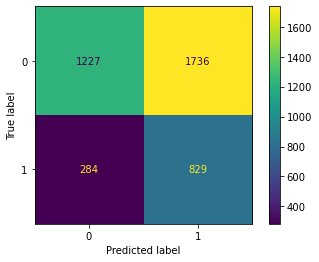

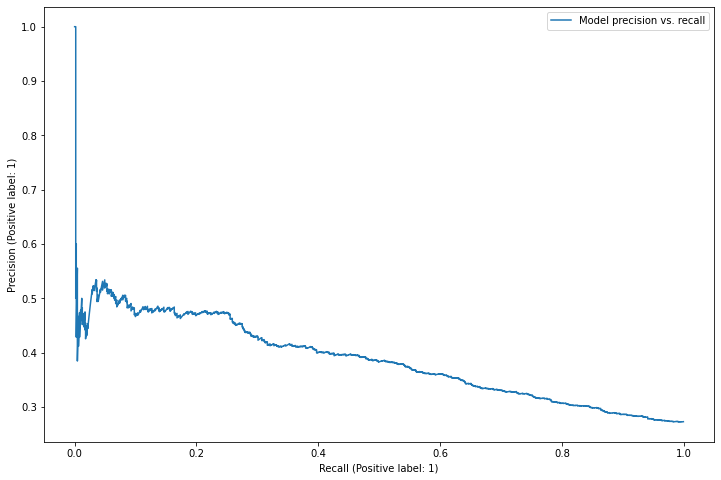

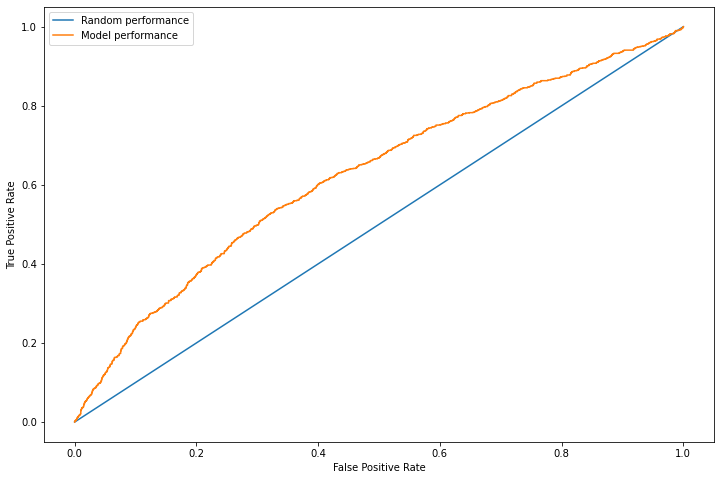

In [10]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [11]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-Adadelta' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-Adadelta20210603-0928


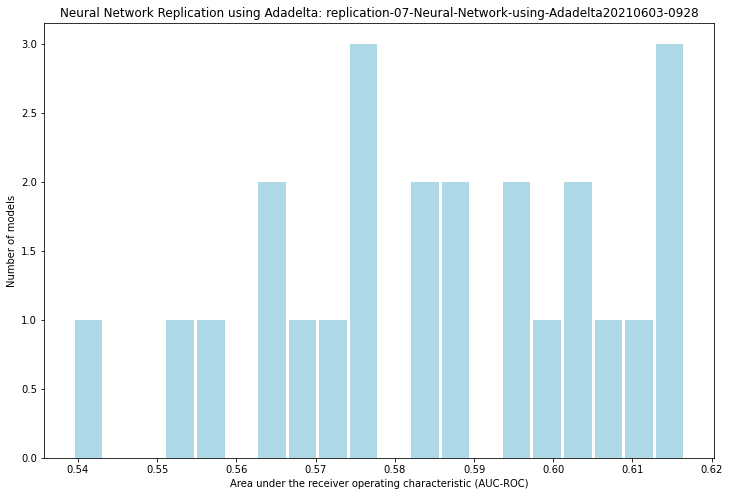

In [12]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using Adadelta: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [13]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../NeuralNetworkResults'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)